#專題資料結構
```
Project: DeepX
└─ original_dataset
   ├─ abnormal
   │   └─ abnormal_label
   │   └─ abnormal(.dcm)
   │   └─ abnormal(.jpg)
   ├─ normal
   │   └─ normal_label
   │   └─ normal(.dcm)
   │   └─ normal(.jpg)
└─ processed_dataset
   ├─ abnormal
   ├─ normal
└─ splitted_dataset
   ├─ test
   │   └─ abnormal
   │   └─ normal
   ├─ train
   │   └─ abnormal
   │   └─ normal
   ├─ train_argumentation
   │   └─ abnormal
   │   └─ normal
└─ tensor
   ├─ test
   ├─ train
└─ result
```

#連結Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Deep_X_torch') #切換目錄
os.listdir() #確認目錄內容

['SEResNet.py',
 '.DS_Store',
 'tensor',
 'processed_dataset',
 'splitted_dataset',
 'result',
 'original_dataset']

#將DCM檔轉成JPG檔

In [ ]:
!pip install pydicom
!pip install opencv-python

In [ ]:
from itertools import count
import pydicom
import cv2
import os

def dcm_to_png(folder_path,output_path,output_name):
    count = 1
    file_count = 0
    elbow_count = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm"):
            file_count += 1
            try:
                ds = pydicom.dcmread(os.path.join(folder_path, file_name))
                # 檢索患者年齡
                patient_name = ds.PatientName
                uid = ds.SeriesInstanceUID
                patient_age = ds.PatientAge
                patient_part = ds.BodyPartExamined

                if patient_part == "ELBOW":
                  elbow_count += 1

                # 打印患者年齡
                # print("Filename:",file_name)
                # print("classified:",output_name)
                # print("Patient's Name:", patient_name)
                # print("UID:", uid)
                # print("Patient's Age:", patient_age)
                # print("Patient's body part:", patient_part)
                # print("\n\n")
            except pydicom.errors.InvalidDicomError:
                continue

            data = ds.pixel_array
            image = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

            # calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), 0, 1.0)

            # apply the rotation matrix to the image
            rotated = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

            # adjust the brightness of the rotated image
            bright_image = cv2.convertScaleAbs(rotated, alpha=1, beta=0)

            # create a new folder for each PNG image
            folder_name = os.path.join(os.getcwd(), output_path, output_name + "(.jpg)")
            os.makedirs(folder_name, exist_ok=True)

            # save the enhanced image as a PNG file inside the folder
            file_prefix = os.path.splitext(file_name)[0]
            cv2.imwrite(os.path.join(folder_name, f"{output_name}_{count}.jpg"), bright_image)
            count += 1

    print(output_name)
    print("File numbers:" + str(file_count))
    print("Elbow numbers: " + str(elbow_count))

# set the path to the folder containing the DICOM images
dcm_path_abnormal = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.dcm)'
output_path_abnormal = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal'
dcm_path_normal = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.dcm)'
output_path_normal = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal'

# dcm_to_png(dcm_path_abnormal, output_path_abnormal, 'abnormal')
# dcm_to_png(dcm_path_normal, output_path_normal, 'normal')

dcm_path_test = '/content/drive/My Drive/Deep_X_torch/original_dataset/test/test(.dcm)'
output_path_test = '/content/drive/My Drive/Deep_X_torch/original_dataset/test'

dcm_to_png(dcm_path_test, output_path_test, 'test')

test
File numbers:4
Elbow numbers: 4


#資料前處理

In [ ]:
import cv2
import os

def remove_noise(img, kernel_size=(9, 9)):
    """去除噪聲"""
    blurred = cv2.GaussianBlur(img, kernel_size, 0)
    return blurred

def gray_scale(img):
    """轉換為灰度影像"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def process_images(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        if filename.endswith('.jpg'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            img = cv2.imread(input_path)
            clahe = cv2.createCLAHE(clipLimit=1)
            gray_img = gray_scale(img)
            clahe_img = clahe.apply(gray_img)
            cv2.imwrite(output_path, clahe_img)

normal_input_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.jpg)'
normal_output_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/normal'

abnormal_input_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.jpg)'
abnormal_output_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal'

process_images(normal_input_dir, normal_output_dir)
process_images(abnormal_input_dir, abnormal_output_dir)

#區分訓練集(train)和測試集(test)

In [ ]:
#Split the raw dataset into train set, valid set and test set.
import os
import random
import shutil

TRAIN_SET_RATIO = 0.7
TEST_SET_RATIO = 0.3

class SplitDataset():
    def __init__(self, dataset_dir, saved_dataset_dir, train_ratio=TRAIN_SET_RATIO, test_ratio=TEST_SET_RATIO, show_progress=False):
        self.dataset_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset/'
        self.saved_dataset_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/'
        self.saved_train_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/'
        self.saved_test_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/'

        self.train_ratio = train_ratio
        self.test_radio = test_ratio

        self.train_file_path = []
        self.test_file_path = []

        self.index_label_dict = {}

        self.show_progress = show_progress

        if not os.path.exists(self.saved_train_dir):
            os.mkdir(self.saved_train_dir)
        if not os.path.exists(self.saved_test_dir):
            os.mkdir(self.saved_test_dir)


    def __get_label_names(self):
        label_names = []
        for item in os.listdir(self.dataset_dir):
            item_path = os.path.join(self.dataset_dir, item)
            if os.path.isdir(item_path):
                label_names.append(item)
        return label_names

    def __get_all_file_path(self):
        all_file_path = []
        index = 0
        for file_type in self.__get_label_names():
            self.index_label_dict[index] = file_type
            index += 1
            type_file_path = os.path.join(self.dataset_dir, file_type)
            file_path = []
            for file in os.listdir(type_file_path):
                single_file_path = os.path.join(type_file_path, file)
                file_path.append(single_file_path)
            all_file_path.append(file_path)
        return all_file_path

    def __copy_files(self, type_path, type_saved_dir):
        for item in type_path:
            src_path_list = item[1]
            dst_path = type_saved_dir + "%s/" % (item[0])
            if not os.path.exists(dst_path):
                os.mkdir(dst_path)
            for src_path in src_path_list:
                shutil.copy(src_path, dst_path)
                if self.show_progress:
                    print("Copying file "+src_path+" to "+dst_path)

    def __split_dataset(self):
        all_file_paths = self.__get_all_file_path()
        for index in range(len(all_file_paths)):
            file_path_list = all_file_paths[index]
            file_path_list_length = len(file_path_list)
            random.shuffle(file_path_list)

            train_num = int(file_path_list_length * self.train_ratio)
            test_num = int(file_path_list_length * self.test_radio)
            test_num += 1

            self.train_file_path.append([self.index_label_dict[index], file_path_list[: train_num]])
            self.test_file_path.append([self.index_label_dict[index], file_path_list[train_num:train_num + test_num]])

    def start_splitting(self):
        self.__split_dataset()
        self.__copy_files(type_path=self.train_file_path, type_saved_dir=self.saved_train_dir)
        self.__copy_files(type_path=self.test_file_path, type_saved_dir=self.saved_test_dir)


if __name__ == '__main__':
    split_dataset = SplitDataset(dataset_dir='/content/drive/My Drive/Deep_X_torch/processed_dataset/',
                                 saved_dataset_dir='/content/drive/My Drive/Deep_X_torch/splitted_dataset/',
                                 show_progress=True)
    split_dataset.start_splitting()

Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_6.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_32.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_21.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_14.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_25.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copying file /content/drive/My Drive/Deep_X_torch/processed_dataset/abnormal/abnormal_2.jpg to /content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal/
Copyin

#訓練集資料增強


In [ ]:
!pip install imagecorruptions

In [ ]:
import glob
import cv2
import imgaug.augmenters as iaa
import os
from tqdm import trange

def data_augmentation(input_path, output_path, times):
    # Define a set of image augmentation operations using imgaug
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([
        iaa.SomeOf((0, 5), [
            # iaa.Fliplr(0),  # 有 0% 的概率水平翻轉
            # iaa.Flipud(0),  # 有 0% 的概率垂直翻轉
            iaa.Affine(rotate=(-10, 10)),  # 隨機旋轉圖像 -10 到 10 度
            iaa.OneOf([
                iaa.GaussianBlur((0, 1.5)),  # 高斯模糊，模糊程度在 0 到 1.5 之間
                iaa.AverageBlur(k=(2, 5)),   # 均值模糊，核的大小在 2 到 5 之間
                iaa.MedianBlur(k=(3, 7)),   # 中值模糊，核的大小在 3 到 8 之間
            ]),
            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # 銳化，參數可調
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 1.5)),  # 浮雕效果，參數可調
            iaa.Add((-10, 10), per_channel=0.5),  # 添加亮度，每通道亮度值在 -10 到 10 之間
            iaa.Multiply((0.5, 1.5)),  # 乘以亮度因子，值在 0.5 到 1.5 之間
            iaa.contrast.LinearContrast((0.7, 1.2)),  # 線性對比度，參數可調
            iaa.imgcorruptlike.Saturate(severity=3),  # 飽和度增強，程度為 3
        ], random_order=True)  # 隨機應用上述操作，順序隨機
    ], random_order=True)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Process each file in the input_path directory
    # Process each .jpg file in the input_path directory
    file_count = 0
    for jpg_file in glob.glob(os.path.join(input_path, '*.jpg')):
        img = cv2.imread(jpg_file)
        img_list = [img]  # Create a list with a single image

        for count in trange(times):
            images_aug = seq.augment_images(img_list)
            for index, augmented_image in enumerate(images_aug):
                filename = os.path.splitext(os.path.basename(jpg_file))[0]  # Extract the filename without extension
                output = os.path.join(output_path, f"{filename}_aug{count + 1}.jpg")
                cv2.imwrite(output, augmented_image)
        file_count += 1


    # Calculate and print statistics
    print("增強前圖片數量：" + str(file_count))
    print("增強後圖片數量：" + str(file_count * times))
    print("數據增強完成")

# Example usage:
normal_input_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
normal_output_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
abnormal_input_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
abnormal_output_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'

data_augmentation(normal_input_dir, normal_output_dir, 20)
data_augmentation(abnormal_input_dir, abnormal_output_dir, 20)

# test_dir = '/content/drive/My Drive/Deep_X_torch/original_dataset/test/test(.jpg)'

# data_augmentation(test_dir, test_dir, 20)


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


增強前圖片數量：11
增強後圖片數量：220
數據增強完成


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]

增強前圖片數量：22
增強後圖片數量：440
數據增強完成


#根據使用labelImg標記的label切割JPG檔案

In [ ]:
import cv2
import os

def crop_images(img_folder, label_folder, save_folder, crop_size=(224, 224)):
    # create new folder to save the cropped images
    os.makedirs(save_folder, exist_ok=True)

    # loop through each image file in the folder
    for img_file in os.listdir(img_folder):
        # check if the file is an image file
        if not img_file.endswith('.jpg'):
            continue

        # read the corresponding text file
        txt_file = img_file.split(".")[0]
        txt_file = txt_file.split("_")[0] + "_" + txt_file.split("_")[1] + '.txt'
        txt_path = os.path.join(label_folder, txt_file)
        print(txt_file)
        if not os.path.exists(txt_path):
            continue

        # read the image
        img_path = os.path.join(img_folder, img_file)
        img = cv2.imread(img_path)

        # read the bounding box and class label from the text file
        with open(txt_path, 'r') as f:
            line = f.readline()
            class_id, x_center, y_center, width, height = [float(x) for x in line.split()]

        # Convert coordinates to the top-left and bottom-right corners of the image
        x_min = int((x_center - width / 2) * img.shape[1])
        y_min = int((y_center - height / 2) * img.shape[0])
        x_max = int((x_center + width / 2) * img.shape[1])
        y_max = int((y_center + height / 2) * img.shape[0])

        # Crop the image and save it to the save folder
        cropped_img = img[y_min:y_max, x_min:x_max]
        cropped_img = cv2.resize(cropped_img, crop_size)
        save_path = os.path.join(save_folder, img_file)
        cv2.imwrite(save_path, cropped_img)

normal_label_folder = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal_label'
abnormal_label_folder = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal_label'

train_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
train_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_argumentation_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
train_argumentation_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'
test_normal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/normal'
test_abnormal_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/abnormal'

crop_images(train_normal_dir, normal_label_folder, train_normal_dir)
crop_images(train_abnormal_dir, abnormal_label_folder, train_abnormal_dir)
crop_images(train_argumentation_normal_dir, normal_label_folder, train_argumentation_normal_dir)
crop_images(train_argumentation_abnormal_dir, abnormal_label_folder, train_argumentation_abnormal_dir)
crop_images(test_normal_dir, normal_label_folder, test_normal_dir)
crop_images(test_abnormal_dir, abnormal_label_folder, test_abnormal_dir)

normal_2.txt
normal_8.txt
normal_11.txt
normal_13.txt
normal_14.txt
normal_6.txt
normal_9.txt
normal_3.txt
normal_12.txt
normal_16.txt
normal_7.txt
abnormal_6.txt
abnormal_32.txt
abnormal_21.txt
abnormal_14.txt
abnormal_25.txt
abnormal_2.txt
abnormal_8.txt
abnormal_4.txt
abnormal_3.txt
abnormal_15.txt
abnormal_27.txt
abnormal_11.txt
abnormal_12.txt
abnormal_18.txt
abnormal_26.txt
abnormal_28.txt
abnormal_23.txt
abnormal_5.txt
abnormal_13.txt
abnormal_1.txt
abnormal_22.txt
abnormal_20.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_2.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt
normal_8.txt


#將圖像轉換為張量

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms

def transform(image_path,tensor_path):
    # 設置轉換方式，將圖像轉換為張量
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # 遍歷資料夾中的所有檔案
    for filename in os.listdir(image_path):
        # 讀取圖像
        img_path = os.path.join(image_path, filename)
        img = Image.open(img_path)

        file_name,extension = os.path.splitext(filename)

        # 將圖像轉換為張量
        tensor_img = transform(img)

        # 將張量保存為.pt檔案
        tensors_path = os.path.join(tensor_path, file_name + ".pt")
        #print(tensors_path)
        torch.save(tensor_img,tensors_path)

train_normal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/normal'
train_abnormal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train_argumentation/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
test_normal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/normal'
test_abnormal_splitted_path = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/test/abnormal'
test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'

transform(train_normal_splitted_path,train_normal_tensor_path)
transform(train_abnormal_splitted_path,train_abnormal_tensor_path)
transform(test_normal_splitted_path,test_normal_tensor_path)
transform(test_abnormal_splitted_path,test_abnormal_tensor_path)

#訓練及驗證模型(5-Fold)

train dataset's size : 660
Device used : cuda
Fold: 1
train_dataset : 520 ,valid_dataset : 140
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_2/train_2/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result/result_2/train_2/valid_filenames.txt
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model initialized
[Training Progress]: 


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.16it/s]



Epoch: [1/30]  train_loss: 0.5889  -  train_accuracy: 0.7923 -  val_loss: 58.6719  -  val_accuracy: 0.2857  -  val_correct: 40        
wrong predict : [('abnormal_6_aug5.pt',), ('abnormal_27_aug1.pt',), ('abnormal_15_aug2.pt',), ('abnormal_15_aug5.pt',), ('abnormal_6_aug7.pt',), ('abnormal_6_aug19.pt',), ('abnormal_27_aug5.pt',), ('abnormal_4_aug16.pt',), ('abnormal_6_aug20.pt',), ('abnormal_6_aug11.pt',), ('abnormal_4_aug7.pt',), ('abnormal_15_aug20.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_27_aug12.pt',), ('abnormal_27_aug14.pt',), ('abnormal_27_aug18.pt',), ('abnormal_27_aug19.pt',), ('abnormal_15_aug9.pt',), ('abnormal_6_aug8.pt',), ('abnormal_3_aug19.pt',), ('abnormal_6_aug13.pt',), ('abnormal_15_aug4.pt',), ('abnormal_15_aug14.pt',), ('abnormal_4_aug19.pt',), ('abnormal_15_aug15.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug13.pt',), ('abnormal_6_aug14.pt',), ('abnormal_4_aug11.pt',), ('abnormal_6_aug3.pt',), ('abnormal_4_aug9.pt',), ('abnormal_3_a

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.40it/s]



Epoch: [2/30]  train_loss: 0.0969  -  train_accuracy: 0.9654 -  val_loss: 15.1055  -  val_accuracy: 0.4143  -  val_correct: 58        
wrong predict : [('abnormal_3_aug16.pt',), ('abnormal_15_aug5.pt',), ('abnormal_4_aug7.pt',), ('abnormal_27_aug16.pt',), ('abnormal_3_aug17.pt',), ('abnormal_27_aug20.pt',), ('abnormal_15_aug9.pt',), ('abnormal_27_aug7.pt',), ('abnormal_27_aug8.pt',), ('abnormal_27_aug3.pt',), ('abnormal_3_aug8.pt',), ('abnormal_27_aug14.pt',), ('abnormal_4_aug20.pt',), ('abnormal_3_aug1.pt',), ('abnormal_4_aug9.pt',), ('abnormal_3_aug11.pt',), ('abnormal_15_aug3.pt',), ('abnormal_4_aug5.pt',), ('abnormal_15_aug15.pt',), ('abnormal_27_aug9.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug13.pt',), ('abnormal_4_aug1.pt',), ('abnormal_3_aug6.pt',), ('abnormal_4_aug10.pt',), ('abnormal_27_aug19.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug1.pt',), ('abnormal_27_aug15.pt',), ('abnormal_27_aug18.pt',), ('abnormal_15_aug16.pt',), ('abnormal_3_aug20.pt',), ('abnormal_4_

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 34.90it/s]



Epoch: [3/30]  train_loss: 0.0155  -  train_accuracy: 1.0000 -  val_loss: 1.3387  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug10.pt',), ('abnormal_15_aug13.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_15_aug17.pt',), ('abnormal_15_aug1.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug10.pt',), ('abnormal_3_aug5.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug9.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug16.pt',), ('abnormal_15_aug6.pt',), ('abnormal_15_aug20.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug2.pt',), ('abnormal_27_aug18.pt',), ('abnormal_15_aug19.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug3.pt',), ('abnormal_15_aug4.pt',), ('abnormal_15_aug15.pt',), ('abnormal_15_aug16.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug19.pt',), ('abnormal_27_

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.09it/s]



Epoch: [4/30]  train_loss: 0.0152  -  train_accuracy: 0.9923 -  val_loss: 1.4710  -  val_accuracy: 0.6857  -  val_correct: 96        
wrong predict : [('abnormal_15_aug19.pt',), ('abnormal_15_aug20.pt',), ('abnormal_15_aug18.pt',), ('abnormal_3_aug19.pt',), ('abnormal_15_aug1.pt',), ('abnormal_3_aug20.pt',), ('abnormal_15_aug3.pt',), ('abnormal_15_aug13.pt',), ('abnormal_27_aug7.pt',), ('abnormal_15_aug16.pt',), ('abnormal_27_aug8.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug16.pt',), ('abnormal_27_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_15_aug17.pt',), ('abnormal_27_aug18.pt',), ('abnormal_3_aug11.pt',), ('abnormal_27_aug9.pt',), ('abnormal_27_aug11.pt',), ('abnormal_27_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug10.pt',), ('abnormal_15_aug2.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',), ('abnormal_15_aug10.pt',), ('abnormal_15_aug14.pt',), ('abnormal

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 40.32it/s]



Epoch: [5/30]  train_loss: 0.0217  -  train_accuracy: 0.9923 -  val_loss: 2.4054  -  val_accuracy: 0.7714  -  val_correct: 108       
wrong predict : [('abnormal_3_aug19.pt',), ('abnormal_27_aug14.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug1.pt',), ('abnormal_15_aug9.pt',), ('abnormal_27_aug9.pt',), ('abnormal_3_aug18.pt',), ('abnormal_27_aug18.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug4.pt',), ('abnormal_27_aug5.pt',), ('abnormal_27_aug8.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_27_aug3.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug20.pt',), ('abnormal_27_aug11.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug10.pt',), ('normal_16_aug20.pt',), ('normal_16_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug17.pt',), ('abnormal_27_aug4.pt',), ('abnormal_27_aug6.pt',)]
Model saved
	      Precis

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.94it/s]



Epoch: [6/30]  train_loss: 0.0129  -  train_accuracy: 0.9962 -  val_loss: 1.0718  -  val_accuracy: 0.7786  -  val_correct: 109       
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_27_aug7.pt',), ('normal_16_aug20.pt',), ('normal_16_aug2.pt',), ('abnormal_3_aug4.pt',), ('abnormal_27_aug11.pt',), ('abnormal_27_aug18.pt',), ('normal_16_aug4.pt',), ('abnormal_27_aug9.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('abnormal_27_aug3.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug18.pt',), ('abnormal_27_aug8.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_27_aug6.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug9.pt',)]
Model saved
	      Precision: 0.5692  -  Recall: 0.925

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 31.06it/s]



Epoch: [7/30]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 0.7210  -  val_accuracy: 0.7929  -  val_correct: 111       
wrong predict : [('abnormal_3_aug1.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug4.pt',), ('normal_16_aug2.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug12.pt',), ('abnormal_27_aug7.pt',), ('normal_16_aug20.pt',), ('abnormal_27_aug6.pt',), ('abnormal_27_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug19.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug11.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug2.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.5873  -  Recall: 0.9250  -  F1 Score: 0.7184
result_path:/content/drive/My

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.29it/s]



Epoch: [8/30]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 0.5931  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug8.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug3.pt',), ('normal_16_aug20.pt',), ('abnormal_27_aug18.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('normal_16_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug2.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug15.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug18.pt',)]
Model saved
	      Precision: 0.6167  -  Recall: 0.9250  -  F1 Score: 0.7400
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.18it/s]



Epoch: [9/30]  train_loss: 0.0042  -  train_accuracy: 1.0000 -  val_loss: 0.5393  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug15.pt',), ('abnormal_15_aug9.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug9.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug20.pt',), ('normal_16_aug4.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug17.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 31.55it/s]



Epoch: [10/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.5332  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug17.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug8.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug9.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug2.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug11.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 34.04it/s]



Epoch: [11/30]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.5689  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug6.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug2.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug18.pt',), ('normal_16_aug20.pt',), ('abnormal_15_aug12.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.11it/s]



Epoch: [12/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.5811  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug4.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug10.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug8.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug5.pt',), ('normal_16_aug4.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug6.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.20it/s]



Epoch: [13/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.6006  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',), ('abnormal_27_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug5.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug7.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug9.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 29.74it/s]



Epoch: [14/30]  train_loss: 0.0026  -  train_accuracy: 1.0000 -  val_loss: 0.6172  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug6.pt',), ('normal_16_aug20.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug3.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug16.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug5.pt',), ('normal_16_aug4.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.91it/s]



Epoch: [15/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.6133  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug3.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug1.pt',), ('normal_16_aug4.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug17.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug16.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug19.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug11.pt',), ('abnormal_15_aug7.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.23it/s]



Epoch: [16/30]  train_loss: 0.0029  -  train_accuracy: 1.0000 -  val_loss: 0.6195  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug16.pt',), ('abnormal_3_aug18.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug11.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug1.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug12.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug8.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug4.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug7.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.98it/s]



Epoch: [17/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.6423  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('normal_16_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug17.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug10.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug9.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug13.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.28it/s]



Epoch: [18/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.6207  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug2.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug12.pt',), ('normal_16_aug4.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug8.pt',), ('normal_16_aug20.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug6.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug14.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.91it/s]



Epoch: [19/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6082  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_15_aug9.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug18.pt',), ('abnormal_27_aug7.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug1.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.56it/s]



Epoch: [20/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6097  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('normal_16_aug4.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug11.pt',), ('abnormal_27_aug7.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug17.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 31.40it/s]



Epoch: [21/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.6068  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug7.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug12.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug16.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug8.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug19.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 34.11it/s]



Epoch: [22/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6097  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug5.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('normal_16_aug4.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug4.pt',), ('normal_16_aug20.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug3.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.18it/s]



Epoch: [23/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.5966  -  val_accuracy: 0.8214  -  val_correct: 115       
wrong predict : [('abnormal_3_aug18.pt',), ('abnormal_3_aug14.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug16.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug5.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug1.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug19.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug15.pt',)]
Model saved
	      Precision: 0.6230  -  Recall: 0.9500  -  F1 Score: 0.7525
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.50it/s]



Epoch: [24/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.6205  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_27_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug19.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 31.31it/s]



Epoch: [25/30]  train_loss: 0.0035  -  train_accuracy: 1.0000 -  val_loss: 0.6523  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug17.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug13.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug18.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug9.pt',), ('abnormal_27_aug7.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug20.pt',), ('normal_16_aug20.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.35it/s]



Epoch: [26/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6237  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug14.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug9.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug5.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug6.pt',), ('normal_16_aug4.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug7.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.37it/s]



Epoch: [27/30]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 0.6229  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug20.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug14.pt',), ('abnormal_15_aug7.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug8.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug15.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug9.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug11.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 30.40it/s]



Epoch: [28/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.6191  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('normal_16_aug20.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_27_aug7.pt',), ('abnormal_15_aug7.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug14.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 36.90it/s]



Epoch: [29/30]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.6114  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug17.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug3.pt',), ('abnormal_15_aug12.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug16.pt',), ('abnormal_27_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug19.pt',), ('abnormal_15_aug7.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug9.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug13.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.94it/s]



Epoch: [30/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 0.6110  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_27_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug4.pt',), ('normal_16_aug4.pt',), ('abnormal_3_aug14.pt',), ('abnormal_3_aug7.pt',), ('normal_16_aug20.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug8.pt',), ('abnormal_15_aug9.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug10.pt',), ('abnormal_15_aug7.pt',), ('abnormal_15_aug12.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug15.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
Confusion matrix:
[[38 24]
 [ 2 76]]
CSV output Sucessfully
Fold: 2
train_dataset : 520 ,valid_dataset : 

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.08it/s]



Epoch: [1/30]  train_loss: 0.4503  -  train_accuracy: 0.8212 -  val_loss: 35.9899  -  val_accuracy: 0.5714  -  val_correct: 80        
wrong predict : [('abnormal_2_aug2.pt',), ('abnormal_11_aug15.pt',), ('abnormal_14_aug9.pt',), ('abnormal_2_aug5.pt',), ('abnormal_14_aug16.pt',), ('abnormal_2_aug20.pt',), ('abnormal_2_aug9.pt',), ('abnormal_11_aug7.pt',), ('abnormal_11_aug14.pt',), ('abnormal_11_aug9.pt',), ('abnormal_14_aug2.pt',), ('abnormal_11_aug12.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug20.pt',), ('abnormal_11_aug1.pt',), ('abnormal_14_aug10.pt',), ('abnormal_2_aug13.pt',), ('abnormal_2_aug12.pt',), ('abnormal_11_aug5.pt',), ('abnormal_2_aug8.pt',), ('abnormal_2_aug17.pt',), ('abnormal_14_aug14.pt',), ('abnormal_2_aug6.pt',), ('abnormal_11_aug13.pt',), ('abnormal_2_aug11.pt',), ('abnormal_14_aug15.pt',), ('abnormal_2_aug16.pt',), ('abnormal_14_aug1.pt',), ('abnormal_2_aug10.pt',), ('abnormal_2_aug3.pt',), ('abnormal_11_aug4.pt',), ('abnormal_

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.66it/s]



Epoch: [2/30]  train_loss: 0.0793  -  train_accuracy: 0.9769 -  val_loss: 30.2563  -  val_accuracy: 0.4429  -  val_correct: 62        
wrong predict : [('normal_14_aug7.pt',), ('normal_13_aug11.pt',), ('normal_11_aug9.pt',), ('normal_9_aug8.pt',), ('normal_13_aug19.pt',), ('normal_11_aug10.pt',), ('normal_9_aug2.pt',), ('normal_11_aug13.pt',), ('normal_14_aug4.pt',), ('normal_13_aug8.pt',), ('normal_13_aug14.pt',), ('normal_11_aug3.pt',), ('normal_11_aug14.pt',), ('normal_13_aug16.pt',), ('normal_13_aug18.pt',), ('normal_9_aug7.pt',), ('normal_11_aug6.pt',), ('normal_13_aug7.pt',), ('normal_9_aug12.pt',), ('normal_13_aug9.pt',), ('normal_11_aug4.pt',), ('normal_14_aug15.pt',), ('normal_9_aug5.pt',), ('normal_9_aug1.pt',), ('normal_11_aug2.pt',), ('normal_14_aug3.pt',), ('normal_9_aug13.pt',), ('normal_11_aug20.pt',), ('normal_11_aug12.pt',), ('normal_14_aug8.pt',), ('normal_13_aug1.pt',), ('normal_13_aug5.pt',), ('normal_14_aug1.pt',), ('normal_13_aug15.pt',), ('normal_11_aug7.pt',), 

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.21it/s]



Epoch: [3/30]  train_loss: 0.0364  -  train_accuracy: 0.9942 -  val_loss: 2.2944  -  val_accuracy: 0.6000  -  val_correct: 84        
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('abnormal_2_aug8.pt',), ('abnormal_14_aug20.pt',), ('abnormal_11_aug12.pt',), ('abnormal_11_aug6.pt',), ('abnormal_2_aug11.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug1.pt',), ('abnormal_2_aug10.pt',), ('abnormal_14_aug3.pt',), ('abnormal_11_aug20.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug5.pt',), ('abnormal_11_aug1.pt',), ('abnormal_11_aug11.pt',), ('abnormal_11_aug15.pt',), ('abnormal_2_aug4.pt',), ('abnormal_14_aug19.pt',), ('abnormal_2_aug3.pt',), ('abnormal_2_aug12.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug15.pt',), ('abnormal_11_aug4.pt',), ('abnormal_2_aug20.pt',), ('abnormal_14_aug6.pt',), ('abnormal_11_aug7.pt',), ('abnormal_11_aug8.pt',), ('abnormal_14_aug11.pt',), ('abno

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.53it/s]



Epoch: [4/30]  train_loss: 0.0057  -  train_accuracy: 1.0000 -  val_loss: 0.7479  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('normal_14_aug3.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug15.pt',), ('normal_11_aug2.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug8.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug18.pt',), ('abnormal_2_aug18.pt',), ('normal_14_aug10.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug7.pt',)]
Model saved
	      Precision: 0.7872  -  Recall: 0.9250  -  F1 Score: 0.8506
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Trainin

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.95it/s]



Epoch: [5/30]  train_loss: 0.0133  -  train_accuracy: 0.9981 -  val_loss: 3.1798  -  val_accuracy: 0.6429  -  val_correct: 90        
wrong predict : [('abnormal_2_aug10.pt',), ('abnormal_2_aug13.pt',), ('abnormal_11_aug13.pt',), ('abnormal_2_aug9.pt',), ('abnormal_2_aug15.pt',), ('abnormal_2_aug4.pt',), ('abnormal_2_aug7.pt',), ('abnormal_2_aug20.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug15.pt',), ('abnormal_2_aug2.pt',), ('abnormal_2_aug1.pt',), ('abnormal_2_aug12.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug6.pt',), ('abnormal_2_aug16.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug4.pt',), ('abnormal_2_aug6.pt',), ('abnormal_11_aug2.pt',), ('abnormal_14_aug14.pt',), ('abnormal_2_aug3.pt',), ('abnormal_14_aug16.pt',), ('normal_14_aug17.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug8.pt',), ('abnormal_11_aug1.pt',), ('abnormal_14_aug

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.65it/s]



Epoch: [6/30]  train_loss: 0.0071  -  train_accuracy: 0.9981 -  val_loss: 1.6239  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug15.pt',), ('normal_14_aug18.pt',), ('normal_11_aug14.pt',), ('normal_11_aug18.pt',), ('normal_11_aug16.pt',), ('normal_14_aug20.pt',), ('normal_11_aug20.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug3.pt',), ('normal_14_aug9.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug13.pt',), ('normal_14_aug10.pt',), ('abnormal_14_aug13.pt',), ('normal_11_aug8.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug12.pt',), ('normal_14_aug17.pt',), ('normal_14_aug5.pt',), ('normal_13_aug12.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug6.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug1.pt',), ('normal_11_aug10.pt',), ('normal_14_aug12.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug17.pt',), ('normal_14_a

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.13it/s]



Epoch: [7/30]  train_loss: 0.0028  -  train_accuracy: 1.0000 -  val_loss: 1.8362  -  val_accuracy: 0.5500  -  val_correct: 77        
wrong predict : [('normal_14_aug14.pt',), ('normal_14_aug13.pt',), ('normal_11_aug20.pt',), ('normal_14_aug6.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug3.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug13.pt',), ('normal_11_aug2.pt',), ('abnormal_14_aug19.pt',), ('normal_13_aug17.pt',), ('normal_11_aug15.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug20.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug4.pt',), ('abnormal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_14_aug5.pt',), ('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('normal_14_aug8.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug10.pt',), ('normal_14_aug11.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug16.pt',), ('normal_11_aug3.pt',), ('normal_11_aug17.pt',), ('normal_11_aug9.pt',), ('normal_11_aug6.pt',), ('normal_13_aug

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.53it/s]



Epoch: [8/30]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.8999  -  val_accuracy: 0.5571  -  val_correct: 78        
wrong predict : [('normal_11_aug12.pt',), ('normal_14_aug19.pt',), ('normal_11_aug6.pt',), ('normal_11_aug4.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug16.pt',), ('normal_11_aug16.pt',), ('normal_11_aug19.pt',), ('normal_11_aug3.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug1.pt',), ('normal_14_aug15.pt',), ('normal_14_aug3.pt',), ('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug10.pt',), ('normal_13_aug11.pt',), ('normal_11_aug20.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug7.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug6.pt',), ('normal_11_aug8.pt',), ('normal_14_aug20.pt',), ('abnormal_14_aug7.pt',), ('normal_11_aug9.p

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.34it/s]



Epoch: [9/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.7965  -  val_accuracy: 0.5571  -  val_correct: 78        
wrong predict : [('abnormal_14_aug20.pt',), ('normal_11_aug2.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug2.pt',), ('normal_11_aug11.pt',), ('normal_11_aug20.pt',), ('normal_11_aug4.pt',), ('normal_11_aug1.pt',), ('normal_11_aug5.pt',), ('abnormal_14_aug5.pt',), ('normal_14_aug11.pt',), ('normal_14_aug18.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug8.pt',), ('normal_14_aug13.pt',), ('normal_14_aug2.pt',), ('normal_14_aug6.pt',), ('normal_14_aug10.pt',), ('normal_14_aug16.pt',), ('normal_14_aug8.pt',), ('normal_11_aug6.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug17.pt',), ('normal_11_aug3.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug17.pt',), ('normal_11_aug18.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('normal_13_aug12.pt',), ('normal_11_aug10.pt',), ('normal_14_aug20

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.60it/s]



Epoch: [10/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.6542  -  val_accuracy: 0.5714  -  val_correct: 80        
wrong predict : [('abnormal_14_aug1.pt',), ('normal_14_aug3.pt',), ('normal_14_aug8.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug7.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug19.pt',), ('normal_14_aug16.pt',), ('normal_14_aug18.pt',), ('normal_14_aug20.pt',), ('normal_14_aug4.pt',), ('normal_11_aug1.pt',), ('normal_14_aug14.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug12.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug2.pt',), ('normal_11_aug11.pt',), ('normal_14_aug11.pt',), ('normal_11_aug8.pt',), ('normal_11_aug3.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug16.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug5.pt',), ('normal_14_aug6.pt',), ('normal_11_aug5.pt',), ('normal_11_aug6.pt',), ('normal_11_aug16.pt',), ('normal_11_aug

100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 29.29it/s]



Epoch: [11/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.6143  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('abnormal_14_aug18.pt',), ('normal_14_aug11.pt',), ('normal_14_aug18.pt',), ('normal_11_aug15.pt',), ('normal_11_aug5.pt',), ('normal_14_aug10.pt',), ('normal_11_aug12.pt',), ('normal_11_aug14.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug2.pt',), ('normal_11_aug9.pt',), ('normal_11_aug8.pt',), ('abnormal_14_aug4.pt',), ('normal_11_aug2.pt',), ('abnormal_14_aug13.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug6.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug16.pt',), ('normal_14_aug13.pt',), ('normal_11_aug6.pt',), ('abnormal_14_aug12.pt',), ('normal_14_aug5.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug3.pt',), ('normal_14_aug14.pt',), ('normal_14_aug8.pt',), ('normal_13_aug12.pt',), ('abnormal_14_aug5.pt',), ('abnormal_1

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.28it/s]



Epoch: [12/30]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 1.6065  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug19.pt',), ('normal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug19.pt',), ('normal_14_aug7.pt',), ('normal_11_aug17.pt',), ('normal_14_aug6.pt',), ('normal_14_aug15.pt',), ('normal_14_aug8.pt',), ('normal_11_aug15.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug13.pt',), ('normal_14_aug9.pt',), ('normal_14_aug4.pt',), ('normal_11_aug16.pt',), ('normal_11_aug11.pt',), ('normal_11_aug13.pt',), ('normal_11_aug10.pt',), ('normal_11_aug1.pt',), ('normal_11_aug3.pt',), ('normal_11_aug6.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug7.pt',), ('normal_11_aug20.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug9.pt',), ('normal_14_aug3.pt',), ('normal_11_aug2.pt',), ('normal_11_aug4.pt',), ('abnormal_14_aug4.pt',), ('normal_11_aug7.pt',), ('normal_14_aug20.pt',), ('abnormal_14_aug18.pt',)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.85it/s]



Epoch: [13/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.6329  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug15.pt',), ('normal_14_aug4.pt',), ('normal_11_aug12.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug15.pt',), ('normal_14_aug9.pt',), ('abnormal_14_aug6.pt',), ('normal_14_aug20.pt',), ('normal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('normal_14_aug2.pt',), ('normal_14_aug1.pt',), ('normal_11_aug19.pt',), ('normal_14_aug3.pt',), ('normal_11_aug20.pt',), ('abnormal_14_aug14.pt',), ('normal_11_aug9.pt',), ('normal_14_aug18.pt',), ('normal_11_aug18.pt',), ('normal_11_aug16.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug8.pt',), ('normal_11_aug11.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug11.pt',), ('normal_11_aug5.pt',), ('normal_11_aug2.pt',), ('normal_11_aug14.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug3.pt',), ('normal_11_aug1

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.29it/s]



Epoch: [14/30]  train_loss: 0.0031  -  train_accuracy: 1.0000 -  val_loss: 1.5904  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug6.pt',), ('normal_11_aug13.pt',), ('normal_14_aug10.pt',), ('normal_14_aug8.pt',), ('normal_11_aug12.pt',), ('normal_11_aug6.pt',), ('normal_14_aug2.pt',), ('normal_11_aug16.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug4.pt',), ('normal_11_aug3.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',), ('normal_11_aug14.pt',), ('normal_14_aug7.pt',), ('normal_14_aug16.pt',), ('normal_11_aug19.pt',), ('normal_11_aug10.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug20.pt',), ('normal_14_aug18.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug15.pt',), ('normal_

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.05it/s]



Epoch: [15/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.5918  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_13_aug12.pt',), ('normal_14_aug14.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug5.pt',), ('normal_11_aug7.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug10.pt',), ('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('normal_11_aug11.pt',), ('normal_14_aug6.pt',), ('normal_11_aug18.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug2.pt',), ('normal_11_aug12.pt',), ('normal_14_aug12.pt',), ('normal_11_aug6.pt',), ('normal_11_aug16.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug3.pt',), ('normal_11_aug4.pt',), ('normal_11_aug3.pt',), ('normal_11_aug19.pt',), ('normal_11_aug20.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug5.pt',), ('normal_14_aug18.pt',), ('normal_11_aug8.pt',), ('abnormal_14_aug12.pt',), ('normal_14_aug8.pt',), ('normal_11_aug5.pt',

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.11it/s]



Epoch: [16/30]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 1.5766  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('abnormal_14_aug20.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug7.pt',), ('normal_14_aug15.pt',), ('normal_11_aug18.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug8.pt',), ('normal_14_aug13.pt',), ('normal_11_aug12.pt',), ('normal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug5.pt',), ('normal_14_aug11.pt',), ('normal_13_aug12.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug1.pt',), ('normal_14_aug2.pt',), ('normal_14_aug12.pt',), ('normal_11_aug13.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug8.pt',), ('normal_11_aug16.pt',), ('normal_11_aug19.pt',), ('normal_11_aug3.pt',), ('normal_1

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.26it/s]



Epoch: [17/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.6217  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug9.pt',), ('normal_14_aug10.pt',), ('normal_11_aug13.pt',), ('normal_11_aug16.pt',), ('abnormal_14_aug2.pt',), ('normal_14_aug17.pt',), ('normal_11_aug10.pt',), ('normal_14_aug3.pt',), ('normal_13_aug12.pt',), ('abnormal_14_aug12.pt',), ('normal_11_aug9.pt',), ('normal_11_aug4.pt',), ('normal_11_aug2.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug7.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug19.pt',), ('normal_14_aug6.pt',), ('normal_11_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug12.pt',), ('normal_11_aug18.pt',), ('normal_11_aug12.pt',), ('normal_11_aug5.pt',), ('abnormal_14_aug10.pt',), ('normal_14_aug20.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug17.pt',), ('abnormal_14_aug16.pt',), ('normal_14_aug4.pt',), ('abnormal_14_au

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.77it/s]



Epoch: [18/30]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.6126  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('abnormal_14_aug10.pt',), ('abnormal_14_aug19.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug7.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug10.pt',), ('normal_13_aug12.pt',), ('normal_14_aug14.pt',), ('normal_14_aug16.pt',), ('abnormal_14_aug2.pt',), ('normal_14_aug15.pt',), ('normal_14_aug1.pt',), ('normal_11_aug18.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug13.pt',), ('normal_14_aug8.pt',), ('normal_14_aug2.pt',), ('normal_11_aug10.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug14.pt',), ('normal_11_aug8.pt',), ('normal_14_aug9.pt',), ('normal_11_aug14.pt',), ('normal_11_aug11.pt',), ('abnormal_14_aug20.pt',), ('normal_11_aug5.pt',), ('abnormal_14_aug3.pt',), ('normal_14_aug11.pt',), ('normal_11_aug20.pt',), ('abnormal_14_aug15.pt',), ('normal_11

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.16it/s]



Epoch: [19/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 1.5744  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('abnormal_14_aug17.pt',), ('normal_11_aug19.pt',), ('normal_11_aug4.pt',), ('normal_14_aug11.pt',), ('normal_11_aug5.pt',), ('normal_14_aug4.pt',), ('normal_14_aug15.pt',), ('normal_14_aug8.pt',), ('abnormal_14_aug8.pt',), ('normal_11_aug17.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug12.pt',), ('normal_11_aug14.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug6.pt',), ('normal_11_aug1.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug1.pt',), ('normal_11_aug12.pt',), ('abnormal_14_aug4.pt',), ('normal_11_aug18.pt',), ('normal_14_aug19.pt',), ('normal_11_aug15.pt',), ('normal_14_aug17.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug20.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug16.pt',), ('normal_14_au

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.27it/s]



Epoch: [20/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.5691  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug8.pt',), ('normal_11_aug19.pt',), ('normal_11_aug3.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug13.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug15.pt',), ('normal_11_aug7.pt',), ('normal_14_aug11.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug2.pt',), ('normal_11_aug2.pt',), ('normal_14_aug15.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug4.pt',), ('normal_11_aug11.pt',), ('normal_14_aug6.pt',), ('normal_14_aug1.pt',), ('normal_13_aug12.pt',), ('normal_11_aug6.pt',), ('normal_11_aug15.pt',), ('normal_11_aug18.pt',), ('normal_11_aug14.pt',), ('normal_11_aug10.pt',), ('abnormal_14_aug4.pt',), ('normal_11_aug1.pt',), ('normal_14_aug17.pt',), ('normal_14_aug5.pt',), ('normal_14_aug20.pt',), ('normal_14_aug10.pt',), ('normal_14_aug3.pt',), ('normal_14_aug18.pt',)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.07it/s]



Epoch: [21/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.5941  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug4.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug15.pt',), ('normal_14_aug10.pt',), ('normal_14_aug6.pt',), ('normal_11_aug20.pt',), ('normal_14_aug7.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug2.pt',), ('normal_11_aug19.pt',), ('normal_14_aug14.pt',), ('normal_11_aug5.pt',), ('normal_11_aug6.pt',), ('normal_14_aug9.pt',), ('abnormal_14_aug5.pt',), ('normal_13_aug12.pt',), ('normal_14_aug1.pt',), ('abnormal_14_aug11.pt',), ('normal_11_aug9.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug6.pt',), ('normal_11_aug11.pt',), ('normal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_11_aug3.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug17.pt',), ('normal_11_aug17.pt',), ('abnormal_14_aug18.pt',), ('normal_14_au

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.17it/s]



Epoch: [22/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.6153  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug13.pt',), ('normal_11_aug11.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug16.pt',), ('normal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug7.pt',), ('normal_11_aug12.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('normal_13_aug12.pt',), ('normal_11_aug2.pt',), ('normal_14_aug11.pt',), ('normal_11_aug1.pt',), ('normal_11_aug14.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug20.pt',), ('normal_11_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug15.pt',), ('normal_11_aug10.pt',), ('normal_14_aug10.pt',), ('abnormal_14_aug15.pt',), ('normal_14_aug6.pt',), ('normal_14_aug18.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug15.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug8.pt',), ('normal_11_aug19.pt',), ('normal_14

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.03it/s]



Epoch: [23/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.6031  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug17.pt',), ('normal_11_aug17.pt',), ('normal_11_aug5.pt',), ('abnormal_14_aug10.pt',), ('normal_14_aug8.pt',), ('normal_11_aug4.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug16.pt',), ('normal_11_aug10.pt',), ('normal_14_aug5.pt',), ('normal_11_aug9.pt',), ('normal_11_aug6.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug14.pt',), ('normal_11_aug12.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug20.pt',), ('normal_11_aug7.pt',), ('normal_14_aug12.pt',), ('normal_14_aug6.pt',), ('normal_11_aug16.pt',), ('normal_11_aug2.pt',), ('normal_11_aug8.pt',), ('abnormal_14_aug8.pt',), ('normal_11_aug19.pt',), ('normal_13_aug12.pt',), ('abnormal_14_aug6.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug11.pt',), ('normal_14_aug15.pt',), ('normal_11_aug13.pt',), ('abnormal_14_aug1.pt

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 36.31it/s]



Epoch: [24/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.5782  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('abnormal_14_aug19.pt',), ('normal_11_aug14.pt',), ('normal_11_aug10.pt',), ('normal_11_aug2.pt',), ('abnormal_14_aug6.pt',), ('normal_14_aug5.pt',), ('normal_11_aug13.pt',), ('abnormal_14_aug1.pt',), ('normal_14_aug6.pt',), ('normal_13_aug12.pt',), ('abnormal_14_aug12.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug9.pt',), ('normal_11_aug3.pt',), ('normal_14_aug20.pt',), ('normal_14_aug14.pt',), ('normal_14_aug7.pt',), ('normal_14_aug16.pt',), ('normal_11_aug1.pt',), ('normal_14_aug8.pt',), ('normal_11_aug17.pt',), ('abnormal_14_aug11.pt',), ('normal_11_aug12.pt',), ('normal_14_aug2.pt',), ('normal_11_aug18.pt',), ('normal_11_aug5.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug4.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug15.pt',), ('normal_14_aug9.pt',), ('abnormal_14_aug1

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.33it/s]



Epoch: [25/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.6023  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug10.pt',), ('abnormal_14_aug17.pt',), ('normal_11_aug17.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug11.pt',), ('abnormal_14_aug20.pt',), ('normal_11_aug5.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug6.pt',), ('normal_14_aug19.pt',), ('normal_11_aug18.pt',), ('normal_11_aug9.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug18.pt',), ('normal_14_aug17.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug6.pt',), ('normal_11_aug20.pt',), ('normal_14_aug2.pt',), ('normal_14_aug15.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug7.pt',), ('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('normal_11_aug3.pt',), ('abnormal_14_aug14.pt',), ('normal_14_aug4.pt',), ('normal_14_aug6.pt',), ('normal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('normal_11_aug

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.63it/s]



Epoch: [26/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.6036  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug12.pt',), ('normal_14_aug9.pt',), ('normal_11_aug8.pt',), ('normal_14_aug11.pt',), ('normal_14_aug20.pt',), ('normal_11_aug3.pt',), ('normal_14_aug13.pt',), ('normal_14_aug6.pt',), ('normal_14_aug10.pt',), ('normal_11_aug9.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug3.pt',), ('normal_14_aug3.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug17.pt',), ('normal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug20.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('normal_14_aug16.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug11.pt',), ('normal_13_aug12.pt',), ('normal_14_aug2.pt',), ('normal_11_aug13.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.61it/s]



Epoch: [27/30]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 1.6203  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug7.pt',), ('normal_14_aug13.pt',), ('abnormal_14_aug16.pt',), ('normal_11_aug19.pt',), ('abnormal_14_aug13.pt',), ('normal_11_aug16.pt',), ('abnormal_14_aug19.pt',), ('normal_11_aug1.pt',), ('normal_14_aug16.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug3.pt',), ('normal_14_aug18.pt',), ('normal_14_aug17.pt',), ('normal_14_aug3.pt',), ('normal_11_aug9.pt',), ('normal_11_aug17.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug18.pt',), ('normal_11_aug8.pt',), ('normal_14_aug8.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug6.pt',), ('normal_11_aug2.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug12.pt',), ('normal_13_aug12.pt',), ('normal_11_aug15.pt',), ('normal_14_aug20.pt',), ('normal_14_aug11.pt',), ('normal_14

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.63it/s]



Epoch: [28/30]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 1.6295  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_11_aug16.pt',), ('normal_11_aug17.pt',), ('normal_14_aug7.pt',), ('normal_11_aug15.pt',), ('normal_11_aug10.pt',), ('normal_14_aug12.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug1.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug16.pt',), ('normal_14_aug13.pt',), ('normal_14_aug2.pt',), ('abnormal_14_aug8.pt',), ('normal_14_aug19.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug10.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug7.pt',), ('normal_14_aug5.pt',), ('abnormal_14_aug16.pt',), ('normal_11_aug19.pt',), ('normal_11_aug3.pt',), ('normal_11_aug14.pt',), ('normal_11_aug9.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('normal_11_aug5.pt',), ('normal_14_aug3.pt',), ('normal_14_aug9.pt',), ('normal_11_aug13.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.33it/s]



Epoch: [29/30]  train_loss: 0.0032  -  train_accuracy: 1.0000 -  val_loss: 1.5845  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug10.pt',), ('normal_14_aug9.pt',), ('normal_11_aug14.pt',), ('normal_11_aug11.pt',), ('normal_11_aug16.pt',), ('normal_14_aug12.pt',), ('normal_11_aug8.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('normal_14_aug8.pt',), ('normal_11_aug4.pt',), ('abnormal_14_aug12.pt',), ('normal_11_aug15.pt',), ('normal_11_aug10.pt',), ('normal_14_aug19.pt',), ('normal_14_aug20.pt',), ('normal_11_aug17.pt',), ('normal_14_aug17.pt',), ('normal_14_aug3.pt',), ('normal_14_aug6.pt',), ('normal_11_aug1.pt',), ('abnormal_14_aug2.pt',), ('normal_14_aug5.pt',), ('normal_14_aug16.pt',), ('normal_11_aug7.pt',), ('normal_11_aug6.pt',), ('normal_14_aug1.pt',), ('normal_11_aug20.pt',), ('abnormal_14_aug10.pt',), ('normal_11_aug12.pt',), ('abnormal_14_aug18.pt',), ('normal_14_aug14.pt

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.19it/s]



Epoch: [30/30]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 1.5912  -  val_accuracy: 0.5643  -  val_correct: 79        
wrong predict : [('normal_14_aug17.pt',), ('normal_14_aug4.pt',), ('abnormal_14_aug7.pt',), ('normal_11_aug15.pt',), ('abnormal_14_aug16.pt',), ('normal_14_aug6.pt',), ('normal_14_aug11.pt',), ('normal_11_aug17.pt',), ('normal_11_aug18.pt',), ('normal_14_aug16.pt',), ('normal_11_aug6.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug8.pt',), ('normal_13_aug12.pt',), ('normal_14_aug12.pt',), ('normal_11_aug12.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug9.pt',), ('normal_14_aug2.pt',), ('normal_14_aug8.pt',), ('normal_14_aug15.pt',), ('normal_14_aug7.pt',), ('normal_14_aug18.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug2.pt',), ('normal_11_aug8.pt',), ('abnormal_14_aug3.pt',), ('normal_11_aug7.pt',), ('abnormal_14_aug20.pt',), ('normal_11_aug16.pt',), ('normal_11_aug20.pt',), ('normal_11_aug4.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_a

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.67it/s]



Epoch: [1/30]  train_loss: 0.4124  -  train_accuracy: 0.8346 -  val_loss: 12.8819  -  val_accuracy: 0.2857  -  val_correct: 40        
wrong predict : [('abnormal_12_aug9.pt',), ('abnormal_12_aug5.pt',), ('abnormal_28_aug1.pt',), ('abnormal_23_aug1.pt',), ('abnormal_28_aug3.pt',), ('abnormal_23_aug18.pt',), ('abnormal_18_aug14.pt',), ('abnormal_1_aug19.pt',), ('abnormal_18_aug15.pt',), ('abnormal_12_aug20.pt',), ('abnormal_18_aug11.pt',), ('abnormal_12_aug15.pt',), ('abnormal_23_aug16.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug18.pt',), ('abnormal_23_aug12.pt',), ('abnormal_18_aug1.pt',), ('abnormal_28_aug15.pt',), ('abnormal_1_aug16.pt',), ('abnormal_18_aug19.pt',), ('abnormal_18_aug9.pt',), ('abnormal_1_aug3.pt',), ('abnormal_18_aug8.pt',), ('abnormal_18_aug3.pt',), ('abnormal_23_aug4.pt',), ('abnormal_12_aug13.pt',), ('abnormal_28_aug5.pt',), ('abnormal_28_aug6.pt',), ('abnormal_23_aug5.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug4.pt',), ('abnormal_18_aug4.pt',), ('abnor

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.98it/s]



Epoch: [2/30]  train_loss: 0.0728  -  train_accuracy: 0.9808 -  val_loss: 58.2313  -  val_accuracy: 0.2857  -  val_correct: 40        
wrong predict : [('abnormal_18_aug7.pt',), ('abnormal_23_aug14.pt',), ('abnormal_1_aug6.pt',), ('abnormal_18_aug8.pt',), ('abnormal_18_aug16.pt',), ('abnormal_28_aug8.pt',), ('abnormal_23_aug15.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug17.pt',), ('abnormal_18_aug3.pt',), ('abnormal_1_aug10.pt',), ('abnormal_28_aug16.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug2.pt',), ('abnormal_18_aug20.pt',), ('abnormal_23_aug10.pt',), ('abnormal_12_aug16.pt',), ('abnormal_23_aug17.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug8.pt',), ('abnormal_23_aug20.pt',), ('abnormal_28_aug19.pt',), ('abnormal_1_aug16.pt',), ('abnormal_18_aug14.pt',), ('abnormal_12_aug19.pt',), ('abnormal_18_aug4.pt',), ('abnormal_23_aug18.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug8.pt',), ('abn

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.93it/s]



Epoch: [3/30]  train_loss: 0.0826  -  train_accuracy: 0.9712 -  val_loss: 59.8669  -  val_accuracy: 0.2857  -  val_correct: 40        
wrong predict : [('abnormal_23_aug10.pt',), ('abnormal_1_aug14.pt',), ('abnormal_18_aug3.pt',), ('abnormal_28_aug17.pt',), ('abnormal_12_aug6.pt',), ('abnormal_12_aug12.pt',), ('abnormal_28_aug15.pt',), ('abnormal_23_aug9.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug14.pt',), ('abnormal_23_aug1.pt',), ('abnormal_12_aug4.pt',), ('abnormal_28_aug2.pt',), ('abnormal_18_aug2.pt',), ('abnormal_28_aug20.pt',), ('abnormal_18_aug16.pt',), ('abnormal_18_aug14.pt',), ('abnormal_28_aug8.pt',), ('abnormal_18_aug7.pt',), ('abnormal_23_aug16.pt',), ('abnormal_28_aug9.pt',), ('abnormal_23_aug3.pt',), ('abnormal_12_aug10.pt',), ('abnormal_1_aug1.pt',), ('abnormal_23_aug19.pt',), ('abnormal_18_aug15.pt',), ('abnormal_28_aug3.pt',), ('abnormal_12_aug7.pt',), ('abnormal_23_aug20.pt',), ('abnormal_18_aug5.pt',), ('abnormal_28_aug4.pt',), ('abn

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 23.31it/s]



Epoch: [4/30]  train_loss: 0.0197  -  train_accuracy: 0.9962 -  val_loss: 2.0702  -  val_accuracy: 0.5714  -  val_correct: 80        
wrong predict : [('abnormal_12_aug8.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug9.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug18.pt',), ('abnormal_18_aug1.pt',), ('abnormal_18_aug15.pt',), ('abnormal_18_aug7.pt',), ('abnormal_18_aug12.pt',), ('abnormal_18_aug14.pt',), ('abnormal_12_aug18.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug19.pt',), ('abnormal_18_aug3.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug4.pt',), ('abnormal_18_aug6.pt',), ('abnormal_18_aug11.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug3.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug5.pt',), ('normal_6_aug6.pt',), ('normal_6_aug13.p

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.13it/s]



Epoch: [5/30]  train_loss: 0.0228  -  train_accuracy: 0.9923 -  val_loss: 1.7092  -  val_accuracy: 0.6357  -  val_correct: 89        
wrong predict : [('abnormal_1_aug16.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug10.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug20.pt',), ('normal_6_aug4.pt',), ('abnormal_18_aug18.pt',), ('abnormal_12_aug15.pt',), ('abnormal_18_aug14.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug7.pt',), ('abnormal_18_aug12.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug18.pt',), ('abnormal_12_aug12.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug5.pt',), ('abnormal_18_aug5.pt',), ('abnormal_1_aug4.pt',), ('abnormal_18_aug20.pt',), ('abnormal_12_aug9.pt',), ('abnormal_18_aug1.pt',), ('normal_6_aug19.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug15.pt',),

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.91it/s]



Epoch: [6/30]  train_loss: 0.0059  -  train_accuracy: 0.9981 -  val_loss: 1.6628  -  val_accuracy: 0.6214  -  val_correct: 87        
wrong predict : [('abnormal_18_aug20.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug12.pt',), ('abnormal_1_aug1.pt',), ('normal_6_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug18.pt',), ('abnormal_18_aug18.pt',), ('abnormal_12_aug1.pt',), ('abnormal_18_aug8.pt',), ('abnormal_18_aug11.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug18.pt',), ('abnormal_18_aug14.pt',), ('abnormal_18_aug12.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug9.pt',), ('abnormal_1_aug12.pt',), ('abnormal_18_aug7

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 34.46it/s]



Epoch: [7/30]  train_loss: 0.0060  -  train_accuracy: 0.9981 -  val_loss: 1.5492  -  val_accuracy: 0.6857  -  val_correct: 96        
wrong predict : [('abnormal_1_aug8.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug18.pt',), ('normal_7_aug15.pt',), ('normal_6_aug13.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug1.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug9.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug16.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug5.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug12.pt',), ('abnormal_12_aug18.pt',), ('normal_6_aug20.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug20.pt',), ('abnormal_12_aug7.pt',), (

100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.19it/s]



Epoch: [8/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.5099  -  val_accuracy: 0.6857  -  val_correct: 96        
wrong predict : [('normal_6_aug20.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug12.pt',), ('abnormal_1_aug16.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug4.pt',), ('normal_6_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug15.pt',), ('abnormal_12_aug19.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug18.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug20.pt',), 

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 39.36it/s]



Epoch: [9/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.4610  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_12_aug5.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug5.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug15.pt',), ('normal_7_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug10.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug17.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug17.pt',), ('normal_6_aug20.pt',), ('n

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.34it/s]



Epoch: [10/30]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.4327  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_12_aug13.pt',), ('normal_6_aug20.pt',), ('normal_6_aug18.pt',), ('normal_6_aug7.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug20.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug9.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug13.pt',), ('normal_7_aug13.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug2.pt',), ('a

100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 29.61it/s]



Epoch: [11/30]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 1.4344  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_1_aug19.pt',), ('abnormal_1_aug9.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug19.pt',), ('normal_7_aug13.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug17.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug5.pt',), ('normal_6_aug20.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug12.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug18.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug15.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug1.pt',), ('abn

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.69it/s]



Epoch: [12/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4474  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_1_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug20.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug17.pt',), ('normal_7_aug13.pt',), ('abnormal_1_aug8.pt',), ('normal_6_aug7.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug1.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug12.pt',), ('a

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.24it/s]



Epoch: [13/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4514  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_12_aug19.pt',), ('abnormal_1_aug12.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug18.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug5.pt',), ('abnormal_12_aug17.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug4.pt',), ('normal_7_aug13.pt',), ('abnormal_12_aug13.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug11.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug16.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug20.pt',), ('

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.38it/s]



Epoch: [14/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.4683  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('normal_6_aug13.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug5.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug15.pt',), ('normal_7_aug13.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug4.pt',), ('normal_6_aug18.pt',), ('abnormal_12_aug18.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug1.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug7.pt',), ('ab

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.27it/s]



Epoch: [15/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.4498  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_1_aug12.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug19.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug2.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug7.pt',), ('normal_7_aug13.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug4.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug8.pt',), (

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.86it/s]



Epoch: [16/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4422  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_1_aug7.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug13.pt',), ('normal_6_aug13.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug19.pt',), ('normal_7_aug13.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug2.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug11.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug9.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug5.pt',), ('normal_6_aug18.pt',), ('ab

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.65it/s]



Epoch: [17/30]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 1.4722  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_12_aug5.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug1.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug15.pt',), ('abnormal_12_aug15.pt',), ('normal_7_aug13.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug12.pt',), ('abnormal_12_aug19.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug10.pt',), ('normal_6_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug17.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug18.pt',

100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.30it/s]



Epoch: [18/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.4900  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_12_aug17.pt',), ('abnormal_12_aug12.pt',), ('normal_6_aug7.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug20.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug16.pt',), ('abnormal_28_aug18.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug12.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug4.pt

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.67it/s]



Epoch: [19/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.4777  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_1_aug3.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug14.pt',), ('normal_6_aug13.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug5.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug1.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug20.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug7.pt',),

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.82it/s]



Epoch: [20/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.5015  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_12_aug18.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug12.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug17.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug15.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug1.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug13.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug10.p

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.87it/s]



Epoch: [21/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.5077  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('abnormal_1_aug14.pt',), ('abnormal_1_aug2.pt',), ('normal_6_aug18.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug5.pt',), ('abnormal_28_aug18.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug13.pt',), ('normal_6_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug20.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug16.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug15.pt',),

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 32.78it/s]



Epoch: [22/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.5101  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('normal_6_aug7.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug5.pt',), ('normal_6_aug6.pt',), ('abnormal_28_aug18.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug1.pt',), ('abnormal_12_aug12.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug17.pt',), ('normal_6_aug18.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug13.pt',), ('normal_7_aug15.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug3.pt',)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.86it/s]



Epoch: [23/30]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.4682  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_1_aug4.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug13.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug1.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug10.pt',), ('abnormal_12_aug14.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug12.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug18.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug2.pt',), (

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.99it/s]



Epoch: [24/30]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 1.4762  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_1_aug16.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug1.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug18.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug15.pt',), ('abnormal_12_aug17.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug5.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug14.pt'

100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.93it/s]



Epoch: [25/30]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 1.4836  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_12_aug5.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug3.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug12.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug19.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug20.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug20.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug18.pt',), ('normal_6_aug18.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug7.pt',)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.35it/s]



Epoch: [26/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.4810  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_12_aug11.pt',), ('abnormal_12_aug7.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug18.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug8.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug4.pt',), ('normal_6_aug6.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug4.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug20.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug14.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug1.pt',), ('abnormal_12_aug14.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug3.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug18.pt',), (

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 38.42it/s]



Epoch: [27/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4488  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('normal_6_aug18.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug8.pt',), ('normal_7_aug15.pt',), ('abnormal_1_aug17.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug10.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug8.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug18.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug15.pt',), ('abnormal_1_aug13.pt',), ('abnormal_12_aug2.pt',

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 31.82it/s]



Epoch: [28/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.4607  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_12_aug5.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug4.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug4.pt',), ('abnormal_1_aug16.pt',), ('abnormal_12_aug16.pt',), ('abnormal_1_aug11.pt',), ('abnormal_12_aug8.pt',), ('normal_7_aug15.pt',), ('normal_6_aug13.pt',), ('abnormal_12_aug19.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug5.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug15.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug17.pt',), ('abnormal_1_aug13.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug18.pt',), 

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 35.60it/s]



Epoch: [29/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.4922  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('abnormal_12_aug1.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug2.pt',), ('abnormal_1_aug15.pt',), ('abnormal_1_aug9.pt',), ('abnormal_12_aug18.pt',), ('normal_6_aug6.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug14.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug1.pt',), ('abnormal_1_aug12.pt',), ('abnormal_12_aug2.pt',), ('abnormal_12_aug5.pt',), ('abnormal_1_aug8.pt',), ('normal_6_aug18.pt',), ('abnormal_1_aug6.pt',), ('abnormal_1_aug7.pt',), ('abnormal_12_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_1_aug4.pt',), ('abnormal_12_aug20.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug20.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug16.pt',), ('normal_6_aug13.pt',), ('abnormal_1_aug17.pt',),

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:03<00:00, 37.53it/s]



Epoch: [30/30]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 1.4786  -  val_accuracy: 0.7071  -  val_correct: 99        
wrong predict : [('abnormal_1_aug4.pt',), ('abnormal_12_aug17.pt',), ('normal_6_aug7.pt',), ('abnormal_12_aug16.pt',), ('abnormal_12_aug2.pt',), ('abnormal_1_aug7.pt',), ('abnormal_1_aug6.pt',), ('abnormal_12_aug20.pt',), ('normal_6_aug18.pt',), ('abnormal_12_aug19.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug13.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug9.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug20.pt',), ('normal_7_aug15.pt',), ('abnormal_12_aug1.pt',), ('abnormal_1_aug12.pt',), ('abnormal_1_aug2.pt',), ('abnormal_12_aug14.pt',), ('abnormal_12_aug11.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug13.pt',), ('abnormal_1_aug19.pt',), ('abnormal_1_aug15.pt',), ('abnormal_12_aug8.pt',), ('abnormal_12_aug18.pt',), ('normal_6_aug13.pt',), ('abnormal_12_aug7.pt'

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.04it/s]



Epoch: [1/30]  train_loss: 0.4282  -  train_accuracy: 0.8593 -  val_loss: 14.7336  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('normal_2_aug1.pt',), ('normal_2_aug6.pt',), ('normal_3_aug6.pt',), ('normal_3_aug17.pt',), ('normal_3_aug14.pt',), ('normal_2_aug3.pt',), ('normal_2_aug16.pt',), ('normal_2_aug10.pt',), ('normal_2_aug13.pt',), ('normal_3_aug18.pt',), ('normal_2_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug11.pt',), ('normal_3_aug3.pt',), ('normal_2_aug17.pt',), ('normal_3_aug15.pt',), ('normal_3_aug2.pt',), ('normal_2_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug4.pt',), ('normal_3_aug8.pt',), ('abnormal_22_aug11.pt',), ('normal_2_aug12.pt',), ('normal_2_aug20.pt',), ('normal_3_aug9.pt',), ('normal_2_aug7.pt',), ('normal_2_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug1.pt',), ('normal_3_aug19.pt',), ('abnormal_22_aug9.pt',), ('abnormal_22_aug15.pt',), ('abnormal_22_aug3.pt',), ('abnormal_22_aug14.pt',), ('normal

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.14it/s]



Epoch: [2/30]  train_loss: 0.1541  -  train_accuracy: 0.9500 -  val_loss: 24.3070  -  val_accuracy: 0.6500  -  val_correct: 78        
wrong predict : [('abnormal_26_aug13.pt',), ('abnormal_26_aug4.pt',), ('abnormal_26_aug2.pt',), ('abnormal_26_aug17.pt',), ('abnormal_26_aug3.pt',), ('abnormal_26_aug5.pt',), ('abnormal_22_aug19.pt',), ('abnormal_22_aug18.pt',), ('abnormal_22_aug12.pt',), ('abnormal_26_aug20.pt',), ('abnormal_26_aug10.pt',), ('abnormal_22_aug4.pt',), ('abnormal_26_aug15.pt',), ('abnormal_26_aug19.pt',), ('abnormal_22_aug8.pt',), ('abnormal_22_aug11.pt',), ('abnormal_26_aug9.pt',), ('abnormal_26_aug7.pt',), ('abnormal_22_aug16.pt',), ('abnormal_22_aug3.pt',), ('abnormal_22_aug13.pt',), ('abnormal_22_aug5.pt',), ('abnormal_22_aug2.pt',), ('abnormal_22_aug9.pt',), ('abnormal_22_aug1.pt',), ('abnormal_26_aug16.pt',), ('abnormal_26_aug8.pt',), ('abnormal_8_aug15.pt',), ('normal_2_aug13.pt',), ('abnormal_26_aug18.pt',), ('abnormal_22_aug15.pt',), ('abnormal_22_aug20.pt',), (

100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.17it/s]



Epoch: [3/30]  train_loss: 0.0854  -  train_accuracy: 0.9704 -  val_loss: 25.1740  -  val_accuracy: 0.3333  -  val_correct: 40        
wrong predict : [('abnormal_25_aug8.pt',), ('abnormal_8_aug1.pt',), ('abnormal_22_aug13.pt',), ('abnormal_22_aug20.pt',), ('abnormal_8_aug8.pt',), ('abnormal_25_aug1.pt',), ('abnormal_22_aug10.pt',), ('abnormal_26_aug18.pt',), ('abnormal_22_aug7.pt',), ('abnormal_26_aug15.pt',), ('abnormal_26_aug7.pt',), ('abnormal_25_aug3.pt',), ('abnormal_26_aug20.pt',), ('abnormal_8_aug13.pt',), ('abnormal_26_aug4.pt',), ('abnormal_26_aug9.pt',), ('abnormal_25_aug10.pt',), ('abnormal_8_aug3.pt',), ('abnormal_25_aug12.pt',), ('abnormal_25_aug14.pt',), ('abnormal_26_aug14.pt',), ('abnormal_8_aug4.pt',), ('abnormal_8_aug17.pt',), ('abnormal_22_aug19.pt',), ('abnormal_25_aug15.pt',), ('abnormal_25_aug20.pt',), ('abnormal_8_aug9.pt',), ('abnormal_26_aug13.pt',), ('abnormal_8_aug14.pt',), ('abnormal_25_aug9.pt',), ('abnormal_25_aug6.pt',), ('abnormal_26_aug17.pt',), ('abn

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.62it/s]



Epoch: [4/30]  train_loss: 0.0426  -  train_accuracy: 0.9889 -  val_loss: 6.8659  -  val_accuracy: 0.5250  -  val_correct: 63        
wrong predict : [('abnormal_22_aug18.pt',), ('normal_3_aug11.pt',), ('abnormal_26_aug12.pt',), ('abnormal_22_aug7.pt',), ('abnormal_8_aug3.pt',), ('abnormal_8_aug17.pt',), ('abnormal_22_aug20.pt',), ('normal_3_aug19.pt',), ('abnormal_22_aug3.pt',), ('abnormal_22_aug13.pt',), ('abnormal_25_aug15.pt',), ('normal_3_aug9.pt',), ('abnormal_26_aug6.pt',), ('normal_3_aug20.pt',), ('abnormal_25_aug7.pt',), ('abnormal_22_aug11.pt',), ('normal_3_aug4.pt',), ('abnormal_22_aug10.pt',), ('abnormal_22_aug19.pt',), ('normal_3_aug15.pt',), ('normal_3_aug1.pt',), ('abnormal_22_aug2.pt',), ('abnormal_8_aug6.pt',), ('abnormal_8_aug14.pt',), ('normal_3_aug13.pt',), ('abnormal_26_aug2.pt',), ('abnormal_22_aug12.pt',), ('abnormal_8_aug1.pt',), ('normal_3_aug6.pt',), ('abnormal_26_aug5.pt',), ('abnormal_8_aug2.pt',), ('abnormal_22_aug5.pt',), ('abnormal_25_aug10.pt',), ('abno

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.58it/s]



Epoch: [5/30]  train_loss: 0.0236  -  train_accuracy: 0.9907 -  val_loss: 1.9656  -  val_accuracy: 0.6333  -  val_correct: 76        
wrong predict : [('abnormal_8_aug17.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_2_aug14.pt',), ('normal_3_aug12.pt',), ('normal_2_aug3.pt',), ('normal_3_aug18.pt',), ('normal_2_aug17.pt',), ('normal_3_aug3.pt',), ('normal_3_aug7.pt',), ('normal_2_aug16.pt',), ('normal_2_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug11.pt',), ('normal_2_aug9.pt',), ('normal_2_aug5.pt',), ('normal_2_aug12.pt',), ('abnormal_8_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug20.pt',), ('normal_2_aug1.pt',), ('normal_2_aug6.pt',), ('normal_2_aug18.pt',), ('normal_3_aug19.pt',), ('normal_2_aug4.pt',), ('normal_3_aug14.pt',), ('normal_2_aug10.pt',), ('normal_3_aug9.pt',), ('abnormal_8_aug8.pt',), ('normal_3_aug16.pt',), ('normal_2_aug2.pt',), ('normal_3_aug15.pt',), ('normal_2_aug11.pt',), ('normal_3_aug5.pt',), ('normal_2_aug8.pt',), ('normal_2_aug19.p

100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.62it/s]



Epoch: [6/30]  train_loss: 0.0132  -  train_accuracy: 0.9963 -  val_loss: 1.5652  -  val_accuracy: 0.7667  -  val_correct: 92        
wrong predict : [('normal_3_aug20.pt',), ('normal_3_aug2.pt',), ('normal_3_aug19.pt',), ('normal_3_aug17.pt',), ('normal_3_aug15.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug7.pt',), ('normal_3_aug13.pt',), ('normal_2_aug12.pt',), ('normal_3_aug18.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_2_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug14.pt',), ('normal_3_aug12.pt',), ('normal_3_aug8.pt',), ('normal_3_aug11.pt',), ('abnormal_8_aug15.pt',), ('normal_3_aug3.pt',), ('normal_2_aug7.pt',), ('normal_2_aug13.pt',), ('abnormal_8_aug14.pt',), ('normal_2_aug10.pt',), ('normal_3_aug5.pt',), ('normal_2_aug9.pt',), ('normal_3_aug4.pt',)]
Model saved
	      Precision: 0.8750  -  Recall: 0.3500  -  F1 Score: 0.5000
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]:

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.34it/s]



Epoch: [7/30]  train_loss: 0.0039  -  train_accuracy: 1.0000 -  val_loss: 1.4272  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('normal_3_aug20.pt',), ('normal_3_aug2.pt',), ('normal_2_aug14.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug19.pt',), ('normal_3_aug4.pt',), ('normal_3_aug6.pt',), ('normal_2_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug7.pt',), ('normal_3_aug8.pt',), ('normal_3_aug9.pt',), ('normal_3_aug15.pt',), ('normal_3_aug16.pt',), ('normal_3_aug13.pt',), ('normal_2_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4250  -  F1 Score: 0.5965
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.48it/s]



Epoch: [8/30]  train_loss: 0.0029  -  train_accuracy: 1.0000 -  val_loss: 1.3036  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('normal_3_aug12.pt',), ('normal_3_aug9.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug8.pt',), ('normal_3_aug11.pt',), ('normal_3_aug16.pt',), ('normal_2_aug7.pt',), ('normal_3_aug18.pt',), ('normal_3_aug1.pt',), ('normal_3_aug3.pt',), ('normal_3_aug6.pt',), ('normal_2_aug13.pt',), ('normal_3_aug4.pt',), ('normal_3_aug15.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug7.pt',), ('normal_3_aug19.pt',), ('normal_3_aug2.pt',), ('normal_2_aug14.pt',), ('normal_3_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4250  -  F1 Score: 0.5965
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.74it/s]



Epoch: [9/30]  train_loss: 0.0040  -  train_accuracy: 1.0000 -  val_loss: 1.3612  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug16.pt',), ('normal_3_aug2.pt',), ('normal_3_aug11.pt',), ('normal_2_aug14.pt',), ('normal_3_aug12.pt',), ('normal_3_aug19.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug15.pt',), ('normal_3_aug3.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug18.pt',), ('normal_3_aug9.pt',), ('normal_3_aug1.pt',), ('normal_2_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug20.pt',), ('normal_3_aug6.pt',), ('normal_3_aug7.pt',), ('normal_3_aug8.pt',), ('normal_2_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4250  -  F1 Score: 0.5965
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.70it/s]



Epoch: [10/30]  train_loss: 0.0028  -  train_accuracy: 0.9981 -  val_loss: 1.6312  -  val_accuracy: 0.7917  -  val_correct: 95        
wrong predict : [('normal_2_aug9.pt',), ('normal_2_aug7.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug8.pt',), ('normal_3_aug19.pt',), ('normal_3_aug10.pt',), ('normal_3_aug20.pt',), ('normal_3_aug12.pt',), ('normal_3_aug2.pt',), ('normal_2_aug12.pt',), ('normal_3_aug16.pt',), ('normal_3_aug14.pt',), ('normal_3_aug7.pt',), ('normal_2_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',), ('normal_3_aug6.pt',), ('normal_2_aug14.pt',), ('normal_3_aug4.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.3750  -  F1 Score: 0.5455
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.79it/s]



Epoch: [11/30]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.5181  -  val_accuracy: 0.7917  -  val_correct: 95        
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',), ('normal_2_aug9.pt',), ('normal_3_aug15.pt',), ('normal_3_aug8.pt',), ('normal_3_aug2.pt',), ('normal_3_aug7.pt',), ('normal_2_aug7.pt',), ('normal_3_aug1.pt',), ('normal_3_aug18.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_2_aug14.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug14.pt',), ('normal_3_aug16.pt',), ('normal_3_aug12.pt',), ('normal_2_aug12.pt',), ('normal_2_aug13.pt',), ('normal_3_aug11.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.3750  -  F1 Score: 0.5455
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.33it/s]



Epoch: [12/30]  train_loss: 0.0029  -  train_accuracy: 1.0000 -  val_loss: 1.4047  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug19.pt',), ('normal_3_aug16.pt',), ('normal_2_aug12.pt',), ('normal_3_aug4.pt',), ('normal_3_aug18.pt',), ('normal_2_aug14.pt',), ('normal_3_aug13.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug8.pt',), ('normal_2_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug11.pt',), ('normal_3_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug14.pt',), ('normal_2_aug13.pt',), ('normal_3_aug9.pt',), ('normal_3_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.95it/s]



Epoch: [13/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 1.5269  -  val_accuracy: 0.7917  -  val_correct: 95        
wrong predict : [('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug1.pt',), ('normal_3_aug14.pt',), ('normal_3_aug3.pt',), ('normal_3_aug9.pt',), ('normal_2_aug9.pt',), ('normal_3_aug4.pt',), ('normal_3_aug18.pt',), ('normal_2_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug2.pt',), ('normal_2_aug14.pt',), ('normal_3_aug13.pt',), ('normal_3_aug17.pt',), ('normal_3_aug19.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_2_aug7.pt',), ('normal_3_aug16.pt',), ('normal_2_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.3750  -  F1 Score: 0.5455
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 38.40it/s]



Epoch: [14/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.5329  -  val_accuracy: 0.7917  -  val_correct: 95        
wrong predict : [('normal_2_aug14.pt',), ('normal_3_aug9.pt',), ('normal_3_aug4.pt',), ('normal_3_aug10.pt',), ('normal_2_aug13.pt',), ('normal_3_aug8.pt',), ('normal_2_aug9.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug14.pt',), ('normal_2_aug7.pt',), ('normal_3_aug19.pt',), ('normal_2_aug12.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug16.pt',), ('normal_3_aug1.pt',), ('normal_3_aug2.pt',), ('normal_3_aug5.pt',), ('normal_3_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug17.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.3750  -  F1 Score: 0.5455
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.92it/s]



Epoch: [15/30]  train_loss: 0.0070  -  train_accuracy: 0.9963 -  val_loss: 1.5551  -  val_accuracy: 0.7917  -  val_correct: 95        
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug11.pt',), ('normal_3_aug5.pt',), ('normal_3_aug20.pt',), ('normal_2_aug13.pt',), ('normal_3_aug19.pt',), ('normal_3_aug8.pt',), ('normal_2_aug9.pt',), ('normal_3_aug18.pt',), ('normal_3_aug9.pt',), ('normal_3_aug14.pt',), ('normal_3_aug7.pt',), ('normal_3_aug1.pt',), ('normal_2_aug7.pt',), ('normal_3_aug17.pt',), ('normal_2_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug16.pt',), ('normal_2_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.3750  -  F1 Score: 0.5455
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.42it/s]



Epoch: [16/30]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 1.5156  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug16.pt',), ('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_2_aug7.pt',), ('normal_3_aug18.pt',), ('normal_2_aug12.pt',), ('normal_3_aug8.pt',), ('normal_3_aug1.pt',), ('normal_3_aug7.pt',), ('normal_2_aug14.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4250  -  F1 Score: 0.5965
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.87it/s]



Epoch: [17/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.5482  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_2_aug12.pt',), ('normal_3_aug4.pt',), ('normal_2_aug13.pt',), ('normal_3_aug15.pt',), ('normal_3_aug7.pt',), ('normal_3_aug14.pt',), ('normal_2_aug7.pt',), ('normal_3_aug9.pt',), ('normal_3_aug19.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_2_aug14.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_3_aug5.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug18.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.62it/s]



Epoch: [18/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.4906  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_2_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug16.pt',), ('normal_3_aug8.pt',), ('normal_3_aug3.pt',), ('normal_3_aug15.pt',), ('normal_3_aug20.pt',), ('normal_3_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug10.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_3_aug4.pt',), ('normal_2_aug14.pt',), ('normal_3_aug19.pt',), ('normal_3_aug1.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.23it/s]



Epoch: [19/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 1.5362  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_2_aug12.pt',), ('normal_3_aug13.pt',), ('normal_2_aug14.pt',), ('normal_3_aug6.pt',), ('normal_2_aug13.pt',), ('normal_3_aug14.pt',), ('normal_2_aug7.pt',), ('normal_3_aug15.pt',), ('normal_3_aug4.pt',), ('normal_3_aug10.pt',), ('normal_3_aug12.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug18.pt',), ('normal_3_aug16.pt',), ('normal_3_aug8.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.91it/s]



Epoch: [20/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 1.5030  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_2_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug4.pt',), ('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug18.pt',), ('normal_2_aug14.pt',), ('normal_3_aug9.pt',), ('normal_3_aug12.pt',), ('normal_3_aug10.pt',), ('normal_3_aug15.pt',), ('normal_3_aug8.pt',), ('normal_3_aug7.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug5.pt',), ('normal_3_aug20.pt',), ('normal_3_aug19.pt',), ('normal_2_aug7.pt',), ('normal_3_aug2.pt',), ('normal_2_aug12.pt',), ('normal_3_aug11.pt',), ('normal_3_aug13.pt',), ('normal_3_aug17.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 32.91it/s]



Epoch: [21/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.5076  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug18.pt',), ('normal_2_aug7.pt',), ('normal_3_aug1.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',), ('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug20.pt',), ('normal_3_aug7.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_3_aug3.pt',), ('normal_2_aug14.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_2_aug13.pt',), ('normal_3_aug13.pt',), ('normal_3_aug14.pt',), ('normal_2_aug12.pt',), ('normal_3_aug10.pt',), ('normal_3_aug16.pt',), ('normal_3_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.99it/s]



Epoch: [22/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4599  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_3_aug15.pt',), ('normal_3_aug10.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug1.pt',), ('normal_3_aug9.pt',), ('normal_3_aug11.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug5.pt',), ('normal_2_aug7.pt',), ('normal_2_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug4.pt',), ('normal_3_aug8.pt',), ('normal_3_aug2.pt',), ('normal_3_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.95it/s]



Epoch: [23/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 1.4681  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_3_aug7.pt',), ('normal_3_aug11.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug6.pt',), ('normal_3_aug5.pt',), ('normal_3_aug15.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug9.pt',), ('normal_3_aug14.pt',), ('normal_3_aug10.pt',), ('normal_2_aug7.pt',), ('normal_3_aug8.pt',), ('normal_3_aug20.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_2_aug14.pt',), ('normal_3_aug13.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_3_aug19.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.23it/s]



Epoch: [24/30]  train_loss: 0.0057  -  train_accuracy: 1.0000 -  val_loss: 1.4945  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_2_aug14.pt',), ('normal_3_aug19.pt',), ('normal_3_aug9.pt',), ('normal_2_aug7.pt',), ('normal_3_aug10.pt',), ('normal_3_aug12.pt',), ('normal_3_aug1.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug8.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug18.pt',), ('normal_3_aug5.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug16.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug11.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.18it/s]



Epoch: [25/30]  train_loss: 0.0035  -  train_accuracy: 0.9981 -  val_loss: 1.4913  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug20.pt',), ('normal_2_aug14.pt',), ('normal_3_aug8.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug15.pt',), ('normal_3_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug1.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug10.pt',), ('normal_3_aug19.pt',), ('normal_3_aug14.pt',), ('normal_3_aug6.pt',), ('normal_2_aug12.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug2.pt',), ('normal_2_aug7.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4250  -  F1 Score: 0.5965
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.02it/s]



Epoch: [26/30]  train_loss: 0.0028  -  train_accuracy: 1.0000 -  val_loss: 1.5363  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug3.pt',), ('normal_2_aug7.pt',), ('normal_3_aug13.pt',), ('normal_3_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug12.pt',), ('normal_3_aug14.pt',), ('normal_3_aug8.pt',), ('normal_3_aug4.pt',), ('normal_3_aug2.pt',), ('normal_3_aug19.pt',), ('normal_3_aug16.pt',), ('normal_3_aug15.pt',), ('normal_2_aug13.pt',), ('normal_3_aug1.pt',), ('normal_3_aug5.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_2_aug12.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug18.pt',), ('normal_2_aug14.pt',), ('normal_3_aug10.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.67it/s]



Epoch: [27/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 1.5349  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug9.pt',), ('normal_3_aug19.pt',), ('normal_2_aug13.pt',), ('normal_2_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug5.pt',), ('normal_2_aug14.pt',), ('normal_3_aug3.pt',), ('normal_3_aug16.pt',), ('normal_3_aug12.pt',), ('normal_3_aug20.pt',), ('normal_3_aug2.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_3_aug17.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug15.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_2_aug7.pt',), ('normal_3_aug7.pt',), ('normal_3_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.66it/s]



Epoch: [28/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 1.4825  -  val_accuracy: 0.8000  -  val_correct: 96        
wrong predict : [('normal_3_aug19.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_2_aug7.pt',), ('normal_3_aug16.pt',), ('normal_2_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',), ('normal_3_aug14.pt',), ('normal_3_aug15.pt',), ('normal_3_aug20.pt',), ('normal_2_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_2_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug17.pt',), ('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug18.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.21it/s]



Epoch: [29/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 1.4514  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_2_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug10.pt',), ('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_3_aug8.pt',), ('normal_3_aug11.pt',), ('normal_3_aug1.pt',), ('normal_3_aug13.pt',), ('normal_3_aug5.pt',), ('normal_2_aug14.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.00it/s]



Epoch: [30/30]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 1.4857  -  val_accuracy: 0.8167  -  val_correct: 98        
wrong predict : [('normal_3_aug9.pt',), ('normal_3_aug18.pt',), ('normal_3_aug5.pt',), ('normal_3_aug19.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_2_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug1.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_2_aug14.pt',), ('normal_3_aug4.pt',), ('normal_3_aug3.pt',), ('normal_3_aug15.pt',), ('normal_3_aug8.pt',), ('normal_3_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4500  -  F1 Score: 0.6207
Confusion matrix:
[[18  0]
 [22 80]]
CSV output Sucessfully
Fold: 5
train_dataset : 540 ,valid_dataset : 120
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_2/train_2/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/re

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.02it/s]



Epoch: [1/30]  train_loss: 0.3093  -  train_accuracy: 0.8537 -  val_loss: 8.1299  -  val_accuracy: 0.8333  -  val_correct: 100       
wrong predict : [('normal_8_aug18.pt',), ('normal_8_aug2.pt',), ('normal_8_aug12.pt',), ('normal_8_aug7.pt',), ('normal_8_aug8.pt',), ('normal_8_aug17.pt',), ('normal_8_aug10.pt',), ('normal_8_aug1.pt',), ('normal_8_aug16.pt',), ('normal_8_aug14.pt',), ('normal_8_aug11.pt',), ('normal_8_aug15.pt',), ('normal_8_aug20.pt',), ('normal_8_aug5.pt',), ('normal_8_aug9.pt',), ('normal_8_aug4.pt',), ('normal_8_aug6.pt',), ('normal_8_aug19.pt',), ('normal_8_aug3.pt',), ('normal_8_aug13.pt',)]
Model saved
	      Precision: 0.0000  -  Recall: 0.0000  -  F1 Score: 0.0000
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.21it/s]



Epoch: [2/30]  train_loss: 0.1020  -  train_accuracy: 0.9778 -  val_loss: 3.0550  -  val_accuracy: 0.3417  -  val_correct: 41        
wrong predict : [('abnormal_13_aug9.pt',), ('abnormal_5_aug18.pt',), ('abnormal_32_aug9.pt',), ('abnormal_32_aug19.pt',), ('abnormal_13_aug20.pt',), ('abnormal_5_aug14.pt',), ('abnormal_13_aug4.pt',), ('abnormal_20_aug3.pt',), ('abnormal_21_aug11.pt',), ('abnormal_5_aug8.pt',), ('abnormal_13_aug10.pt',), ('abnormal_13_aug13.pt',), ('abnormal_21_aug19.pt',), ('abnormal_21_aug17.pt',), ('abnormal_32_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_21_aug1.pt',), ('abnormal_20_aug15.pt',), ('abnormal_32_aug15.pt',), ('abnormal_13_aug7.pt',), ('abnormal_32_aug20.pt',), ('abnormal_5_aug6.pt',), ('abnormal_21_aug9.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug5.pt',), ('abnormal_13_aug2.pt',), ('abnormal_20_aug13.pt',), ('abnormal_5_aug10.pt',), ('abnormal_21_aug7.pt',), ('abnormal_13_aug16.pt',), ('abnormal_21_aug14.pt',), ('abno

100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.09it/s]



Epoch: [3/30]  train_loss: 0.0937  -  train_accuracy: 0.9648 -  val_loss: 4.1598  -  val_accuracy: 0.5083  -  val_correct: 61        
wrong predict : [('abnormal_32_aug16.pt',), ('abnormal_5_aug1.pt',), ('abnormal_32_aug13.pt',), ('abnormal_32_aug1.pt',), ('abnormal_21_aug2.pt',), ('abnormal_21_aug16.pt',), ('abnormal_21_aug14.pt',), ('abnormal_21_aug17.pt',), ('abnormal_32_aug11.pt',), ('abnormal_21_aug1.pt',), ('abnormal_21_aug12.pt',), ('abnormal_32_aug2.pt',), ('abnormal_21_aug7.pt',), ('abnormal_32_aug14.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug16.pt',), ('abnormal_32_aug18.pt',), ('abnormal_5_aug18.pt',), ('abnormal_21_aug5.pt',), ('abnormal_5_aug15.pt',), ('abnormal_32_aug5.pt',), ('abnormal_21_aug6.pt',), ('abnormal_5_aug14.pt',), ('abnormal_20_aug11.pt',), ('abnormal_21_aug13.pt',), ('abnormal_21_aug8.pt',), ('abnormal_32_aug6.pt',), ('abnormal_21_aug19.pt',), ('abnormal_32_aug9.pt',), ('abnorm

100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.50it/s]



Epoch: [4/30]  train_loss: 0.0323  -  train_accuracy: 0.9889 -  val_loss: 23.5234  -  val_accuracy: 0.2667  -  val_correct: 32        
wrong predict : [('abnormal_13_aug20.pt',), ('abnormal_32_aug16.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',), ('abnormal_21_aug18.pt',), ('abnormal_5_aug14.pt',), ('abnormal_32_aug11.pt',), ('abnormal_32_aug6.pt',), ('abnormal_20_aug1.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug16.pt',), ('abnormal_21_aug13.pt',), ('abnormal_32_aug20.pt',), ('abnormal_32_aug13.pt',), ('abnormal_5_aug17.pt',), ('abnormal_21_aug5.pt',), ('abnormal_32_aug12.pt',), ('abnormal_20_aug9.pt',), ('abnormal_21_aug14.pt',), ('abnormal_13_aug10.pt',), ('abnormal_21_aug7.pt',), ('abnormal_13_aug7.pt',), ('abnormal_5_aug10.pt',), ('abnormal_21_aug11.pt',), ('abnormal_5_aug20.pt',), ('abnormal_20_aug13.pt',), ('abnormal_13_aug14.pt',), ('abnormal_13_aug18.pt',), ('abnormal_13_aug19.pt',), ('abnormal_21_aug3.pt',), ('abnormal_21_aug8.pt',), ('abnormal_21_aug16.pt',), (

100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.75it/s]



Epoch: [5/30]  train_loss: 0.0150  -  train_accuracy: 0.9981 -  val_loss: 0.6761  -  val_accuracy: 0.6667  -  val_correct: 80        
wrong predict : [('abnormal_32_aug11.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug20.pt',), ('abnormal_32_aug10.pt',), ('abnormal_21_aug15.pt',), ('abnormal_32_aug5.pt',), ('abnormal_21_aug19.pt',), ('abnormal_32_aug16.pt',), ('abnormal_21_aug1.pt',), ('abnormal_32_aug7.pt',), ('abnormal_20_aug7.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug7.pt',), ('abnormal_21_aug13.pt',), ('abnormal_5_aug5.pt',), ('abnormal_32_aug15.pt',), ('abnormal_20_aug9.pt',), ('abnormal_5_aug11.pt',), ('abnormal_5_aug1.pt',), ('abnormal_21_aug11.pt',), ('abnormal_32_aug2.pt',), ('abnormal_32_aug3.pt',), ('abnormal_21_aug20.pt',), ('abnormal_32_aug6.pt',), ('abnormal_32_aug4.pt',), ('abnormal_13_aug6.pt',), ('abnormal_5_aug2.pt',), ('abnormal_32_aug20.pt',), ('abnormal_32_aug9.pt',), ('abnormal_21_aug16.pt',), ('abnormal

100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 35.66it/s]



Epoch: [6/30]  train_loss: 0.0050  -  train_accuracy: 1.0000 -  val_loss: 0.2712  -  val_accuracy: 0.8750  -  val_correct: 105       
wrong predict : [('abnormal_5_aug7.pt',), ('abnormal_5_aug2.pt',), ('abnormal_32_aug16.pt',), ('abnormal_5_aug13.pt',), ('abnormal_32_aug6.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug11.pt',), ('abnormal_32_aug15.pt',), ('abnormal_32_aug20.pt',), ('abnormal_32_aug1.pt',), ('abnormal_32_aug3.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.5714  -  Recall: 1.0000  -  F1 Score: 0.7273
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.61it/s]



Epoch: [7/30]  train_loss: 0.0038  -  train_accuracy: 1.0000 -  val_loss: 0.1729  -  val_accuracy: 0.9333  -  val_correct: 112       
wrong predict : [('abnormal_32_aug1.pt',), ('abnormal_32_aug16.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7308  -  Recall: 0.9500  -  F1 Score: 0.8261
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.35it/s]



Epoch: [8/30]  train_loss: 0.0027  -  train_accuracy: 1.0000 -  val_loss: 0.1440  -  val_accuracy: 0.9500  -  val_correct: 114       
wrong predict : [('abnormal_5_aug19.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',)]
Model saved
	      Precision: 0.7917  -  Recall: 0.9500  -  F1 Score: 0.8636
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.22it/s]



Epoch: [9/30]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 0.1598  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.33it/s]



Epoch: [10/30]  train_loss: 0.0034  -  train_accuracy: 1.0000 -  val_loss: 0.1951  -  val_accuracy: 0.8917  -  val_correct: 107       
wrong predict : [('abnormal_5_aug5.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug18.pt',), ('normal_8_aug17.pt',)]
Model saved
	      Precision: 0.6129  -  Recall: 0.9500  -  F1 Score: 0.7451
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.36it/s]



Epoch: [11/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.1715  -  val_accuracy: 0.9250  -  val_correct: 111       
wrong predict : [('abnormal_5_aug18.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug13.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug19.pt',)]
Model saved
	      Precision: 0.7037  -  Recall: 0.9500  -  F1 Score: 0.8085
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 28.16it/s]



Epoch: [12/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 0.1574  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug7.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug18.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.28it/s]



Epoch: [13/30]  train_loss: 0.0033  -  train_accuracy: 1.0000 -  val_loss: 0.1486  -  val_accuracy: 0.9500  -  val_correct: 114       
wrong predict : [('normal_8_aug17.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7917  -  Recall: 0.9500  -  F1 Score: 0.8636
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.87it/s]



Epoch: [14/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 0.1471  -  val_accuracy: 0.9500  -  val_correct: 114       
wrong predict : [('abnormal_5_aug7.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',)]
Model saved
	      Precision: 0.7917  -  Recall: 0.9500  -  F1 Score: 0.8636
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 30.93it/s]



Epoch: [15/30]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.1657  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('normal_8_aug17.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug1.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.86it/s]



Epoch: [16/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.1588  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug13.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 31.95it/s]



Epoch: [17/30]  train_loss: 0.0032  -  train_accuracy: 1.0000 -  val_loss: 0.1821  -  val_accuracy: 0.9167  -  val_correct: 110       
wrong predict : [('abnormal_5_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug6.pt',), ('abnormal_32_aug1.pt',)]
Model saved
	      Precision: 0.6786  -  Recall: 0.9500  -  F1 Score: 0.7917
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.68it/s]



Epoch: [18/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1615  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug19.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug13.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.84it/s]



Epoch: [19/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.1597  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug7.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.91it/s]



Epoch: [20/30]  train_loss: 0.0030  -  train_accuracy: 1.0000 -  val_loss: 0.1650  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug7.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug5.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug13.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.74it/s]



Epoch: [21/30]  train_loss: 0.0049  -  train_accuracy: 0.9981 -  val_loss: 0.2010  -  val_accuracy: 0.8750  -  val_correct: 105       
wrong predict : [('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug8.pt',), ('abnormal_32_aug16.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug13.pt',), ('abnormal_32_aug1.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug9.pt',)]
Model saved
	      Precision: 0.5758  -  Recall: 0.9500  -  F1 Score: 0.7170
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.54it/s]



Epoch: [22/30]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 0.2081  -  val_accuracy: 0.8750  -  val_correct: 105       
wrong predict : [('abnormal_5_aug17.pt',), ('abnormal_5_aug20.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug10.pt',), ('abnormal_32_aug16.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',), ('abnormal_32_aug1.pt',)]
Model saved
	      Precision: 0.5758  -  Recall: 0.9500  -  F1 Score: 0.7170
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.49it/s]



Epoch: [23/30]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.1865  -  val_accuracy: 0.9000  -  val_correct: 108       
wrong predict : [('abnormal_5_aug5.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug6.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug13.pt',)]
Model saved
	      Precision: 0.6333  -  Recall: 0.9500  -  F1 Score: 0.7600
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.86it/s]



Epoch: [24/30]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1785  -  val_accuracy: 0.9167  -  val_correct: 110       
wrong predict : [('abnormal_5_aug6.pt',), ('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug9.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.6786  -  Recall: 0.9500  -  F1 Score: 0.7917
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.82it/s]



Epoch: [25/30]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.1814  -  val_accuracy: 0.9000  -  val_correct: 108       
wrong predict : [('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug10.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug18.pt',)]
Model saved
	      Precision: 0.6333  -  Recall: 0.9500  -  F1 Score: 0.7600
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 37.22it/s]



Epoch: [26/30]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.1776  -  val_accuracy: 0.9250  -  val_correct: 111       
wrong predict : [('normal_8_aug17.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7037  -  Recall: 0.9500  -  F1 Score: 0.8085
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.18it/s]



Epoch: [27/30]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.1681  -  val_accuracy: 0.9333  -  val_correct: 112       
wrong predict : [('abnormal_5_aug7.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug1.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug13.pt',)]
Model saved
	      Precision: 0.7308  -  Recall: 0.9500  -  F1 Score: 0.8261
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 29.53it/s]



Epoch: [28/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.1616  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug19.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug13.pt',), ('normal_8_aug17.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 36.89it/s]



Epoch: [29/30]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 0.1719  -  val_accuracy: 0.9333  -  val_correct: 112       
wrong predict : [('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug5.pt',), ('abnormal_5_aug6.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7308  -  Recall: 0.9500  -  F1 Score: 0.8261
result_path:/content/drive/My Drive/Deep_X_torch/result/result_2/train_2
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:03<00:00, 33.27it/s]



Epoch: [30/30]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.1672  -  val_accuracy: 0.9417  -  val_correct: 113       
wrong predict : [('abnormal_5_aug5.pt',), ('abnormal_5_aug13.pt',), ('normal_8_aug17.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug7.pt',)]
Model saved
	      Precision: 0.7600  -  Recall: 0.9500  -  F1 Score: 0.8444
Confusion matrix:
[[19  6]
 [ 1 94]]
CSV output Sucessfully
Averages saved to /content/drive/My Drive/Deep_X_torch/result/result_2/train_2


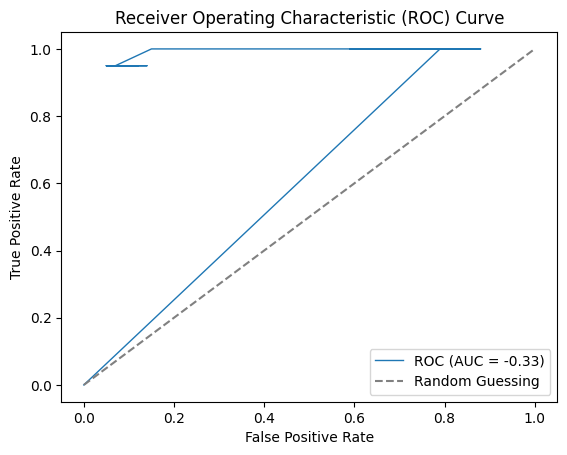

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import random
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max + 1))
    result_path_train = os.path.join(result_path,"train_{}".format(num_max + 1))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_train,exist_ok=True)
    return result_path_train


# 模型評估指標
def validation_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold_nums):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'
    plt.savefig(os.path.join(result_path,'confusion_matrix_fold'+str(fold_nums + 1)+'.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold_nums):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'
    plt.savefig(os.path.join(result_path,'Roc_curve'+str(fold_nums + 1)+'.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(result_path,parameter,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold_nums):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(result_path, 'csv_record')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(result_path + '/csv_record/epoch_fold'+str(fold_nums + 1)+'.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time','num_fold'])
        writer.writerow(parameter)
        writer.writerow('')
        writer.writerow(['Epoch','train_loss','train_acc','val_loss','val_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(train_loss_list[epoch], 4),
                            round(train_acc_list[epoch].item(), 4),
                            round(val_loss_list[epoch], 4),
                            round(val_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong_predict:',fold_wrong_predict])
    print('CSV output Sucessfully')

def print_filename_in_txt(train_loader, valid_loader, result_path, fold_num):
    # Initialize empty lists to store filenames
    train_filenames = []
    valid_filenames = []

    # Iterate over the training dataset
    for batch_idx, (data, target, filename) in enumerate(train_loader):
        # Append the filename to the list
        train_filenames.extend(filename)

    # Iterate over the validation dataset
    for batch_idx, (data, target, filename) in enumerate(valid_loader):
        # Append the filename to the list
        valid_filenames.extend(filename)

    # Create the 'file_name_record' directory if it doesn't exist
    file_record_dir = os.path.join(result_path, 'file_name_record')
    if not os.path.exists(file_record_dir):
        os.makedirs(file_record_dir)

    # Save the training filenames as a text file
    with open(result_path + '/file_name_record/train_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in train_filenames:
            file.write(filename + '\n')

    # Save the validation filenames as a text file
    with open(result_path + '/file_name_record/valid_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in valid_filenames:
            file.write(filename + '\n')

    print(f"Filenames saved in {result_path}/train_filenames.txt and {result_path}/valid_filenames.txt")

def calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, fold_nums, result_path):
    # Calculate averages
    avg_train_acc = sum(avg_train_acc_list) / fold_nums
    avg_val_acc = sum(avg_val_acc_list) / fold_nums
    avg_recall = sum(avg_recall_list) / fold_nums
    avg_precision = sum(avg_precision_list) / fold_nums
    avg_f1_score = sum(avg_f1_score_list) / fold_nums
    avg_TPR = sum(avg_TPR_list) / fold_nums
    avg_FPR = sum(avg_FPR_list) / fold_nums

    # Save averages to a text file
    with open(result_path + '/Average.txt', 'w') as file:
        file.write(f"Avg Train Accuracy: {avg_train_acc}\n")
        file.write(f"Avg Validation Accuracy: {avg_val_acc}\n")
        file.write(f"Avg Recall: {avg_recall}\n")
        file.write(f"Avg Precision: {avg_precision}\n")
        file.write(f"Avg F1 Score: {avg_f1_score}\n")
        file.write(f"Avg TPR: {avg_TPR}\n")
        file.write(f"Avg FPR: {avg_FPR}\n")

    print(f"Averages saved to {result_path}")

def train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,num_fold):
    #超參數設定
    batch_size = 52
    learning_rate = 0.001
    num_epochs = 30
    num_classes = 2
    num_folds = num_fold
    start_time = datetime.now()
    end_time = 0
    num_argumentation = 20
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    train_normal_dataset = MyDataset(train_normal_tensor_path)
    train_abnormal_dataset = MyDataset(train_abnormal_tensor_path)
    # Combine the datasets
    train_datasets = CombinedDataset(train_normal_dataset,train_abnormal_dataset)

    # Create the k-fold cross-validation object
    kfold = KFold(n_splits=num_folds)

    #印出資料集大小
    print("train dataset's size : " + str(len(train_datasets)))

    #創建模型
    model = models.resnet152(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    # make dir to save the training outcome
    result_path = mkdir_outcome(result_path)

    avg_train_acc_list = []
    avg_val_acc_list = []
    avg_recall_list = []
    avg_precision_list = []
    avg_f1_score_list = []
    avg_TPR_list = []
    avg_FPR_list = []

    files = []
    file_names = os.listdir(normal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    file_names = os.listdir(abnormal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    random.shuffle(files)

    torch.save(model.state_dict(),os.path.join(result_path,"resnet152_pre_train.pt"))

    for fold, (train_indices, valid_indices) in enumerate(kfold.split(files)):
        print(f"Fold: {fold+1}")

        #定義損失函數和優化器
        m = nn.Sigmoid()
        criterion = nn.BCELoss()
        # criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        recall_list = []
        precision_list = []
        f1_score_list = []
        TPR_list = []
        FPR_list = []
        fold_wrong_predict = []

        train_files = [files[i] for i in train_indices]
        valid_files = [files[i] for i in valid_indices]

        # 定義用於儲存訓練集和驗證集的檔案名稱的列表
        train_data_files = []
        valid_data_files = []

        # 尋找所有訓練集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in train_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              # 將增強後資料的檔案名稱新增至訓練集檔案名稱列表
              train_data_files.append(augmented_file)

        # 尋找所有驗證集資料檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in valid_files:
            labels, index = file.split('_')
            # 建構增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              valid_data_files.append(augmented_file)

        train = []
        valid = []

        # 尋找所有combined_dataset中的樣本索引
        for index, (data, labels, filename) in enumerate(train_datasets):
            # 檢查目前樣本的檔案名稱是否在訓練集檔案名稱清單中
            if filename in train_data_files:
                train.append(index)
            # 檢查目前樣本的檔案名稱是否在驗證集檔案名稱清單中
            elif filename in valid_data_files:
                valid.append(index)

        # Create the train and validation datasets for this fold
        train_dataset = torch.utils.data.Subset(train_datasets, train)
        valid_dataset = torch.utils.data.Subset(train_datasets, valid)


        print("train_dataset : " + str(len(train_dataset)),",valid_dataset : " + str(len(valid_dataset)))

        # Create the data loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4)
        print_filename_in_txt(train_loader,valid_loader,result_path,fold)

        #訓練模型
        for epoch in range(num_epochs):

            train_loss = 0
            train_correct = 0
            train_acc = 0
            val_loss = 0
            val_corrects = 0
            val_acc = 0

            print("result_path:" + str(result_path))

            if(epoch == 0) :
              model.load_state_dict(torch.load(os.path.join(result_path,"resnet152_pre_train.pt")))
              print("Model initialized")
            else :
              model.load_state_dict(torch.load(os.path.join(result_path,"train_fold"+f'{fold+1}'+".pt")))
              print("Model loaded")


            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Training Progress]: ")
            model.train()
            for inputs, labels, filename in tqdm(train_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(m(outputs),targets.float())
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_correct.double() / len(train_loader.dataset)
            train_loss_list.append(train_loss)

            model.eval()

            print("[Validating Progress]: ")
            wrong_predict = []
            for inputs, labels, filename in tqdm(valid_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(m(outputs),targets.float())
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            val_loss = val_loss / len(valid_loader.dataset)
            val_acc = val_corrects.double() / len(valid_loader.dataset)
            val_loss_list.append(val_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  train_loss: {:<.4f}  -  train_accuracy: {:<.4f} -  val_loss: {:<.4f}  -  val_accuracy: {:<.4f}  -  val_correct: {:<10}'.format(
                epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, val_corrects))
            print('wrong predict : ' + str(wrong_predict))
            torch.save(model.state_dict(),os.path.join(result_path,"train_fold"+f'{fold+1}'+".pt"))
            print("Model saved")

            # validation index (評估指標)
            precision,recall,f1_score,TPR,FPR = validation_index(conf_matrix)

            # record the outcomes
            val_acc_list.append(val_acc),train_acc_list.append(train_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              avg_train_acc_list.append(train_acc),avg_val_acc_list.append(val_acc),avg_recall_list.append(recall),avg_precision_list.append(precision),avg_f1_score_list.append(f1_score),avg_TPR_list.append(TPR),avg_FPR_list.append(FPR),fold_wrong_predict.append(wrong_predict)

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(result_path,conf_matrix,fold)
        # functioN to show ROC curve
        ROC_Curve(result_path,TPR_list,FPR_list,fold)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time,fold]
        CSV_Output(result_path,param,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold)

    #calculate the average
    calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, num_folds, result_path)

    torch.cuda.empty_cache()


normal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
abnormal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result'

train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,5)

#訓練及驗證模型(SEResNet)

In [ ]:
!pip install timm

train dataset's size : 660
Device used : cuda
Fold: 1
train_dataset : 520 ,valid_dataset : 140


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/valid_filenames.txt
epoch:1
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model initialized
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:12<00:00, 11.63it/s]



Epoch: [1/50]  train_loss: 0.2715  -  train_accuracy: 0.8712 -  val_loss: 3.6324  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_6_aug10.pt',), ('normal_6_aug7.pt',), ('normal_6_aug3.pt',), ('normal_6_aug18.pt',), ('normal_6_aug4.pt',), ('normal_6_aug17.pt',), ('normal_6_aug1.pt',), ('normal_6_aug8.pt',), ('normal_6_aug9.pt',), ('normal_6_aug20.pt',), ('normal_6_aug15.pt',), ('normal_6_aug2.pt',), ('normal_6_aug19.pt',), ('normal_6_aug14.pt',), ('normal_6_aug5.pt',), ('normal_6_aug13.pt',), ('normal_6_aug12.pt',), ('normal_6_aug11.pt',), ('normal_6_aug16.pt',), ('normal_6_aug6.pt',), ('normal_11_aug9.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.6500  -  F1 Score: 0.7879
epoch:2
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.78it/s]



Epoch: [2/50]  train_loss: 0.0076  -  train_accuracy: 0.9981 -  val_loss: 1.0427  -  val_accuracy: 0.9643  -  val_correct: 135       
wrong predict : [('abnormal_3_aug2.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug19.pt',), ('normal_6_aug1.pt',), ('normal_6_aug5.pt',)]
Model saved
	      Precision: 0.9661  -  Recall: 0.9500  -  F1 Score: 0.9580
epoch:3
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.52it/s]



Epoch: [3/50]  train_loss: 0.0023  -  train_accuracy: 1.0000 -  val_loss: 0.4018  -  val_accuracy: 0.9000  -  val_correct: 126       
wrong predict : [('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug16.pt',)]
Model saved
	      Precision: 0.8286  -  Recall: 0.9667  -  F1 Score: 0.8923
epoch:4
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.75it/s]



Epoch: [4/50]  train_loss: 0.0873  -  train_accuracy: 0.9865 -  val_loss: 1.9740  -  val_accuracy: 0.8429  -  val_correct: 118       
wrong predict : [('normal_11_aug11.pt',), ('normal_11_aug13.pt',), ('normal_11_aug14.pt',), ('normal_11_aug4.pt',), ('normal_11_aug9.pt',), ('normal_11_aug6.pt',), ('normal_6_aug1.pt',), ('normal_11_aug3.pt',), ('normal_11_aug17.pt',), ('normal_6_aug16.pt',), ('normal_6_aug8.pt',), ('normal_11_aug10.pt',), ('normal_6_aug5.pt',), ('normal_11_aug16.pt',), ('normal_11_aug20.pt',), ('normal_11_aug19.pt',), ('normal_11_aug1.pt',), ('normal_11_aug8.pt',), ('normal_11_aug18.pt',), ('normal_11_aug5.pt',), ('normal_11_aug7.pt',), ('normal_11_aug2.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.6333  -  F1 Score: 0.7755
epoch:5
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.64it/s]



Epoch: [5/50]  train_loss: 0.1134  -  train_accuracy: 0.9769 -  val_loss: 8.3541  -  val_accuracy: 0.7000  -  val_correct: 98        
wrong predict : [('normal_6_aug5.pt',), ('normal_6_aug13.pt',), ('normal_6_aug15.pt',), ('normal_13_aug11.pt',), ('normal_6_aug1.pt',), ('normal_11_aug16.pt',), ('normal_6_aug12.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug10.pt',), ('normal_6_aug19.pt',), ('normal_6_aug6.pt',), ('normal_11_aug9.pt',), ('normal_11_aug10.pt',), ('normal_6_aug18.pt',), ('normal_13_aug16.pt',), ('normal_6_aug8.pt',), ('normal_13_aug15.pt',), ('normal_13_aug6.pt',), ('normal_6_aug20.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug14.pt',), ('normal_6_aug17.pt',), ('normal_13_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug1.pt',), ('normal_13_aug10.pt',), ('normal_6_aug3.pt',), ('normal_6_aug11.pt',), ('normal_6_aug9.pt',), ('normal_11_aug5.pt',), ('normal_13_aug4.pt',), ('abnormal_3_aug16.pt',), ('normal_13_aug3.pt',), ('normal_13_aug12.pt',),

100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.24it/s]



Epoch: [6/50]  train_loss: 0.0129  -  train_accuracy: 0.9981 -  val_loss: 0.7274  -  val_accuracy: 0.7714  -  val_correct: 108       
wrong predict : [('normal_6_aug13.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug3.pt',), ('normal_6_aug20.pt',), ('normal_6_aug2.pt',), ('normal_6_aug14.pt',), ('normal_6_aug10.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug9.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug12.pt',), ('normal_6_aug18.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug10.pt',)]
Model saved
	      Precision: 0.7121  -  Recall: 0.7833  

100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.98it/s]



Epoch: [7/50]  train_loss: 0.0057  -  train_accuracy: 1.0000 -  val_loss: 0.6426  -  val_accuracy: 0.8143  -  val_correct: 114       
wrong predict : [('abnormal_3_aug6.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug4.pt',), ('normal_6_aug6.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug7.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug20.pt',), ('normal_6_aug2.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',)]
Model saved
	      Precision: 0.7361  -  Recall: 0.8833  -  F1 Score: 0.8030
epoch:8
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.00it/s]



Epoch: [8/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 0.6100  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('normal_6_aug6.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug12.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:9
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.68it/s]



Epoch: [9/50]  train_loss: 0.0035  -  train_accuracy: 1.0000 -  val_loss: 0.6115  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug15.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug19.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug7.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:10
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.69it/s]



Epoch: [10/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6633  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug4.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug19.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:11
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.12it/s]



Epoch: [11/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6618  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug6.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug9.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:12
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.10it/s]



Epoch: [12/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6720  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug12.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug8.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:13
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.05it/s]



Epoch: [13/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6851  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug13.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug6.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:14
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.01it/s]



Epoch: [14/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6576  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug7.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug2.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug19.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:15
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.01it/s]



Epoch: [15/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6596  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug2.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:16
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.15it/s]



Epoch: [16/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6701  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('normal_6_aug6.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug19.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:17
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.69it/s]



Epoch: [17/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.6719  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug1.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug4.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug18.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:18
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.17it/s]



Epoch: [18/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6776  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug9.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:19
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.67it/s]



Epoch: [19/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6592  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug13.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug4.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug2.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:20
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.76it/s]



Epoch: [20/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.6785  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug12.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug20.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:21
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.12it/s]



Epoch: [21/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.6668  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug16.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug13.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:22
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.04it/s]



Epoch: [22/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.6683  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug20.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:23
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.62it/s]



Epoch: [23/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.6897  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug1.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug10.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:24
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.30it/s]



Epoch: [24/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6695  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('normal_6_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:25
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.61it/s]



Epoch: [25/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6791  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:26
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.54it/s]



Epoch: [26/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.6528  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug6.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug13.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:27
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.49it/s]



Epoch: [27/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.6892  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug19.pt',), ('normal_6_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:28
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.81it/s]



Epoch: [28/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.6889  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug19.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug20.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:29
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.07it/s]



Epoch: [29/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6767  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug11.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug7.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug6.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:30
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.40it/s]



Epoch: [30/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6787  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug20.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug16.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:31
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.12it/s]



Epoch: [31/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6797  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug17.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug1.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug4.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug11.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:32
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.75it/s]



Epoch: [32/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.6821  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug12.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug19.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug20.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug2.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:33
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.45it/s]



Epoch: [33/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6821  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug11.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:34
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.22it/s]



Epoch: [34/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6642  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug12.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug2.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:35
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.68it/s]



Epoch: [35/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.6867  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug19.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug7.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug4.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug3.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:36
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.77it/s]



Epoch: [36/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6833  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug19.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug2.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug7.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:37
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.24it/s]



Epoch: [37/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.6694  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug8.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug20.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug2.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug1.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:38
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.63it/s]



Epoch: [38/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6640  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:39
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.46it/s]



Epoch: [39/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6619  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug9.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug4.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:40
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.43it/s]



Epoch: [40/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6693  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('abnormal_3_aug16.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug20.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:41
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.40it/s]



Epoch: [41/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.6669  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug19.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug7.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug20.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:42
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.91it/s]



Epoch: [42/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.6662  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug9.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug4.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug5.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug3.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:43
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.00it/s]



Epoch: [43/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6722  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug15.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug4.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug2.pt',), ('normal_6_aug18.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug16.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug17.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:44
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.55it/s]



Epoch: [44/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.6742  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug19.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug10.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug3.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:45
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.99it/s]



Epoch: [45/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6775  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug19.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug15.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug7.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:46
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.77it/s]



Epoch: [46/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.6700  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug4.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug13.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug11.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:47
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.91it/s]



Epoch: [47/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6586  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug13.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug18.pt',), ('normal_6_aug4.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug6.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug17.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug3.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:48
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.21it/s]



Epoch: [48/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.6716  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('abnormal_3_aug18.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug3.pt',), ('normal_6_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug4.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug9.pt',), ('normal_6_aug4.pt',)]
Model saved
	      Precision: 0.7432  -  Recall: 0.9167  -  F1 Score: 0.8209
epoch:49
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.67it/s]



Epoch: [49/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.6704  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug7.pt',), ('normal_6_aug4.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug8.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug6.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug9.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug12.pt',), ('abnormal_3_aug19.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug1.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
epoch:50
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.08it/s]



Epoch: [50/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.6957  -  val_accuracy: 0.8357  -  val_correct: 117       
wrong predict : [('normal_6_aug4.pt',), ('abnormal_3_aug2.pt',), ('abnormal_3_aug10.pt',), ('abnormal_3_aug12.pt',), ('normal_6_aug6.pt',), ('abnormal_3_aug17.pt',), ('abnormal_3_aug1.pt',), ('abnormal_3_aug20.pt',), ('abnormal_3_aug11.pt',), ('normal_6_aug7.pt',), ('abnormal_3_aug8.pt',), ('abnormal_3_aug18.pt',), ('abnormal_3_aug15.pt',), ('abnormal_3_aug6.pt',), ('normal_6_aug19.pt',), ('abnormal_3_aug4.pt',), ('abnormal_3_aug5.pt',), ('abnormal_3_aug7.pt',), ('abnormal_3_aug3.pt',), ('abnormal_3_aug13.pt',), ('abnormal_3_aug19.pt',), ('abnormal_3_aug16.pt',), ('abnormal_3_aug9.pt',)]
Model saved
	      Precision: 0.7467  -  Recall: 0.9333  -  F1 Score: 0.8296
Confusion matrix:
[[56 19]
 [ 4 61]]
CSV output Sucessfully
Fold: 2
train_dataset : 520 ,valid_dataset : 140
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/tra

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.93it/s]



Epoch: [1/50]  train_loss: 0.2604  -  train_accuracy: 0.8904 -  val_loss: 0.1310  -  val_accuracy: 0.9429  -  val_correct: 132       
wrong predict : [('abnormal_14_aug11.pt',), ('abnormal_8_aug14.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug7.pt',), ('abnormal_8_aug20.pt',), ('abnormal_8_aug7.pt',), ('abnormal_14_aug13.pt',), ('abnormal_8_aug1.pt',)]
Model saved
	      Precision: 0.7143  -  Recall: 1.0000  -  F1 Score: 0.8333
epoch:2
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.63it/s]



Epoch: [2/50]  train_loss: 0.0285  -  train_accuracy: 0.9923 -  val_loss: 0.9926  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_9_aug20.pt',), ('abnormal_23_aug10.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug16.pt',), ('abnormal_8_aug11.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug20.pt',)]
Model saved
	      Precision: 0.5000  -  Recall: 0.9500  -  F1 Score: 0.6552
epoch:3
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.21it/s]



Epoch: [3/50]  train_loss: 0.0115  -  train_accuracy: 0.9981 -  val_loss: 0.2492  -  val_accuracy: 0.9286  -  val_correct: 130       
wrong predict : [('abnormal_14_aug3.pt',), ('abnormal_14_aug4.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug2.pt',)]
Model saved
	      Precision: 0.6667  -  Recall: 1.0000  -  F1 Score: 0.8000
epoch:4
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.10it/s]



Epoch: [4/50]  train_loss: 0.0436  -  train_accuracy: 0.9962 -  val_loss: 0.0045  -  val_accuracy: 1.0000  -  val_correct: 140       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:5
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.61it/s]



Epoch: [5/50]  train_loss: 0.0163  -  train_accuracy: 0.9962 -  val_loss: 1.1937  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug16.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('normal_9_aug6.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug10.pt',), ('normal_9_aug14.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.5143  -  Recall: 0.9000  -  F1 Score: 0.6545
epoch:6
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.92it/s]



Epoch: [6/50]  train_loss: 0.0031  -  train_accuracy: 1.0000 -  val_loss: 0.8007  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug14.pt',), ('normal_9_aug14.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',), ('normal_9_aug6.pt',)]
Model saved
	      Precision: 0.5143  -  Recall: 0.9000  -  F1 Score: 0.6545
epoch:7
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.67it/s]



Epoch: [7/50]  train_loss: 0.0061  -  train_accuracy: 0.9981 -  val_loss: 0.8284  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('abnormal_14_aug12.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug14.pt',), ('normal_9_aug6.pt',), ('abnormal_14_aug7.pt',), ('normal_9_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug11.pt',)]
Model saved
	      Precision: 0.5000  -  Recall: 0.9000  -  F1 Score: 0.6429
epoch:8
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.34it/s]



Epoch: [8/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.8244  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug3.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:9
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.00it/s]



Epoch: [9/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.7898  -  val_accuracy: 0.8714  -  val_correct: 122       
wrong predict : [('abnormal_14_aug12.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug20.pt',)]
Model saved
	      Precision: 0.5263  -  Recall: 1.0000  -  F1 Score: 0.6897
epoch:10
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.05it/s]



Epoch: [10/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7743  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug7.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug20.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:11
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.22it/s]



Epoch: [11/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.7885  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug12.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug2.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:12
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.70it/s]



Epoch: [12/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8366  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug2.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug10.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:13
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.72it/s]



Epoch: [13/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8515  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug5.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug15.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:14
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.75it/s]



Epoch: [14/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8349  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug2.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:15
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.38it/s]



Epoch: [15/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8021  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug20.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug12.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:16
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.63it/s]



Epoch: [16/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8188  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug3.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:17
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.48it/s]



Epoch: [17/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7905  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug1.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug16.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:18
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.62it/s]



Epoch: [18/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7977  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug11.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:19
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.39it/s]



Epoch: [19/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7771  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug16.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug1.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:20
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.82it/s]



Epoch: [20/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7782  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug19.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:21
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.45it/s]



Epoch: [21/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8336  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug19.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug15.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:22
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 23.29it/s]



Epoch: [22/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7971  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug13.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:23
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.17it/s]



Epoch: [23/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7956  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug1.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug3.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:24
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.33it/s]



Epoch: [24/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8311  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug8.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug5.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:25
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.67it/s]



Epoch: [25/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.7937  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug7.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:26
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.45it/s]



Epoch: [26/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8163  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug3.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:27
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.14it/s]



Epoch: [27/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8172  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug15.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug6.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:28
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.45it/s]



Epoch: [28/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8013  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug20.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug9.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:29
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.61it/s]



Epoch: [29/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8209  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug8.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:30
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.04it/s]



Epoch: [30/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.7900  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug10.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug1.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:31
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.82it/s]



Epoch: [31/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7899  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug11.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:32
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.99it/s]



Epoch: [32/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7984  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug16.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:33
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.47it/s]



Epoch: [33/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.8049  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug20.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug11.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:34
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.94it/s]



Epoch: [34/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8259  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug12.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:35
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.25it/s]



Epoch: [35/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7948  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug15.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug1.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:36
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.35it/s]



Epoch: [36/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7926  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug11.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:37
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.92it/s]



Epoch: [37/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7905  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug16.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug9.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:38
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.75it/s]



Epoch: [38/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8074  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug5.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:39
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.45it/s]



Epoch: [39/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8578  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug17.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:40
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.79it/s]



Epoch: [40/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8174  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:41
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.13it/s]



Epoch: [41/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.7709  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug13.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug16.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:42
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.25it/s]



Epoch: [42/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8123  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug2.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug20.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:43
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.92it/s]



Epoch: [43/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.8498  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug13.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:44
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.17it/s]



Epoch: [44/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8167  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug10.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug2.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:45
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.57it/s]



Epoch: [45/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8200  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug9.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:46
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.58it/s]



Epoch: [46/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8255  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug5.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug1.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:47
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.80it/s]



Epoch: [47/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8247  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug11.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug7.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:48
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.52it/s]



Epoch: [48/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8232  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug14.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug16.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug2.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:49
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.52it/s]



Epoch: [49/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.7903  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug16.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug19.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug13.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
epoch:50
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.44it/s]



Epoch: [50/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.8080  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('abnormal_14_aug19.pt',), ('abnormal_14_aug17.pt',), ('abnormal_14_aug12.pt',), ('abnormal_14_aug2.pt',), ('abnormal_14_aug11.pt',), ('abnormal_14_aug7.pt',), ('abnormal_14_aug6.pt',), ('abnormal_14_aug20.pt',), ('abnormal_14_aug18.pt',), ('abnormal_14_aug9.pt',), ('abnormal_14_aug13.pt',), ('abnormal_14_aug15.pt',), ('abnormal_14_aug1.pt',), ('abnormal_14_aug8.pt',), ('abnormal_14_aug3.pt',), ('abnormal_14_aug10.pt',), ('abnormal_14_aug5.pt',), ('abnormal_14_aug14.pt',), ('abnormal_14_aug16.pt',)]
Model saved
	      Precision: 0.5128  -  Recall: 1.0000  -  F1 Score: 0.6780
Confusion matrix:
[[ 20  19]
 [  0 101]]
CSV output Sucessfully
Fold: 3
train_dataset : 520 ,valid_dataset : 140
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result/resu

100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.73it/s]



Epoch: [1/50]  train_loss: 0.2661  -  train_accuracy: 0.8769 -  val_loss: 2.7916  -  val_accuracy: 0.7143  -  val_correct: 100       
wrong predict : [('normal_7_aug2.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',), ('normal_3_aug7.pt',), ('normal_3_aug1.pt',), ('normal_7_aug1.pt',), ('normal_3_aug8.pt',), ('normal_7_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug16.pt',), ('normal_7_aug17.pt',), ('normal_7_aug5.pt',), ('normal_7_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_7_aug11.pt',), ('normal_7_aug15.pt',), ('normal_7_aug18.pt',), ('normal_3_aug2.pt',), ('normal_7_aug9.pt',), ('normal_3_aug12.pt',), ('normal_7_aug13.pt',), ('normal_3_aug19.pt',), ('normal_3_aug20.pt',), ('normal_7_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug4.pt',), ('normal_7_aug3.pt',), ('normal_7_aug19.pt',), ('normal_7_aug8.pt',), ('normal_3_aug13.pt',), ('normal_7_aug4.pt',), ('normal_7_aug7.pt',), (

100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.59it/s]



Epoch: [2/50]  train_loss: 0.0512  -  train_accuracy: 0.9865 -  val_loss: 8.6974  -  val_accuracy: 0.8286  -  val_correct: 116       
wrong predict : [('normal_3_aug6.pt',), ('normal_3_aug8.pt',), ('normal_3_aug1.pt',), ('normal_7_aug8.pt',), ('normal_3_aug3.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug9.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_7_aug19.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_7_aug3.pt',), ('normal_7_aug2.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug11.pt',), ('normal_3_aug10.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4000  -  F1 Score: 0.5714
epoch:3
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.93it/s]



Epoch: [3/50]  train_loss: 0.0230  -  train_accuracy: 0.9942 -  val_loss: 0.3314  -  val_accuracy: 0.8857  -  val_correct: 124       
wrong predict : [('normal_3_aug11.pt',), ('normal_3_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug14.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('abnormal_15_aug17.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug18.pt',), ('abnormal_15_aug4.pt',), ('abnormal_15_aug6.pt',)]
Model saved
	      Precision: 0.9000  -  Recall: 0.6750  -  F1 Score: 0.7714
epoch:4
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.56it/s]



Epoch: [4/50]  train_loss: 0.0101  -  train_accuracy: 0.9981 -  val_loss: 0.9924  -  val_accuracy: 0.8643  -  val_correct: 121       
wrong predict : [('normal_3_aug19.pt',), ('normal_3_aug1.pt',), ('normal_3_aug15.pt',), ('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug11.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug5.pt',), ('normal_3_aug20.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug2.pt',), ('normal_3_aug7.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug12.pt',), ('normal_3_aug8.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5250  -  F1 Score: 0.6885
epoch:5
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.57it/s]



Epoch: [5/50]  train_loss: 0.0100  -  train_accuracy: 0.9942 -  val_loss: 0.8420  -  val_accuracy: 0.7500  -  val_correct: 105       
wrong predict : [('abnormal_15_aug2.pt',), ('abnormal_32_aug8.pt',), ('abnormal_15_aug1.pt',), ('normal_3_aug4.pt',), ('abnormal_15_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug15.pt',), ('normal_3_aug2.pt',), ('normal_3_aug13.pt',), ('abnormal_32_aug9.pt',), ('abnormal_15_aug8.pt',), ('abnormal_15_aug3.pt',), ('normal_3_aug14.pt',), ('abnormal_15_aug9.pt',), ('abnormal_15_aug4.pt',), ('abnormal_15_aug18.pt',), ('normal_3_aug19.pt',), ('abnormal_15_aug17.pt',), ('abnormal_15_aug19.pt',), ('abnormal_32_aug10.pt',), ('abnormal_15_aug10.pt',), ('abnormal_15_aug5.pt',), ('normal_3_aug1.pt',), ('abnormal_15_aug6.pt',), ('normal_3_aug17.pt',), ('abnormal_32_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_3_aug12.pt',), ('abnormal_32_aug3.pt',), ('normal_3_aug16.pt',), ('abnormal_15_aug16.pt',), ('normal_3_aug6.pt',), ('abnormal_15_au

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.93it/s]



Epoch: [6/50]  train_loss: 0.0123  -  train_accuracy: 0.9942 -  val_loss: 0.9591  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug3.pt',), ('normal_3_aug9.pt',), ('normal_3_aug5.pt',), ('normal_3_aug8.pt',), ('normal_3_aug19.pt',), ('normal_3_aug1.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug18.pt',), ('normal_3_aug20.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug17.pt',), ('normal_3_aug14.pt',), ('normal_3_aug2.pt',), ('normal_3_aug13.pt',), ('normal_3_aug15.pt',), ('normal_3_aug7.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:7
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.70it/s]



Epoch: [7/50]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 0.8819  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug14.pt',), ('normal_3_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_7_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug11.pt',), ('normal_3_aug17.pt',), ('normal_3_aug9.pt',), ('normal_3_aug2.pt',), ('normal_3_aug5.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug19.pt',), ('normal_3_aug3.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:8
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.65it/s]



Epoch: [8/50]  train_loss: 0.0056  -  train_accuracy: 0.9981 -  val_loss: 0.8692  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug18.pt',), ('normal_3_aug5.pt',), ('normal_7_aug15.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug8.pt',), ('normal_3_aug19.pt',), ('normal_3_aug14.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug16.pt',), ('normal_3_aug2.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:9
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.41it/s]



Epoch: [9/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.8436  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug19.pt',), ('normal_3_aug8.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_7_aug15.pt',), ('normal_3_aug1.pt',), ('normal_3_aug14.pt',), ('normal_3_aug4.pt',), ('normal_3_aug10.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:10
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.81it/s]



Epoch: [10/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.8763  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug17.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug20.pt',), ('normal_3_aug2.pt',), ('normal_3_aug10.pt',), ('normal_3_aug16.pt',), ('normal_3_aug7.pt',), ('normal_3_aug19.pt',), ('normal_3_aug12.pt',), ('normal_3_aug18.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug13.pt',), ('normal_3_aug9.pt',), ('normal_3_aug5.pt',), ('normal_3_aug3.pt',), ('normal_7_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:11
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.50it/s]



Epoch: [11/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8895  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug20.pt',), ('normal_3_aug14.pt',), ('normal_3_aug8.pt',), ('normal_3_aug15.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug5.pt',), ('normal_3_aug11.pt',), ('normal_3_aug1.pt',), ('normal_3_aug7.pt',), ('normal_3_aug9.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug4.pt',), ('normal_3_aug18.pt',), ('normal_3_aug16.pt',), ('normal_3_aug19.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:12
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.03it/s]



Epoch: [12/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.9078  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug8.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug16.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug3.pt',), ('normal_3_aug13.pt',), ('normal_3_aug15.pt',), ('normal_3_aug2.pt',), ('normal_3_aug11.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_3_aug12.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug7.pt',), ('normal_3_aug18.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:13
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.86it/s]



Epoch: [13/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.8877  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug9.pt',), ('normal_3_aug2.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',), ('normal_3_aug17.pt',), ('normal_3_aug8.pt',), ('normal_3_aug16.pt',), ('normal_3_aug4.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_3_aug10.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug1.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:14
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.56it/s]



Epoch: [14/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8991  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug19.pt',), ('normal_3_aug13.pt',), ('normal_3_aug15.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug4.pt',), ('normal_3_aug17.pt',), ('normal_3_aug11.pt',), ('normal_3_aug14.pt',), ('normal_3_aug2.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug8.pt',), ('normal_3_aug12.pt',), ('normal_3_aug18.pt',), ('normal_3_aug16.pt',), ('normal_3_aug1.pt',), ('normal_3_aug9.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:15
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.70it/s]



Epoch: [15/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8972  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug9.pt',), ('normal_3_aug5.pt',), ('normal_3_aug16.pt',), ('normal_3_aug4.pt',), ('normal_3_aug7.pt',), ('normal_3_aug14.pt',), ('normal_3_aug8.pt',), ('normal_3_aug15.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug10.pt',), ('normal_3_aug13.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug17.pt',), ('normal_3_aug1.pt',), ('normal_3_aug3.pt',), ('normal_3_aug18.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:16
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.93it/s]



Epoch: [16/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9154  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug19.pt',), ('normal_3_aug16.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug2.pt',), ('normal_3_aug10.pt',), ('normal_3_aug15.pt',), ('normal_3_aug5.pt',), ('normal_3_aug6.pt',), ('normal_3_aug9.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug8.pt',), ('normal_3_aug14.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug3.pt',), ('normal_3_aug20.pt',), ('normal_7_aug15.pt',), ('normal_3_aug7.pt',), ('normal_3_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:17
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.50it/s]



Epoch: [17/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9014  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug7.pt',), ('normal_3_aug15.pt',), ('normal_3_aug5.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug3.pt',), ('normal_3_aug20.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug8.pt',), ('normal_3_aug19.pt',), ('normal_3_aug14.pt',), ('normal_3_aug12.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:18
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.63it/s]



Epoch: [18/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9114  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_3_aug6.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug10.pt',), ('normal_3_aug2.pt',), ('normal_3_aug8.pt',), ('normal_3_aug7.pt',), ('normal_3_aug20.pt',), ('normal_3_aug1.pt',), ('normal_3_aug4.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug12.pt',), ('normal_3_aug16.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_3_aug18.pt',), ('normal_3_aug19.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:19
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.71it/s]



Epoch: [19/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9244  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug20.pt',), ('normal_3_aug14.pt',), ('normal_3_aug9.pt',), ('normal_3_aug6.pt',), ('normal_3_aug5.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug8.pt',), ('normal_3_aug7.pt',), ('normal_3_aug16.pt',), ('normal_7_aug15.pt',), ('normal_3_aug11.pt',), ('normal_3_aug2.pt',), ('normal_3_aug10.pt',), ('normal_3_aug1.pt',), ('normal_3_aug19.pt',), ('normal_3_aug15.pt',), ('normal_3_aug17.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:20
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.33it/s]



Epoch: [20/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9385  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug7.pt',), ('normal_3_aug16.pt',), ('normal_3_aug19.pt',), ('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug17.pt',), ('normal_3_aug15.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug8.pt',), ('normal_3_aug6.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug2.pt',), ('normal_3_aug1.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:21
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.73it/s]



Epoch: [21/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8912  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug1.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug20.pt',), ('normal_3_aug4.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug9.pt',), ('normal_3_aug14.pt',), ('normal_3_aug7.pt',), ('normal_3_aug8.pt',), ('normal_3_aug5.pt',), ('normal_3_aug2.pt',), ('normal_3_aug16.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:22
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.59it/s]



Epoch: [22/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9102  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug15.pt',), ('normal_3_aug8.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug14.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug18.pt',), ('normal_3_aug9.pt',), ('normal_3_aug3.pt',), ('normal_3_aug20.pt',), ('normal_3_aug6.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:23
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.45it/s]



Epoch: [23/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8794  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug1.pt',), ('normal_3_aug19.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug8.pt',), ('normal_3_aug4.pt',), ('normal_3_aug3.pt',), ('normal_3_aug7.pt',), ('normal_3_aug11.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_3_aug20.pt',), ('normal_3_aug14.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug6.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:24
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 22.55it/s]



Epoch: [24/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.9164  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug18.pt',), ('normal_3_aug10.pt',), ('normal_3_aug19.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_3_aug14.pt',), ('normal_3_aug7.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',), ('normal_3_aug4.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:25
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.92it/s]



Epoch: [25/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9211  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug5.pt',), ('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_3_aug13.pt',), ('normal_3_aug8.pt',), ('normal_3_aug18.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug2.pt',), ('normal_3_aug6.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug12.pt',), ('normal_3_aug14.pt',), ('normal_3_aug1.pt',), ('normal_3_aug3.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:26
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.38it/s]



Epoch: [26/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9000  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug8.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug2.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_3_aug10.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug7.pt',), ('normal_3_aug1.pt',), ('normal_3_aug9.pt',), ('normal_3_aug16.pt',), ('normal_3_aug3.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug17.pt',), ('normal_3_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:27
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.43it/s]



Epoch: [27/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9178  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug10.pt',), ('normal_3_aug11.pt',), ('normal_3_aug6.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug5.pt',), ('normal_3_aug14.pt',), ('normal_3_aug3.pt',), ('normal_3_aug8.pt',), ('normal_3_aug17.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:28
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.47it/s]



Epoch: [28/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 0.9513  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug1.pt',), ('normal_3_aug20.pt',), ('normal_3_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug2.pt',), ('normal_3_aug18.pt',), ('normal_3_aug13.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug19.pt',), ('normal_3_aug15.pt',), ('normal_3_aug6.pt',), ('normal_3_aug8.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:29
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.51it/s]



Epoch: [29/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9070  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug14.pt',), ('normal_3_aug5.pt',), ('normal_3_aug17.pt',), ('normal_3_aug9.pt',), ('normal_3_aug20.pt',), ('normal_3_aug18.pt',), ('normal_3_aug8.pt',), ('normal_3_aug6.pt',), ('normal_3_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug10.pt',), ('normal_3_aug12.pt',), ('normal_3_aug19.pt',), ('normal_3_aug15.pt',), ('normal_3_aug2.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:30
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.73it/s]



Epoch: [30/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.8970  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug8.pt',), ('normal_3_aug2.pt',), ('normal_3_aug4.pt',), ('normal_3_aug16.pt',), ('normal_3_aug10.pt',), ('normal_3_aug17.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug9.pt',), ('normal_3_aug18.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug12.pt',), ('normal_3_aug11.pt',), ('normal_3_aug3.pt',), ('normal_3_aug7.pt',), ('normal_3_aug13.pt',), ('normal_3_aug19.pt',), ('normal_3_aug1.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:31
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.99it/s]



Epoch: [31/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9118  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug2.pt',), ('normal_3_aug17.pt',), ('normal_3_aug6.pt',), ('normal_3_aug9.pt',), ('normal_3_aug16.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',), ('normal_3_aug19.pt',), ('normal_3_aug13.pt',), ('normal_3_aug8.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug18.pt',), ('normal_3_aug4.pt',), ('normal_3_aug11.pt',), ('normal_3_aug10.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:32
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 20.51it/s]



Epoch: [32/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9059  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug17.pt',), ('normal_3_aug20.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug19.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug6.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug13.pt',), ('normal_3_aug9.pt',), ('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug14.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:33
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 24.04it/s]



Epoch: [33/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.9269  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug12.pt',), ('normal_3_aug15.pt',), ('normal_3_aug18.pt',), ('normal_3_aug6.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug10.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug2.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_3_aug13.pt',), ('normal_3_aug16.pt',), ('normal_3_aug3.pt',), ('normal_3_aug1.pt',), ('normal_3_aug14.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:34
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.60it/s]



Epoch: [34/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.9346  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug8.pt',), ('normal_3_aug20.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug19.pt',), ('normal_3_aug10.pt',), ('normal_3_aug12.pt',), ('normal_3_aug5.pt',), ('normal_3_aug14.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug9.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:35
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.76it/s]



Epoch: [35/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9634  -  val_accuracy: 0.8500  -  val_correct: 119       
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug17.pt',), ('normal_3_aug15.pt',), ('normal_3_aug8.pt',), ('normal_3_aug10.pt',), ('normal_3_aug4.pt',), ('normal_3_aug19.pt',), ('normal_3_aug9.pt',), ('normal_3_aug12.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug20.pt',), ('normal_7_aug15.pt',), ('normal_3_aug1.pt',), ('normal_3_aug13.pt',), ('normal_3_aug11.pt',), ('normal_3_aug5.pt',), ('normal_3_aug7.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.4750  -  F1 Score: 0.6441
epoch:36
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.14it/s]



Epoch: [36/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9297  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug2.pt',), ('normal_3_aug15.pt',), ('normal_3_aug16.pt',), ('normal_3_aug11.pt',), ('normal_3_aug14.pt',), ('normal_3_aug3.pt',), ('normal_3_aug5.pt',), ('normal_3_aug12.pt',), ('normal_3_aug10.pt',), ('normal_3_aug7.pt',), ('normal_3_aug20.pt',), ('normal_3_aug18.pt',), ('normal_3_aug8.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug9.pt',), ('normal_3_aug17.pt',), ('normal_3_aug4.pt',), ('normal_3_aug1.pt',), ('normal_3_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:37
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.18it/s]



Epoch: [37/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9096  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug5.pt',), ('normal_3_aug8.pt',), ('normal_3_aug16.pt',), ('normal_3_aug3.pt',), ('normal_3_aug4.pt',), ('normal_3_aug9.pt',), ('normal_3_aug1.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug17.pt',), ('normal_3_aug10.pt',), ('normal_3_aug11.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug12.pt',), ('normal_3_aug14.pt',), ('normal_3_aug2.pt',), ('normal_3_aug19.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:38
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.86it/s]



Epoch: [38/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.9097  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug1.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug18.pt',), ('normal_3_aug14.pt',), ('normal_3_aug16.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_3_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_3_aug2.pt',), ('normal_3_aug4.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:39
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:04<00:00, 28.26it/s]



Epoch: [39/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.9145  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug3.pt',), ('normal_3_aug15.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug6.pt',), ('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug5.pt',), ('normal_3_aug10.pt',), ('normal_3_aug1.pt',), ('normal_3_aug8.pt',), ('normal_3_aug18.pt',), ('normal_3_aug13.pt',), ('normal_3_aug19.pt',), ('normal_3_aug7.pt',), ('normal_3_aug14.pt',), ('normal_3_aug12.pt',), ('normal_3_aug4.pt',), ('normal_3_aug11.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:40
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 23.97it/s]



Epoch: [40/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9300  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug15.pt',), ('normal_3_aug1.pt',), ('normal_3_aug11.pt',), ('normal_3_aug10.pt',), ('normal_3_aug2.pt',), ('normal_3_aug3.pt',), ('normal_3_aug9.pt',), ('normal_3_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug18.pt',), ('normal_3_aug14.pt',), ('normal_3_aug16.pt',), ('normal_3_aug17.pt',), ('normal_3_aug8.pt',), ('normal_3_aug20.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:41
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.66it/s]



Epoch: [41/50]  train_loss: 0.0002  -  train_accuracy: 1.0000 -  val_loss: 0.9029  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug2.pt',), ('normal_3_aug9.pt',), ('normal_3_aug10.pt',), ('normal_3_aug8.pt',), ('normal_3_aug4.pt',), ('normal_3_aug12.pt',), ('normal_3_aug16.pt',), ('normal_3_aug19.pt',), ('normal_3_aug14.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug13.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug5.pt',), ('normal_3_aug1.pt',), ('normal_3_aug7.pt',), ('normal_3_aug3.pt',), ('normal_3_aug18.pt',), ('normal_3_aug11.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:42
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.24it/s]



Epoch: [42/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9015  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug4.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_3_aug8.pt',), ('normal_3_aug7.pt',), ('normal_3_aug9.pt',), ('normal_3_aug19.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',), ('normal_3_aug12.pt',), ('normal_3_aug6.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_3_aug16.pt',), ('normal_3_aug2.pt',), ('normal_3_aug17.pt',), ('normal_3_aug20.pt',), ('normal_3_aug18.pt',), ('normal_3_aug10.pt',), ('normal_3_aug1.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:43
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.23it/s]



Epoch: [43/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8933  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug5.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug8.pt',), ('normal_3_aug1.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug12.pt',), ('normal_3_aug9.pt',), ('normal_3_aug3.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_3_aug11.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug2.pt',), ('normal_3_aug16.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:44
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 27.28it/s]



Epoch: [44/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9090  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug9.pt',), ('normal_3_aug4.pt',), ('normal_3_aug19.pt',), ('normal_3_aug1.pt',), ('normal_3_aug2.pt',), ('normal_3_aug16.pt',), ('normal_3_aug8.pt',), ('normal_3_aug20.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug10.pt',), ('normal_3_aug18.pt',), ('normal_3_aug7.pt',), ('normal_3_aug5.pt',), ('normal_3_aug14.pt',), ('normal_3_aug17.pt',), ('normal_3_aug12.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_3_aug15.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:45
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 25.12it/s]



Epoch: [45/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.8793  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug18.pt',), ('normal_3_aug17.pt',), ('normal_3_aug16.pt',), ('normal_3_aug3.pt',), ('normal_3_aug14.pt',), ('normal_3_aug10.pt',), ('normal_3_aug6.pt',), ('normal_3_aug4.pt',), ('normal_3_aug13.pt',), ('normal_3_aug5.pt',), ('normal_3_aug15.pt',), ('normal_3_aug12.pt',), ('normal_3_aug8.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug7.pt',), ('normal_3_aug9.pt',), ('normal_3_aug19.pt',), ('normal_3_aug2.pt',), ('normal_3_aug1.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:46
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.24it/s]



Epoch: [46/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.8828  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug8.pt',), ('normal_3_aug11.pt',), ('normal_3_aug9.pt',), ('normal_3_aug1.pt',), ('normal_3_aug10.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug20.pt',), ('normal_3_aug17.pt',), ('normal_3_aug7.pt',), ('normal_3_aug15.pt',), ('normal_3_aug3.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug19.pt',), ('normal_3_aug5.pt',), ('normal_3_aug2.pt',), ('normal_3_aug4.pt',), ('normal_3_aug14.pt',), ('normal_3_aug12.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:47
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.34it/s]



Epoch: [47/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9113  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug11.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_3_aug9.pt',), ('normal_3_aug3.pt',), ('normal_3_aug7.pt',), ('normal_3_aug2.pt',), ('normal_3_aug13.pt',), ('normal_3_aug16.pt',), ('normal_3_aug6.pt',), ('normal_3_aug10.pt',), ('normal_3_aug20.pt',), ('normal_3_aug1.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug19.pt',), ('normal_3_aug18.pt',), ('normal_3_aug17.pt',), ('normal_3_aug8.pt',), ('normal_3_aug12.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:48
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.07it/s]



Epoch: [48/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9263  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug1.pt',), ('normal_3_aug16.pt',), ('normal_3_aug14.pt',), ('normal_3_aug18.pt',), ('normal_3_aug9.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug12.pt',), ('normal_3_aug7.pt',), ('normal_3_aug8.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_3_aug10.pt',), ('normal_3_aug2.pt',), ('normal_3_aug4.pt',), ('normal_3_aug15.pt',), ('normal_3_aug3.pt',), ('normal_3_aug17.pt',), ('normal_3_aug5.pt',), ('normal_3_aug13.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:49
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:06<00:00, 21.35it/s]



Epoch: [49/50]  train_loss: 0.0003  -  train_accuracy: 1.0000 -  val_loss: 0.9181  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug16.pt',), ('normal_3_aug13.pt',), ('normal_3_aug18.pt',), ('normal_3_aug10.pt',), ('normal_3_aug20.pt',), ('normal_3_aug14.pt',), ('normal_3_aug15.pt',), ('normal_3_aug4.pt',), ('normal_3_aug7.pt',), ('normal_3_aug8.pt',), ('normal_3_aug2.pt',), ('normal_3_aug12.pt',), ('normal_3_aug9.pt',), ('normal_3_aug3.pt',), ('normal_3_aug11.pt',), ('normal_3_aug19.pt',), ('normal_3_aug6.pt',), ('normal_3_aug1.pt',), ('normal_3_aug17.pt',), ('normal_3_aug5.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
epoch:50
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


[Validating Progress]: 


100%|██████████| 140/140 [00:05<00:00, 26.10it/s]



Epoch: [50/50]  train_loss: 0.0004  -  train_accuracy: 1.0000 -  val_loss: 0.9381  -  val_accuracy: 0.8571  -  val_correct: 120       
wrong predict : [('normal_3_aug17.pt',), ('normal_3_aug3.pt',), ('normal_3_aug10.pt',), ('normal_3_aug13.pt',), ('normal_3_aug6.pt',), ('normal_3_aug9.pt',), ('normal_3_aug16.pt',), ('normal_3_aug18.pt',), ('normal_3_aug1.pt',), ('normal_3_aug15.pt',), ('normal_3_aug14.pt',), ('normal_3_aug19.pt',), ('normal_3_aug5.pt',), ('normal_3_aug4.pt',), ('normal_3_aug7.pt',), ('normal_3_aug12.pt',), ('normal_3_aug2.pt',), ('normal_3_aug11.pt',), ('normal_3_aug20.pt',), ('normal_3_aug8.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.5000  -  F1 Score: 0.6667
Confusion matrix:
[[ 20   0]
 [ 20 100]]
CSV output Sucessfully
Fold: 4
train_dataset : 540 ,valid_dataset : 120
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/valid_filenames.txt
e

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.67it/s]



Epoch: [1/50]  train_loss: 0.2425  -  train_accuracy: 0.9074 -  val_loss: 0.3715  -  val_accuracy: 0.8667  -  val_correct: 104       
wrong predict : [('normal_8_aug18.pt',), ('normal_8_aug16.pt',), ('normal_8_aug3.pt',), ('normal_8_aug9.pt',), ('normal_8_aug10.pt',), ('normal_8_aug15.pt',), ('normal_8_aug1.pt',), ('normal_8_aug7.pt',), ('normal_8_aug8.pt',), ('normal_8_aug19.pt',), ('normal_8_aug5.pt',), ('normal_8_aug20.pt',), ('normal_8_aug2.pt',), ('normal_8_aug4.pt',), ('normal_8_aug11.pt',), ('normal_8_aug14.pt',)]
Model saved
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
epoch:2
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.80it/s]



Epoch: [2/50]  train_loss: 0.0665  -  train_accuracy: 0.9778 -  val_loss: 0.8194  -  val_accuracy: 0.8083  -  val_correct: 97        
wrong predict : [('abnormal_21_aug4.pt',), ('abnormal_21_aug12.pt',), ('abnormal_21_aug16.pt',), ('abnormal_21_aug13.pt',), ('abnormal_18_aug16.pt',), ('abnormal_21_aug3.pt',), ('abnormal_21_aug1.pt',), ('abnormal_21_aug2.pt',), ('abnormal_21_aug8.pt',), ('abnormal_18_aug7.pt',), ('abnormal_21_aug18.pt',), ('abnormal_18_aug1.pt',), ('abnormal_21_aug20.pt',), ('abnormal_21_aug19.pt',), ('abnormal_18_aug12.pt',), ('normal_8_aug8.pt',), ('abnormal_18_aug14.pt',), ('abnormal_21_aug11.pt',), ('abnormal_21_aug7.pt',), ('abnormal_21_aug9.pt',), ('abnormal_18_aug15.pt',), ('abnormal_21_aug15.pt',), ('abnormal_21_aug6.pt',)]
Model saved
	      Precision: 0.4634  -  Recall: 0.9500  -  F1 Score: 0.6230
epoch:3
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.01it/s]



Epoch: [3/50]  train_loss: 0.0117  -  train_accuracy: 1.0000 -  val_loss: 0.0395  -  val_accuracy: 0.9833  -  val_correct: 118       
wrong predict : [('abnormal_18_aug17.pt',), ('abnormal_18_aug16.pt',)]
Model saved
	      Precision: 0.9091  -  Recall: 1.0000  -  F1 Score: 0.9524
epoch:4
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.47s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.24it/s]



Epoch: [4/50]  train_loss: 0.0152  -  train_accuracy: 0.9944 -  val_loss: 0.2645  -  val_accuracy: 0.8917  -  val_correct: 107       
wrong predict : [('abnormal_21_aug14.pt',), ('abnormal_12_aug4.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug20.pt',), ('abnormal_12_aug3.pt',), ('abnormal_12_aug11.pt',), ('abnormal_12_aug9.pt',), ('abnormal_21_aug5.pt',), ('abnormal_12_aug13.pt',), ('abnormal_12_aug17.pt',), ('abnormal_21_aug16.pt',), ('abnormal_12_aug5.pt',), ('abnormal_12_aug8.pt',)]
Model saved
	      Precision: 0.6061  -  Recall: 1.0000  -  F1 Score: 0.7547
epoch:5
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.93it/s]



Epoch: [5/50]  train_loss: 0.0753  -  train_accuracy: 0.9778 -  val_loss: 2.4287  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('abnormal_18_aug9.pt',), ('abnormal_12_aug15.pt',), ('abnormal_12_aug7.pt',), ('abnormal_12_aug17.pt',), ('abnormal_18_aug7.pt',), ('abnormal_21_aug11.pt',), ('abnormal_18_aug10.pt',), ('abnormal_12_aug5.pt',), ('abnormal_18_aug14.pt',), ('abnormal_12_aug14.pt',), ('abnormal_21_aug16.pt',), ('abnormal_12_aug13.pt',), ('abnormal_21_aug9.pt',), ('abnormal_12_aug2.pt',), ('abnormal_18_aug16.pt',), ('abnormal_18_aug1.pt',), ('abnormal_12_aug4.pt',), ('abnormal_18_aug15.pt',), ('abnormal_21_aug14.pt',), ('abnormal_21_aug15.pt',), ('abnormal_21_aug7.pt',), ('abnormal_21_aug6.pt',), ('abnormal_21_aug1.pt',), ('abnormal_21_aug2.pt',), ('abnormal_18_aug2.pt',), ('abnormal_21_aug19.pt',), ('abnormal_21_aug13.pt',), ('abnormal_12_aug10.pt',), ('abnormal_21_aug5.pt',), ('abnormal_12_aug12.pt',), ('abnormal_18_aug3.pt',), ('abnormal_21_aug20.pt',),

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.96it/s]



Epoch: [6/50]  train_loss: 0.0355  -  train_accuracy: 0.9963 -  val_loss: 0.0307  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:7
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.80it/s]



Epoch: [7/50]  train_loss: 0.0043  -  train_accuracy: 1.0000 -  val_loss: 0.0814  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:8
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.12it/s]



Epoch: [8/50]  train_loss: 0.0021  -  train_accuracy: 1.0000 -  val_loss: 0.1262  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:9
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.59it/s]



Epoch: [9/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 0.1077  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:10
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.81it/s]



Epoch: [10/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.1110  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:11
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.81it/s]



Epoch: [11/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1045  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:12
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.81it/s]



Epoch: [12/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1041  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:13
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.67it/s]



Epoch: [13/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.0965  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:14
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.69it/s]



Epoch: [14/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.0996  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:15
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.34it/s]



Epoch: [15/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1073  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:16
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.21it/s]



Epoch: [16/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.0988  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:17
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.26it/s]



Epoch: [17/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1087  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:18
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.50it/s]



Epoch: [18/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.1147  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:19
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.15it/s]



Epoch: [19/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1096  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:20
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.74it/s]



Epoch: [20/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1075  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:21
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.65it/s]



Epoch: [21/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1029  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:22
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.02it/s]



Epoch: [22/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1040  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:23
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.05it/s]



Epoch: [23/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.1037  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:24
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.68it/s]



Epoch: [24/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1106  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:25
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.60it/s]



Epoch: [25/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1024  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:26
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.28it/s]



Epoch: [26/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.1107  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:27
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.74it/s]



Epoch: [27/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1177  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:28
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.82it/s]



Epoch: [28/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1124  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:29
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.70it/s]



Epoch: [29/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.0996  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:30
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.82it/s]



Epoch: [30/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.1135  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:31
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.88it/s]



Epoch: [31/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1154  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:32
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.89it/s]



Epoch: [32/50]  train_loss: 0.0040  -  train_accuracy: 0.9981 -  val_loss: 0.1087  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:33
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.60it/s]



Epoch: [33/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.1333  -  val_accuracy: 0.9917  -  val_correct: 119       
wrong predict : [('abnormal_21_aug2.pt',)]
Model saved
	      Precision: 0.9524  -  Recall: 1.0000  -  F1 Score: 0.9756
epoch:34
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.73it/s]



Epoch: [34/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1074  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:35
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.10it/s]



Epoch: [35/50]  train_loss: 0.0005  -  train_accuracy: 1.0000 -  val_loss: 0.1108  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:36
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.83it/s]



Epoch: [36/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1220  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:37
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.00it/s]



Epoch: [37/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1120  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:38
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.62it/s]



Epoch: [38/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.1057  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:39
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.90it/s]



Epoch: [39/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1038  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:40
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.58it/s]



Epoch: [40/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.1154  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:41
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.98it/s]



Epoch: [41/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1101  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:42
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.84it/s]



Epoch: [42/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.1006  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:43
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.62it/s]



Epoch: [43/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.0886  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:44
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.25it/s]



Epoch: [44/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.1024  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:45
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.60it/s]



Epoch: [45/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.1124  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:46
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.54it/s]



Epoch: [46/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.1055  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:47
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.89it/s]



Epoch: [47/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.1161  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:48
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:06<00:00, 18.96it/s]



Epoch: [48/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.1021  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
epoch:49
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.41it/s]



Epoch: [49/50]  train_loss: 0.0016  -  train_accuracy: 1.0000 -  val_loss: 0.1306  -  val_accuracy: 0.9917  -  val_correct: 119       
wrong predict : [('abnormal_21_aug2.pt',)]
Model saved
	      Precision: 0.9524  -  Recall: 1.0000  -  F1 Score: 0.9756
epoch:50
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model loaded
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.07it/s]



Epoch: [50/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.1064  -  val_accuracy: 1.0000  -  val_correct: 120       
wrong predict : []
Model saved
	      Precision: 1.0000  -  Recall: 1.0000  -  F1 Score: 1.0000
Confusion matrix:
[[ 20   0]
 [  0 100]]
CSV output Sucessfully
Fold: 5
train_dataset : 540 ,valid_dataset : 120
Filenames saved in /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/train_filenames.txt and /content/drive/My Drive/Deep_X_torch/result/result_1/train_1/valid_filenames.txt
epoch:1
result_path:/content/drive/My Drive/Deep_X_torch/result/result_1/train_1
Model initialized
[Training Progress]: 


100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.29it/s]



Epoch: [1/50]  train_loss: 0.2467  -  train_accuracy: 0.8870 -  val_loss: 10.4459  -  val_accuracy: 0.3833  -  val_correct: 46        
wrong predict : [('normal_14_aug8.pt',), ('normal_14_aug14.pt',), ('normal_2_aug1.pt',), ('normal_12_aug11.pt',), ('normal_14_aug13.pt',), ('normal_16_aug18.pt',), ('normal_16_aug8.pt',), ('normal_16_aug2.pt',), ('normal_12_aug8.pt',), ('normal_12_aug4.pt',), ('normal_2_aug20.pt',), ('normal_14_aug17.pt',), ('normal_2_aug2.pt',), ('normal_2_aug16.pt',), ('normal_12_aug16.pt',), ('normal_16_aug14.pt',), ('normal_12_aug3.pt',), ('normal_16_aug12.pt',), ('normal_2_aug11.pt',), ('normal_16_aug20.pt',), ('normal_2_aug9.pt',), ('normal_16_aug10.pt',), ('normal_14_aug7.pt',), ('normal_16_aug19.pt',), ('normal_12_aug15.pt',), ('normal_12_aug2.pt',), ('normal_16_aug4.pt',), ('normal_16_aug11.pt',), ('normal_12_aug20.pt',), ('normal_2_aug3.pt',), ('normal_16_aug5.pt',), ('normal_14_aug1.pt',), ('normal_2_aug12.pt',), ('normal_2_aug4.pt',), ('normal_12_aug13.pt',

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.10it/s]



Epoch: [2/50]  train_loss: 0.0122  -  train_accuracy: 0.9981 -  val_loss: 11.8169  -  val_accuracy: 0.6250  -  val_correct: 75        
wrong predict : [('normal_14_aug11.pt',), ('normal_14_aug5.pt',), ('normal_14_aug12.pt',), ('normal_16_aug10.pt',), ('normal_12_aug10.pt',), ('normal_14_aug20.pt',), ('normal_12_aug19.pt',), ('normal_12_aug16.pt',), ('normal_12_aug18.pt',), ('normal_12_aug1.pt',), ('normal_14_aug16.pt',), ('normal_14_aug6.pt',), ('normal_16_aug15.pt',), ('normal_14_aug2.pt',), ('normal_14_aug4.pt',), ('normal_12_aug11.pt',), ('normal_14_aug8.pt',), ('normal_14_aug3.pt',), ('normal_12_aug8.pt',), ('normal_14_aug13.pt',), ('normal_12_aug12.pt',), ('normal_12_aug2.pt',), ('normal_12_aug3.pt',), ('normal_12_aug4.pt',), ('normal_12_aug14.pt',), ('normal_16_aug1.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('normal_12_aug6.pt',), ('normal_14_aug18.pt',), ('normal_12_aug13.pt',), ('normal_12_aug20.pt',), ('normal_14_aug7.pt',), ('normal_14_aug14.pt',), ('normal_12_a

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:06<00:00, 19.20it/s]



Epoch: [3/50]  train_loss: 0.0538  -  train_accuracy: 0.9870 -  val_loss: 31.0175  -  val_accuracy: 0.3083  -  val_correct: 37        
wrong predict : [('normal_16_aug8.pt',), ('normal_14_aug6.pt',), ('normal_16_aug13.pt',), ('normal_14_aug20.pt',), ('normal_2_aug6.pt',), ('normal_16_aug3.pt',), ('normal_2_aug20.pt',), ('normal_14_aug4.pt',), ('normal_16_aug6.pt',), ('normal_2_aug4.pt',), ('normal_14_aug18.pt',), ('normal_16_aug7.pt',), ('normal_2_aug9.pt',), ('normal_14_aug5.pt',), ('normal_14_aug17.pt',), ('normal_12_aug1.pt',), ('normal_14_aug14.pt',), ('normal_16_aug5.pt',), ('normal_16_aug12.pt',), ('normal_16_aug14.pt',), ('normal_12_aug3.pt',), ('abnormal_1_aug20.pt',), ('normal_16_aug1.pt',), ('normal_12_aug5.pt',), ('normal_16_aug11.pt',), ('normal_12_aug19.pt',), ('normal_12_aug8.pt',), ('normal_12_aug20.pt',), ('normal_2_aug11.pt',), ('normal_14_aug13.pt',), ('normal_12_aug11.pt',), ('normal_2_aug18.pt',), ('normal_12_aug2.pt',), ('normal_12_aug12.pt',), ('normal_14_aug3.pt

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.57it/s]



Epoch: [4/50]  train_loss: 0.0158  -  train_accuracy: 0.9981 -  val_loss: 5.9514  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_5_aug10.pt',), ('abnormal_1_aug18.pt',), ('abnormal_1_aug4.pt',), ('normal_14_aug8.pt',), ('abnormal_5_aug1.pt',), ('abnormal_1_aug19.pt',), ('abnormal_5_aug19.pt',), ('abnormal_1_aug13.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug20.pt',), ('abnormal_1_aug14.pt',), ('abnormal_1_aug10.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug17.pt',), ('abnormal_1_aug16.pt',), ('abnormal_1_aug2.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug8.pt',), ('abnormal_1_aug1.pt',), ('abnormal_5_aug6.pt',), ('abnormal_1_aug8.pt',), ('abnormal_1_aug17.pt',), ('abnormal_1_aug5.pt',), ('abnormal_1_aug9.pt',), ('normal_12_aug18.pt',), ('abnormal_1_aug15.pt',), ('abnormal_5_aug14.pt',), ('abnormal_1_aug12.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug5.pt',), ('abnormal_1_aug3.pt',), ('abnormal_1_aug11.pt',), ('abnormal_1_aug6.pt',), ('abno

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.07it/s]



Epoch: [5/50]  train_loss: 0.0748  -  train_accuracy: 0.9852 -  val_loss: 2.7879  -  val_accuracy: 0.6500  -  val_correct: 78        
wrong predict : [('abnormal_5_aug8.pt',), ('normal_16_aug10.pt',), ('normal_16_aug11.pt',), ('normal_16_aug2.pt',), ('normal_14_aug16.pt',), ('normal_2_aug10.pt',), ('normal_2_aug5.pt',), ('normal_14_aug3.pt',), ('normal_16_aug20.pt',), ('normal_14_aug2.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug20.pt',), ('normal_12_aug3.pt',), ('normal_16_aug6.pt',), ('normal_14_aug13.pt',), ('normal_2_aug7.pt',), ('normal_12_aug2.pt',), ('normal_16_aug15.pt',), ('normal_14_aug5.pt',), ('normal_2_aug14.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug9.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug10.pt',), ('normal_2_aug12.pt',), ('normal_14_aug1.pt',), ('normal_2_aug13.pt',), ('normal_14_aug14.pt',), ('normal_12_aug16.pt',), ('normal_14_aug6.pt',), ('normal_16_aug13.pt',), ('normal_14_aug8.pt',), ('normal_12_aug8.pt',), ('normal_14_aug1

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.98it/s]



Epoch: [6/50]  train_loss: 0.0201  -  train_accuracy: 0.9963 -  val_loss: 0.7301  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_5_aug19.pt',), ('normal_16_aug6.pt',), ('normal_16_aug20.pt',), ('normal_14_aug10.pt',), ('normal_16_aug19.pt',), ('normal_14_aug2.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug7.pt',), ('normal_16_aug10.pt',), ('normal_14_aug3.pt',), ('normal_14_aug7.pt',), ('normal_12_aug4.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug1.pt',), ('normal_14_aug15.pt',), ('normal_16_aug2.pt',), ('normal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_14_aug12.pt',), ('normal_14_aug9.pt',), ('normal_12_aug3.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug4.pt',), ('normal_14_aug14.pt',), ('normal_16_aug13.pt',), ('normal_16_aug15.pt',), ('normal_16_aug11.pt',), ('normal_14_aug16.pt',), ('normal_12_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug8.pt',)]
Model sa

100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.65it/s]



Epoch: [7/50]  train_loss: 0.0085  -  train_accuracy: 1.0000 -  val_loss: 0.8119  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_16_aug20.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug9.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug1.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug8.pt',), ('normal_16_aug10.pt',), ('normal_14_aug6.pt',), ('normal_14_aug19.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug10.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug17.pt',), ('normal_14_aug2.pt',), ('normal_14_aug5.pt',), ('normal_14_aug15.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug3.pt',), ('normal_16_aug15.pt',), ('normal_14_aug4.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug20.pt',), ('normal_16_aug13.pt',), 

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.35it/s]



Epoch: [8/50]  train_loss: 0.0048  -  train_accuracy: 0.9981 -  val_loss: 0.8709  -  val_accuracy: 0.6833  -  val_correct: 82        
wrong predict : [('abnormal_5_aug17.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug7.pt',), ('normal_16_aug10.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug5.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug6.pt',), ('normal_16_aug15.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug3.pt',), ('normal_12_aug2.pt',), ('normal_14_aug9.pt',), ('normal_14_aug2.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug19.pt',), ('normal_16_aug13.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug1.pt',), ('normal_14_aug20.pt',), ('normal_14_aug16.pt',), ('normal_14_aug4.pt',), ('normal_14_aug19.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug13.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug3.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.37it/s]



Epoch: [9/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.8706  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug20.pt',), ('normal_14_aug4.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug1.pt',), ('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug6.pt',), ('normal_14_aug5.pt',), ('normal_16_aug13.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug17.pt',), ('normal_16_aug10.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug16.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug19.pt',), ('normal_14_aug3.pt',), ('normal_14_aug13.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug19.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.07it/s]



Epoch: [10/50]  train_loss: 0.0017  -  train_accuracy: 1.0000 -  val_loss: 0.9242  -  val_accuracy: 0.6833  -  val_correct: 82        
wrong predict : [('normal_14_aug2.pt',), ('normal_14_aug15.pt',), ('normal_16_aug10.pt',), ('normal_14_aug7.pt',), ('normal_14_aug9.pt',), ('normal_14_aug16.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug1.pt',), ('abnormal_1_aug20.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug13.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug15.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug12.pt',), ('normal_12_aug2.pt',), ('normal_14_aug19.pt',), ('normal_14_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug10.pt'

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.28it/s]



Epoch: [11/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9481  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug3.pt',), ('normal_14_aug4.pt',), ('normal_12_aug2.pt',), ('normal_14_aug13.pt',), ('normal_14_aug2.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug17.pt',), ('normal_16_aug1.pt',), ('normal_16_aug20.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug20.pt',), ('normal_14_aug1.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug15.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug16.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug14.pt',

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 27.18it/s]



Epoch: [12/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.9254  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug1.pt',), ('normal_14_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug4.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug5.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug16.pt',), ('normal_14_aug6.pt',), ('normal_14_aug7.pt',), ('normal_14_aug10.pt',), ('normal_14_aug13.pt',), ('normal_14_aug14.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug17.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug4.pt',), ('normal_14_aug3.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug7.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.50it/s]



Epoch: [13/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.8721  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_14_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug12.pt',), ('normal_16_aug20.pt',), ('normal_14_aug13.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug6.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug1.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug7.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug19.pt',), ('normal_12_aug2.pt',), ('normal_14_aug1.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug10.pt',), ('normal_14_aug16.pt',), ('normal_14_aug5.pt',), ('normal_14_aug2.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.36it/s]



Epoch: [14/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.9224  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug4.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug5.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug19.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug17.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug14.pt',), ('normal_14_aug19.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug15.pt',), ('normal_14_aug13.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug1.pt',

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.64it/s]



Epoch: [15/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.9537  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug15.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug10.pt',), ('normal_14_aug16.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug5.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug1.pt',), ('normal_14_aug2.pt',), ('normal_14_aug17.pt',), ('normal_14_aug12.pt',), ('normal_14_aug14.pt',), ('normal_14_aug13.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug18.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug8.pt',), ('normal_16_aug1.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug7.pt',), ('normal_14_aug9.pt',), ('normal_16_aug10.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.87it/s]



Epoch: [16/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.9976  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_14_aug16.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug19.pt',), ('normal_16_aug20.pt',), ('normal_14_aug4.pt',), ('normal_14_aug12.pt',), ('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('normal_14_aug20.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug3.pt',), ('normal_14_aug14.pt',), ('normal_16_aug1.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug1.pt',), ('normal_16_aug15.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug12.pt',), ('normal_16_aug10.pt',), ('normal_14_aug13.pt',), ('normal_14_aug7.pt',), ('normal_16_aug13.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug6.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug15.pt',), ('normal_14_aug5.pt',), 

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.00it/s]



Epoch: [17/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.9069  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug14.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug3.pt',), ('normal_14_aug12.pt',), ('normal_14_aug13.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug17.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug6.pt',), ('normal_12_aug2.pt',), ('normal_14_aug4.pt',), ('normal_14_aug20.pt',), ('normal_14_aug16.pt',), ('normal_14_aug1.pt',), ('normal_14_aug17.pt',), ('normal_14_aug10.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug4.pt',), ('normal_16_aug1.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug19.pt',), ('normal_16_aug10.pt',), ('normal_14_aug7.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.58it/s]



Epoch: [18/50]  train_loss: 0.0021  -  train_accuracy: 0.9981 -  val_loss: 0.9448  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug14.pt',), ('normal_14_aug12.pt',), ('normal_14_aug16.pt',), ('normal_14_aug15.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug10.pt',), ('normal_12_aug2.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug4.pt',), ('normal_16_aug10.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug12.pt',), ('normal_16_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug5.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug20.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.21it/s]



Epoch: [19/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9067  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug4.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug12.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug20.pt',), ('normal_16_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug2.pt',), ('normal_14_aug6.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug19.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug10.pt',), ('normal_16_aug1.pt',), ('normal_14_aug15.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug7.pt',), ('abnormal_1_aug20.pt',), ('normal_16_aug10.pt',), ('normal_14_aug17.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug9.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug14.pt',

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.28it/s]



Epoch: [20/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.8979  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug13.pt',), ('normal_14_aug9.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug16.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug12.pt',), ('normal_16_aug20.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug10.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug19.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug15.pt',), ('normal_14_aug10.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.85it/s]



Epoch: [21/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.9213  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug10.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug7.pt',), ('normal_14_aug17.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug19.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug5.pt',), ('normal_14_aug13.pt',), ('normal_14_aug9.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug15.pt',), ('normal_14_aug1.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug12.pt',), ('normal_16_aug1.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug6.pt',

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.28it/s]



Epoch: [22/50]  train_loss: 0.0014  -  train_accuracy: 1.0000 -  val_loss: 0.9512  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_5_aug4.pt',), ('abnormal_5_aug20.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug16.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug6.pt',), ('normal_12_aug2.pt',), ('normal_14_aug2.pt',), ('normal_14_aug5.pt',), ('normal_14_aug20.pt',), ('normal_14_aug4.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug13.pt',), ('normal_14_aug17.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug9.pt',), ('normal_16_aug1.pt',), ('normal_14_aug3.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug12.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug3.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.39it/s]



Epoch: [23/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.8950  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('abnormal_5_aug1.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug6.pt',), ('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug4.pt',), ('normal_14_aug15.pt',), ('normal_14_aug7.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug10.pt',), ('normal_14_aug14.pt',), ('normal_14_aug3.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug3.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug5.pt',), ('normal_12_aug2.pt',), ('normal_14_aug1.pt',), ('normal_14_aug17.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.72it/s]



Epoch: [24/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.9042  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_12_aug2.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug18.pt',), ('normal_16_aug1.pt',), ('normal_14_aug6.pt',), ('normal_14_aug10.pt',), ('normal_14_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug14.pt',), ('normal_14_aug4.pt',), ('normal_14_aug1.pt',), ('normal_14_aug17.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug3.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug12.pt',), ('normal_16_aug20.pt',), ('normal_14_aug15.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug13.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug8.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.66it/s]



Epoch: [25/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.9207  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug6.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug9.pt',), ('normal_14_aug5.pt',), ('normal_14_aug15.pt',), ('normal_14_aug6.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug17.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug18.pt',), ('normal_16_aug10.pt',), ('normal_14_aug10.pt',), ('normal_12_aug2.pt',), ('normal_14_aug12.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug8.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug14.pt',), ('normal_14_aug4.pt',), ('normal_14_aug20.pt',), ('normal_14_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_1_aug20.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.78it/s]



Epoch: [26/50]  train_loss: 0.0020  -  train_accuracy: 1.0000 -  val_loss: 0.9363  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug6.pt',), ('normal_14_aug5.pt',), ('normal_14_aug7.pt',), ('normal_16_aug1.pt',), ('normal_14_aug9.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug20.pt',), ('normal_14_aug4.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug14.pt',), ('normal_14_aug10.pt',), ('normal_14_aug17.pt',), ('normal_14_aug2.pt',), ('normal_16_aug20.pt',), ('normal_14_aug16.pt',), ('normal_14_aug3.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug4.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug19.pt',), ('normal_14_aug1.pt',),

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.01it/s]



Epoch: [27/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.9355  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug12.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug20.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug14.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug20.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug7.pt',), ('normal_16_aug20.pt',), ('normal_14_aug2.pt',), ('normal_14_aug6.pt',), ('normal_14_aug1.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug15.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug13.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug17.pt'

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.99it/s]



Epoch: [28/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.9404  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug4.pt',), ('normal_14_aug20.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug2.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('normal_14_aug3.pt',), ('normal_16_aug1.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug9.pt',), ('normal_14_aug7.pt',), ('normal_14_aug14.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug14.pt',), ('normal_12_aug2.pt',), ('normal_14_aug15.pt',), ('normal_14_aug13.pt',

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:06<00:00, 19.87it/s]



Epoch: [29/50]  train_loss: 0.0013  -  train_accuracy: 1.0000 -  val_loss: 0.9301  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_14_aug20.pt',), ('normal_14_aug16.pt',), ('normal_14_aug5.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug3.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug19.pt',), ('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug15.pt',), ('normal_14_aug13.pt',), ('normal_14_aug10.pt',), ('normal_14_aug9.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug6.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug2.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug18.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug1.pt',), ('normal_16_aug1.pt',), ('normal_14_aug6.pt',

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.50it/s]



Epoch: [30/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9298  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_14_aug17.pt',), ('normal_14_aug20.pt',), ('normal_16_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug14.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug4.pt',), ('normal_14_aug15.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug14.pt',), ('normal_14_aug10.pt',), ('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug12.pt',), ('normal_14_aug3.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug8.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug19.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug17.pt',), ('normal_16_aug1.pt',

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.37it/s]



Epoch: [31/50]  train_loss: 0.0006  -  train_accuracy: 1.0000 -  val_loss: 0.9274  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug20.pt',), ('normal_14_aug3.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug10.pt',), ('normal_16_aug20.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug7.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug15.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug8.pt',), ('normal_12_aug2.pt',), ('normal_14_aug9.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug10.pt',

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.29it/s]



Epoch: [32/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9264  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_16_aug10.pt',), ('normal_14_aug16.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug17.pt',), ('normal_12_aug2.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug15.pt',), ('normal_14_aug10.pt',), ('normal_14_aug6.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug19.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug14.pt',), ('normal_14_aug3.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug14.pt',), ('normal_16_aug1.pt',

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 22.88it/s]



Epoch: [33/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.9282  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('abnormal_5_aug1.pt',), ('normal_12_aug2.pt',), ('normal_16_aug1.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_1_aug20.pt',), ('normal_16_aug10.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug2.pt',), ('normal_14_aug6.pt',), ('normal_14_aug10.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug15.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug5.pt',), ('normal_14_aug14.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug20.pt',), ('normal_16_aug20.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.48it/s]



Epoch: [34/50]  train_loss: 0.0012  -  train_accuracy: 1.0000 -  val_loss: 0.9411  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug9.pt',), ('normal_14_aug1.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug10.pt',), ('normal_14_aug14.pt',), ('abnormal_1_aug20.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug4.pt',), ('normal_14_aug2.pt',), ('normal_12_aug2.pt',), ('normal_14_aug5.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug4.pt',), ('normal_16_aug10.pt',), ('normal_14_aug17.pt',), ('normal_16_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug20.pt',), ('normal_12_aug16.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug17.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 25.76it/s]



Epoch: [35/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.9409  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug16.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug5.pt',), ('normal_12_aug2.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug3.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug20.pt',), ('normal_14_aug2.pt',), ('normal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_14_aug9.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug3.pt',), ('normal_16_aug10.pt',), ('normal_14_aug6.pt',), ('normal_14_aug17.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug1.pt',), ('normal_14_aug14.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug16.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug15.pt',),

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.11it/s]



Epoch: [36/50]  train_loss: 0.0086  -  train_accuracy: 0.9981 -  val_loss: 0.9616  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_1_aug20.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug16.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug6.pt',), ('normal_16_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug9.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug10.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug12.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug1.pt',), ('normal_16_aug1.pt',), ('normal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug7.pt',), ('normal_14_aug16.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug3.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.00it/s]



Epoch: [37/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.9159  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_14_aug13.pt',), ('normal_12_aug2.pt',), ('normal_14_aug20.pt',), ('normal_14_aug5.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug19.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug4.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug18.pt',), ('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug9.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.87it/s]



Epoch: [38/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.8856  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_16_aug20.pt',), ('normal_14_aug20.pt',), ('normal_14_aug17.pt',), ('normal_14_aug1.pt',), ('normal_14_aug3.pt',), ('normal_14_aug4.pt',), ('normal_14_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug15.pt',), ('normal_14_aug12.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug19.pt',), ('normal_14_aug6.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug16.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug8.pt',), ('normal_12_aug2.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug9.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.57it/s]



Epoch: [39/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.9211  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('abnormal_5_aug10.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug9.pt',), ('normal_14_aug10.pt',), ('normal_14_aug15.pt',), ('normal_14_aug13.pt',), ('normal_14_aug16.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug14.pt',), ('normal_16_aug10.pt',), ('normal_16_aug13.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug8.pt',), ('normal_16_aug1.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug2.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug17.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug7.pt',), ('normal_14_aug4.pt',), ('normal_14_aug3.pt',

100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.48it/s]



Epoch: [40/50]  train_loss: 0.0011  -  train_accuracy: 1.0000 -  val_loss: 0.9188  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug20.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug14.pt',), ('normal_14_aug9.pt',), ('normal_16_aug1.pt',), ('normal_12_aug2.pt',), ('normal_16_aug20.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug13.pt',), ('normal_14_aug2.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug1.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug14.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug7.pt',), ('normal_14_aug17.pt',), ('normal_14_aug19.pt',), ('normal_14_aug5.pt',), ('normal_14_aug3.pt',), ('normal_14_aug10.pt',), ('normal_14_aug4.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.47it/s]



Epoch: [41/50]  train_loss: 0.0019  -  train_accuracy: 1.0000 -  val_loss: 0.9501  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug14.pt',), ('normal_14_aug7.pt',), ('normal_14_aug5.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug20.pt',), ('normal_14_aug2.pt',), ('normal_16_aug1.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug15.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug3.pt',), ('normal_16_aug20.pt',), ('normal_14_aug12.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug19.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug7.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug15.pt',), ('normal_14_aug14.pt',

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.12it/s]



Epoch: [42/50]  train_loss: 0.0007  -  train_accuracy: 1.0000 -  val_loss: 0.8995  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug4.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug12.pt',), ('normal_14_aug20.pt',), ('normal_14_aug10.pt',), ('normal_14_aug15.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug6.pt',), ('normal_16_aug20.pt',), ('normal_14_aug14.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug9.pt',), ('normal_14_aug16.pt',), ('normal_14_aug3.pt',), ('normal_14_aug5.pt',), ('normal_14_aug1.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug6.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug14.pt',

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.31it/s]



Epoch: [43/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.9061  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug16.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug9.pt',), ('normal_12_aug2.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug6.pt',), ('abnormal_5_aug10.pt',), ('normal_16_aug1.pt',), ('normal_14_aug15.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug1.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug14.pt',), ('normal_16_aug20.pt',), ('normal_14_aug10.pt',), ('normal_14_aug5.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug7.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug4.pt',), ('normal_14_aug13.pt',), ('normal_14_aug19.pt',), ('normal_14_aug3.pt',

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 21.72it/s]



Epoch: [44/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.9096  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('abnormal_5_aug6.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug15.pt',), ('normal_14_aug20.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug12.pt',), ('normal_14_aug13.pt',), ('normal_14_aug10.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug4.pt',), ('normal_14_aug7.pt',), ('normal_14_aug19.pt',), ('normal_16_aug10.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug14.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug19.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug3.pt',), ('normal_12_aug2.pt',), ('normal_14_aug1.pt',), ('normal_14_aug9.pt',), ('normal_14_aug2.pt'

100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 23.10it/s]



Epoch: [45/50]  train_loss: 0.0010  -  train_accuracy: 1.0000 -  val_loss: 0.9096  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('abnormal_5_aug16.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug5.pt',), ('normal_16_aug1.pt',), ('normal_12_aug2.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug17.pt',), ('normal_16_aug10.pt',), ('normal_14_aug12.pt',), ('normal_14_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug2.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug4.pt',), ('normal_14_aug15.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug13.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug19.pt',), ('normal_16_aug20.pt',), ('normal_14_aug6.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug14.pt',),

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.69it/s]



Epoch: [46/50]  train_loss: 0.0015  -  train_accuracy: 1.0000 -  val_loss: 0.9837  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_14_aug20.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug1.pt',), ('normal_12_aug2.pt',), ('normal_14_aug6.pt',), ('normal_14_aug1.pt',), ('normal_14_aug5.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug19.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug14.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug10.pt',), ('normal_14_aug17.pt',), ('normal_16_aug20.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug15.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug9.pt',), ('normal_14_aug3.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug4.pt',), ('normal_14_aug2.pt',), ('normal_16_aug1.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug20.pt',),

100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 24.60it/s]



Epoch: [47/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.9531  -  val_accuracy: 0.7083  -  val_correct: 85        
wrong predict : [('normal_14_aug13.pt',), ('normal_14_aug16.pt',), ('normal_14_aug2.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug7.pt',), ('normal_16_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug14.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug6.pt',), ('normal_14_aug5.pt',), ('normal_14_aug19.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug14.pt',), ('normal_16_aug10.pt',), ('normal_12_aug2.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug3.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug18.pt',), ('abnormal_5_aug6.pt',), ('normal_16_aug1.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug4.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug4.pt',), ('normal_14_aug15.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.49s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:05<00:00, 20.74it/s]



Epoch: [48/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.9655  -  val_accuracy: 0.7000  -  val_correct: 84        
wrong predict : [('normal_16_aug13.pt',), ('normal_14_aug20.pt',), ('normal_14_aug1.pt',), ('normal_14_aug19.pt',), ('normal_14_aug3.pt',), ('normal_14_aug16.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug16.pt',), ('normal_12_aug2.pt',), ('normal_14_aug5.pt',), ('normal_16_aug10.pt',), ('abnormal_5_aug8.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug6.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug17.pt',), ('abnormal_5_aug10.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug12.pt',), ('normal_14_aug15.pt',), ('normal_14_aug2.pt',), ('normal_14_aug9.pt',), ('normal_16_aug1.pt',), ('normal_16_aug20.pt',), ('normal_14_aug14.pt',), ('normal_14_aug4.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug3.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug13.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.27it/s]



Epoch: [49/50]  train_loss: 0.0008  -  train_accuracy: 1.0000 -  val_loss: 0.9125  -  val_accuracy: 0.7167  -  val_correct: 86        
wrong predict : [('normal_14_aug14.pt',), ('normal_16_aug1.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug19.pt',), ('normal_14_aug3.pt',), ('abnormal_5_aug12.pt',), ('abnormal_1_aug20.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug20.pt',), ('abnormal_5_aug3.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug16.pt',), ('normal_14_aug6.pt',), ('normal_14_aug17.pt',), ('abnormal_5_aug1.pt',), ('normal_14_aug2.pt',), ('normal_14_aug9.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug10.pt',), ('normal_14_aug20.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug10.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug19.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug6.pt',), ('normal_12_aug2.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug5.pt',), ('normal_14_aug4.pt',), ('normal_14_aug1.pt',), ('normal_14_aug13.pt',)

100%|██████████| 11/11 [00:16<00:00,  1.50s/it]


[Validating Progress]: 


100%|██████████| 120/120 [00:04<00:00, 26.26it/s]



Epoch: [50/50]  train_loss: 0.0009  -  train_accuracy: 1.0000 -  val_loss: 0.9755  -  val_accuracy: 0.6917  -  val_correct: 83        
wrong predict : [('normal_14_aug19.pt',), ('normal_14_aug13.pt',), ('abnormal_5_aug10.pt',), ('abnormal_5_aug13.pt',), ('abnormal_5_aug18.pt',), ('normal_14_aug6.pt',), ('abnormal_5_aug4.pt',), ('abnormal_5_aug7.pt',), ('normal_12_aug2.pt',), ('normal_16_aug10.pt',), ('normal_14_aug15.pt',), ('abnormal_5_aug6.pt',), ('normal_16_aug1.pt',), ('normal_14_aug2.pt',), ('normal_14_aug7.pt',), ('abnormal_5_aug19.pt',), ('abnormal_5_aug8.pt',), ('normal_14_aug10.pt',), ('normal_14_aug16.pt',), ('abnormal_5_aug16.pt',), ('normal_14_aug14.pt',), ('normal_14_aug4.pt',), ('abnormal_1_aug20.pt',), ('abnormal_5_aug12.pt',), ('abnormal_5_aug1.pt',), ('abnormal_5_aug20.pt',), ('normal_14_aug12.pt',), ('abnormal_5_aug17.pt',), ('normal_14_aug17.pt',), ('normal_14_aug5.pt',), ('normal_16_aug20.pt',), ('abnormal_5_aug14.pt',), ('normal_14_aug20.pt',), ('normal_14_aug1.pt

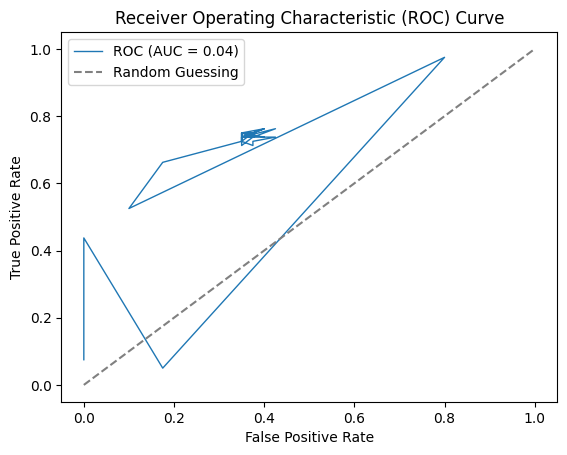

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import random
import timm
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max + 1))
    result_path_train = os.path.join(result_path,"train_{}".format(num_max + 1))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_train,exist_ok=True)
    return result_path_train


# 模型評估指標
def validation_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold_nums):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'
    plt.savefig(os.path.join(result_path,'confusion_matrix_fold'+str(fold_nums + 1)+'.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold_nums):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'
    plt.savefig(os.path.join(result_path,'Roc_curve'+str(fold_nums + 1)+'.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(result_path,parameter,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold_nums):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(result_path, 'csv_record')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(result_path + '/csv_record/epoch_fold'+str(fold_nums + 1)+'.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time','num_fold'])
        writer.writerow(parameter)
        writer.writerow('')
        writer.writerow(['Epoch','train_loss','train_acc','val_loss','val_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(train_loss_list[epoch], 4),
                            round(train_acc_list[epoch].item(), 4),
                            round(val_loss_list[epoch], 4),
                            round(val_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong_predict:',fold_wrong_predict])
    print('CSV output Sucessfully')

def print_filename_in_txt(train_loader, valid_loader, result_path, fold_num):
    # Initialize empty lists to store filenames
    train_filenames = []
    valid_filenames = []

    # Iterate over the training dataset
    for batch_idx, (data, target, filename) in enumerate(train_loader):
        # Append the filename to the list
        train_filenames.extend(filename)

    # Iterate over the validation dataset
    for batch_idx, (data, target, filename) in enumerate(valid_loader):
        # Append the filename to the list
        valid_filenames.extend(filename)

    # Create the 'file_name_record' directory if it doesn't exist
    file_record_dir = os.path.join(result_path, 'file_name_record')
    if not os.path.exists(file_record_dir):
        os.makedirs(file_record_dir)

    # Save the training filenames as a text file
    with open(result_path + '/file_name_record/train_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in train_filenames:
            file.write(filename + '\n')

    # Save the validation filenames as a text file
    with open(result_path + '/file_name_record/valid_filenames_fold_'+str(fold_num + 1)+'.txt', 'w') as file:
        for filename in valid_filenames:
            file.write(filename + '\n')

    print(f"Filenames saved in {result_path}/train_filenames.txt and {result_path}/valid_filenames.txt")

def calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, fold_nums, result_path):
    # Calculate averages
    avg_train_acc = sum(avg_train_acc_list) / fold_nums
    avg_val_acc = sum(avg_val_acc_list) / fold_nums
    avg_recall = sum(avg_recall_list) / fold_nums
    avg_precision = sum(avg_precision_list) / fold_nums
    avg_f1_score = sum(avg_f1_score_list) / fold_nums
    avg_TPR = sum(avg_TPR_list) / fold_nums
    avg_FPR = sum(avg_FPR_list) / fold_nums

    # Save averages to a text file
    with open(result_path + '/Average.txt', 'w') as file:
        file.write(f"Avg Train Accuracy: {avg_train_acc}\n")
        file.write(f"Avg Validation Accuracy: {avg_val_acc}\n")
        file.write(f"Avg Recall: {avg_recall}\n")
        file.write(f"Avg Precision: {avg_precision}\n")
        file.write(f"Avg F1 Score: {avg_f1_score}\n")
        file.write(f"Avg TPR: {avg_TPR}\n")
        file.write(f"Avg FPR: {avg_FPR}\n")

    print(f"Averages saved to {result_path}")

def train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,num_fold):
    #超參數設定
    batch_size = 52
    learning_rate = 0.001
    num_epochs = 50
    num_classes = 2
    num_folds = num_fold
    start_time = datetime.now()
    end_time = 0
    num_argumentation = 20
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    train_normal_dataset = MyDataset(train_normal_tensor_path)
    train_abnormal_dataset = MyDataset(train_abnormal_tensor_path)
    # Combine the datasets
    train_datasets = CombinedDataset(train_normal_dataset,train_abnormal_dataset)

    # Create the k-fold cross-validation object
    kfold = KFold(n_splits=num_folds)

    #印出資料集大小
    print("train dataset's size : " + str(len(train_datasets)))

    #創建模型
    # model = models.resnet152(pretrained=True)
    model = timm.create_model('seresnet152d', pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    # make dir to save the training outcome
    result_path = mkdir_outcome(result_path)

    avg_train_acc_list = []
    avg_val_acc_list = []
    avg_recall_list = []
    avg_precision_list = []
    avg_f1_score_list = []
    avg_TPR_list = []
    avg_FPR_list = []

    files = []
    file_names = os.listdir(normal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    file_names = os.listdir(abnormal_data_dir)
    for file_name in file_names:
        name = os.path.splitext(file_name)[0]
        files.append(name)

    random.shuffle(files)

    torch.save(model.state_dict(),os.path.join(result_path,"seresnet152_pre_train.pt"))

    for fold, (train_indices, valid_indices) in enumerate(kfold.split(files)):
        print(f"Fold: {fold+1}")

        #定義損失函數和優化器
        m = nn.Sigmoid()
        criterion = nn.BCELoss()
        # criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        train_loss_list = []
        train_acc_list = []
        val_loss_list = []
        val_acc_list = []
        recall_list = []
        precision_list = []
        f1_score_list = []
        TPR_list = []
        FPR_list = []
        fold_wrong_predict = []

        train_files = [files[i] for i in train_indices]
        valid_files = [files[i] for i in valid_indices]

        # 定義用於儲存訓練集和驗證集的檔案名稱的列表
        train_data_files = []
        valid_data_files = []

        # 遍歷訓練集檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in train_files:
            labels, index = file.split('_')
            # 構造增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              # 將增強後資料的檔案名稱新增至訓練集檔案名稱列表
              train_data_files.append(augmented_file)

        # 遍歷驗證集檔名，根據增強資料的命名規則，找到對應的增強檔名
        for file in valid_files:
            labels, index = file.split('_')
            # 構造增強後資料的檔名
            for num in range(1,num_argumentation + 1):
              augmented_file = f"{labels}_{index}_aug{num}.pt"
              valid_data_files.append(augmented_file)

        train = []
        valid = []

        # 遍歷combined_dataset中的樣本索引
        for index, (data, labels, filename) in enumerate(train_datasets):
            # 檢查目前樣本的檔案名稱是否在訓練集檔案名稱清單中
            if filename in train_data_files:
                train.append(index)
            # 檢查目前樣本的檔案名稱是否在驗證集檔案名稱清單中
            elif filename in valid_data_files:
                valid.append(index)

        # Create the train and validation datasets for this fold
        train_dataset = torch.utils.data.Subset(train_datasets, train)
        valid_dataset = torch.utils.data.Subset(train_datasets, valid)


        print("train_dataset : " + str(len(train_dataset)),",valid_dataset : " + str(len(valid_dataset)))

        # Create the data loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4)
        print_filename_in_txt(train_loader,valid_loader,result_path,fold)

        #訓練模型
        for epoch in range(num_epochs):
            print("epoch:"+f"{epoch+1}")
            train_loss = 0
            train_correct = 0
            train_acc = 0
            val_loss = 0
            val_corrects = 0
            val_acc = 0

            print("result_path:" + str(result_path))

            if(epoch == 0) :
              model.load_state_dict(torch.load(os.path.join(result_path,"pre_train.pt")))
              print("Model initialized")
            else :
              model.load_state_dict(torch.load(os.path.join(result_path,"train"+f'_fold_{fold+1}'+".pt")))
              print("Model loaded")

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Training Progress]: ")
            model.train()
            for inputs, labels, filename in tqdm(train_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(m(outputs),targets.float())
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels.data)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_correct.double() / len(train_loader.dataset)
            train_loss_list.append(train_loss)

            model.eval()

            print("[Validating Progress]: ")
            wrong_predict = []
            for inputs, labels, filename in tqdm(valid_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(m(outputs),targets.float())
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            val_loss = val_loss / len(valid_loader.dataset)
            val_acc = val_corrects.double() / len(valid_loader.dataset)
            val_loss_list.append(val_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  train_loss: {:<.4f}  -  train_accuracy: {:<.4f} -  val_loss: {:<.4f}  -  val_accuracy: {:<.4f}  -  val_correct: {:<10}'.format(
                epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc, val_corrects))
            print('wrong predict : ' + str(wrong_predict))
            torch.save(model.state_dict(),os.path.join(result_path,"train"+f'_fold_{fold+1}'+".pt"))
            print("Model saved")

            # validation index (評估指標)
            precision,recall,f1_score,TPR,FPR = validation_index(conf_matrix)

            # record the outcomes
            val_acc_list.append(val_acc),train_acc_list.append(train_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              torch.cuda.empty_cache()
              avg_train_acc_list.append(train_acc),avg_val_acc_list.append(val_acc),avg_recall_list.append(recall),avg_precision_list.append(precision),avg_f1_score_list.append(f1_score),avg_TPR_list.append(TPR),avg_FPR_list.append(FPR),fold_wrong_predict.append(wrong_predict)

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(result_path,conf_matrix,fold)
        # functioN to show ROC curve
        ROC_Curve(result_path,TPR_list,FPR_list,fold)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time,fold]
        CSV_Output(result_path,param,num_epochs,train_loss_list,train_acc_list,val_loss_list,val_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,fold_wrong_predict,fold)

    #calculate the average
    calculate_average(avg_train_acc_list, avg_val_acc_list, avg_recall_list, avg_precision_list, avg_f1_score_list, avg_TPR_list, avg_FPR_list, num_folds, result_path)

    torch.cuda.empty_cache()


normal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/normal'
abnormal_data_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset/train/abnormal'
train_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/normal'
train_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/train/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result'

train(normal_data_dir,abnormal_data_dir,train_normal_tensor_path,train_abnormal_tensor_path,result_path,5)

#測試模型

dataset's size : 15
Device used : cuda
test_result_path : /content/drive/My Drive/Deep_X_torch/result/result_2/test_2
train_result_path : /content/drive/My Drive/Deep_X_torch/result/result_2/train_2
train model:train_fold_1.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 13.00it/s]



Epoch: [1/5]  test_loss: 0.8756  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',), ('abnormal_16.pt',), ('normal_15.pt',)]
	      Precision: 0.6667  -  Recall: 0.4000  -  F1 Score: 0.5000
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.28it/s]



Epoch: [2/5]  test_loss: 0.8756  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('abnormal_16.pt',), ('normal_10.pt',), ('normal_15.pt',), ('normal_1.pt',)]
	      Precision: 0.6667  -  Recall: 0.4000  -  F1 Score: 0.5000
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]



Epoch: [3/5]  test_loss: 0.8756  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_10.pt',), ('abnormal_16.pt',), ('normal_15.pt',), ('normal_1.pt',)]
	      Precision: 0.6667  -  Recall: 0.4000  -  F1 Score: 0.5000
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 17.36it/s]



Epoch: [4/5]  test_loss: 0.8756  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_10.pt',), ('abnormal_16.pt',), ('normal_1.pt',), ('normal_15.pt',)]
	      Precision: 0.6667  -  Recall: 0.4000  -  F1 Score: 0.5000
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.96it/s]



Epoch: [5/5]  test_loss: 0.8756  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('abnormal_16.pt',), ('normal_1.pt',), ('normal_10.pt',), ('normal_15.pt',)]
	      Precision: 0.6667  -  Recall: 0.4000  -  F1 Score: 0.5000
Confusion matrix:
[[2 1]
 [3 9]]
CSV output Sucessfully
Confusion matrix:
[[2 1]
 [3 9]]


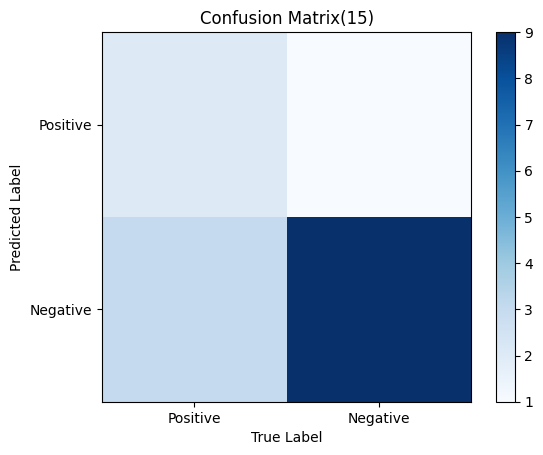

train model:train_fold_2.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.73it/s]



Epoch: [1/5]  test_loss: 0.4177  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_16.pt',), ('normal_1.pt',), ('normal_10.pt',), ('normal_15.pt',), ('normal_1.pt',), ('abnormal_16.pt',), ('normal_10.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 10.69it/s]



Epoch: [2/5]  test_loss: 0.4177  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',), ('abnormal_16.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]



Epoch: [3/5]  test_loss: 0.4177  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_16.pt',), ('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 17.40it/s]



Epoch: [4/5]  test_loss: 0.4177  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_16.pt',), ('normal_1.pt',), ('normal_10.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.48it/s]



Epoch: [5/5]  test_loss: 0.4177  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_10.pt',), ('abnormal_16.pt',), ('normal_1.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
Confusion matrix:
[[3 1]
 [2 9]]
CSV output Sucessfully
Confusion matrix:
[[3 1]
 [2 9]]


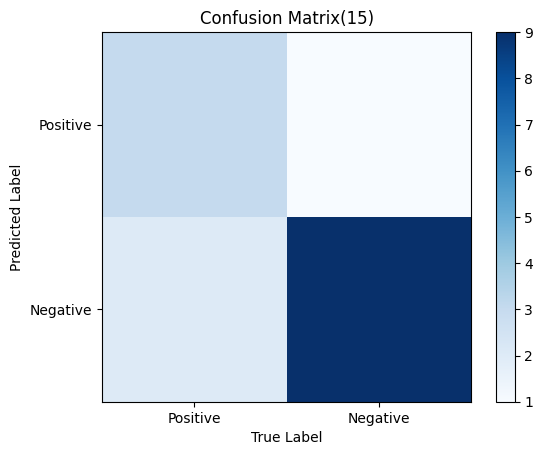

train model:train_fold_3.pt
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 15.46it/s]



Epoch: [1/5]  test_loss: 0.4800  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('normal_10.pt',), ('abnormal_16.pt',), ('normal_1.pt',), ('abnormal_24.pt',)]
	      Precision: 0.8333  -  Recall: 1.0000  -  F1 Score: 0.9091
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 15.79it/s]



Epoch: [2/5]  test_loss: 0.4800  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('abnormal_24.pt',)]
	      Precision: 0.8333  -  Recall: 1.0000  -  F1 Score: 0.9091
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 12.37it/s]



Epoch: [3/5]  test_loss: 0.4800  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('abnormal_24.pt',)]
	      Precision: 0.8333  -  Recall: 1.0000  -  F1 Score: 0.9091
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 10.81it/s]



Epoch: [4/5]  test_loss: 0.4800  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('abnormal_24.pt',)]
	      Precision: 0.8333  -  Recall: 1.0000  -  F1 Score: 0.9091
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.44it/s]



Epoch: [5/5]  test_loss: 0.4800  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('abnormal_24.pt',)]
	      Precision: 0.8333  -  Recall: 1.0000  -  F1 Score: 0.9091
Confusion matrix:
[[5 1]
 [0 9]]
CSV output Sucessfully
Confusion matrix:
[[5 1]
 [0 9]]


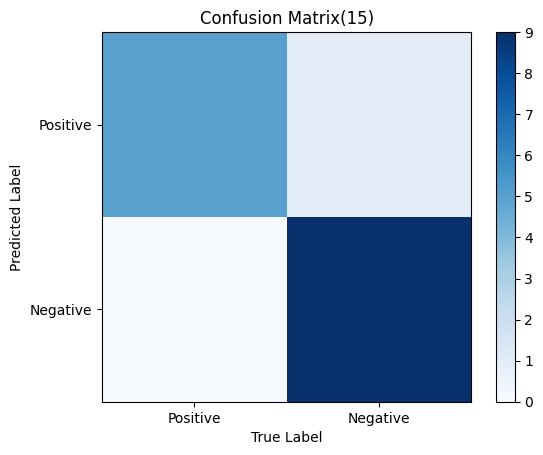

train model:train_fold_4.pt
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 15.93it/s]



Epoch: [1/5]  test_loss: 0.8055  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('abnormal_24.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.8000  -  F1 Score: 0.8889
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.89it/s]



Epoch: [2/5]  test_loss: 0.8055  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.8000  -  F1 Score: 0.8889
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 17.00it/s]



Epoch: [3/5]  test_loss: 0.8055  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.8000  -  F1 Score: 0.8889
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.88it/s]



Epoch: [4/5]  test_loss: 0.8055  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.8000  -  F1 Score: 0.8889
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 12.06it/s]



Epoch: [5/5]  test_loss: 0.8055  -  test_accuracy: 0.9333  -  test_correct: 14        
wrong predicts : [('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.8000  -  F1 Score: 0.8889
Confusion matrix:
[[ 4  0]
 [ 1 10]]
CSV output Sucessfully
Confusion matrix:
[[ 4  0]
 [ 1 10]]


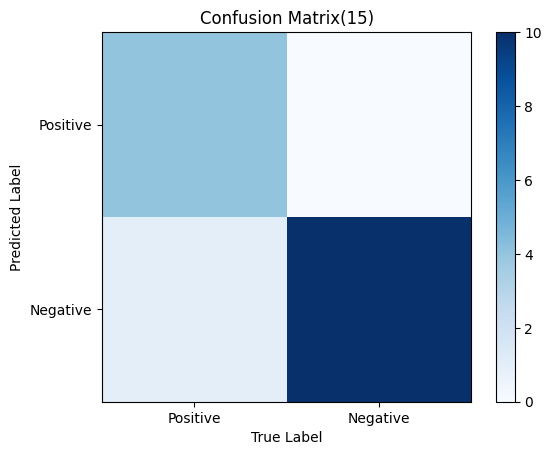

train model:train_fold_5.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.59it/s]



Epoch: [1/5]  test_loss: 0.5036  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_1.pt',), ('normal_15.pt',), ('abnormal_24.pt',), ('normal_10.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.40it/s]



Epoch: [2/5]  test_loss: 0.5036  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_24.pt',), ('normal_15.pt',), ('normal_10.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 17.10it/s]



Epoch: [3/5]  test_loss: 0.5036  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_24.pt',), ('normal_10.pt',), ('normal_15.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.64it/s]



Epoch: [4/5]  test_loss: 0.5036  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_10.pt',), ('normal_15.pt',), ('abnormal_24.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
[Test Progress]: 


100%|██████████| 15/15 [00:00<00:00, 16.72it/s]



Epoch: [5/5]  test_loss: 0.5036  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_15.pt',), ('abnormal_24.pt',), ('normal_10.pt',)]
	      Precision: 0.7500  -  Recall: 0.6000  -  F1 Score: 0.6667
Confusion matrix:
[[3 1]
 [2 9]]
CSV output Sucessfully
Confusion matrix:
[[3 1]
 [2 9]]


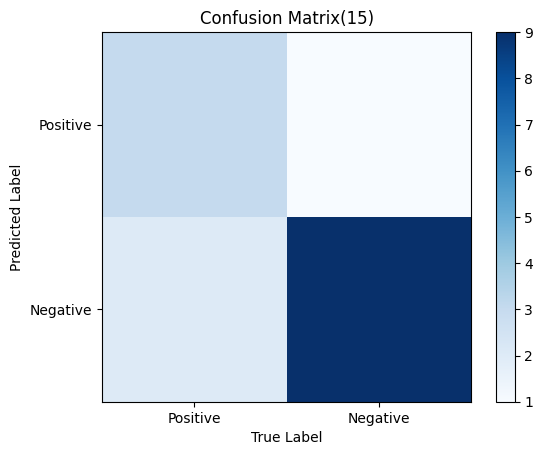

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()

# 找尋最新的訓練結果
def find_train_result_path(result_path):
    file_names = os.listdir(result_path)
    train_result_path = None
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if num > num_max:
                num_max = num

    result_path = os.path.join(result_path,"result_{}".format(num_max))
    train_result_path = os.path.join(result_path,"train_{}".format(num_max))
    return train_result_path


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max))
    result_path_test = os.path.join(result_path,"test_{}".format(num_max))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_test,exist_ok=True)
    return result_path_test


# 模型評估指標
def test_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,fold):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record'+f'{fold}')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'+f'{fold}'
    plt.savefig(os.path.join(result_path,'test_confusion_matrix.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,fold):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record'+f'{fold}')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'+f'{fold}'
    plt.savefig(os.path.join(result_path,'test_Roc_curve.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,fold):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(test_result_path, 'csv_record'+f'{fold}')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(test_result_path + '/csv_record'+f'{fold}'+'/test_epoch.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time'])
        writer.writerow(param)
        writer.writerow('')
        writer.writerow(['Epoch','test_loss','test_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(test_loss_list[epoch], 4),
                            round(test_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong predict:',final_wrong_predict])
    print('CSV output Sucessfully')

def test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,fold):
    #超參數設定
    batch_size = 1
    learning_rate = 0.001
    num_epochs = 5
    num_classes = 2
    start_time = datetime.now()
    end_time = 0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    test_normal_dataset = MyDataset(test_normal_tensor_path)
    test_abnormal_dataset = MyDataset(test_abnormal_tensor_path)

    # Combine the datasets
    test_dataset = CombinedDataset(test_normal_dataset,test_abnormal_dataset)

    #印出資料集大小
    print("dataset's size : " + str(len(test_dataset)))

    #創建模型
    model = models.resnet152(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    #定義損失函數和優化器
    m = nn.Sigmoid()
    criterion = nn.BCELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    test_loss_list = []
    test_acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    TPR_list = []
    FPR_list = []
    wrong_predict = []
    final_wrong_predict = []

    # make dir to save the training outcome
    test_result_path = mkdir_outcome(result_path)
    print('test_result_path : ' + str(test_result_path))

    train_result_path = find_train_result_path(result_path)
    print('train_result_path : ' + str(train_result_path))

    for folds in range(1,fold + 1):

        print("train model:"+"train"+f'_fold_{folds}'+".pt")

        # 載入訓練好的模型參數
        model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold{folds}'+".pt")))
        test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)

        #測試模型
        for epoch in range(num_epochs):
            test_loss = 0
            test_corrects = 0
            test_acc = 0
            model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold{folds}'+".pt")))
            model.eval()

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Test Progress]: ")
            for inputs, labels, filename in tqdm(test_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs.to(device))
                    loss = criterion(m(outputs),targets.float())
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            test_loss =  test_loss / len(test_loader.dataset)
            test_acc =  test_corrects.double() / len(test_loader.dataset)
            test_loss_list.append(test_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  test_loss: {:<.4f}  -  test_accuracy: {:<.4f}  -  test_correct: {:<10}'.format(
                epoch+1, num_epochs, test_loss, test_acc, test_corrects))
            print('wrong predicts : ' + str(wrong_predict))


            # teat index (評估指標)
            precision,recall,f1_score,TPR,FPR = test_index(conf_matrix)

            # record the outcomes
            test_acc_list.append(test_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              final_wrong_predict.append(wrong_predict)
            else:
              wrong_predict.clear()

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(test_result_path,conf_matrix,folds)
        # functio to show ROC curve
        ROC_Curve(test_result_path,TPR_list,FPR_list,folds)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time]
        CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds)

        confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
        print("Confusion matrix:")
        print(conf_matrix)
        plt.clf()
        plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Positive', 'Negative'])
        plt.yticks(tick_marks, ['Positive', 'Negative'])
        plt.ylabel('Predicted Label')
        plt.xlabel('True Label')
        plt.title('Confusion Matrix({})'.format(len(test_dataset)))
        plt.show()

        torch.cuda.empty_cache()


test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result'

test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,5)



#測試模型(SEResNet)

In [ ]:
!pip install timm

dataset's size : 15
Device used : cuda
test_result_path : /content/drive/My Drive/Deep_X_torch/result/result_1/test_1
train_result_path : /content/drive/My Drive/Deep_X_torch/result/result_1/train_1
train model:train_fold_1.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.21it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Epoch: [1/5]  test_loss: 0.5005  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_4.pt',), ('normal_15.pt',), ('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.77it/s]



Epoch: [2/5]  test_loss: 0.5005  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_15.pt',), ('normal_4.pt',), ('normal_1.pt',), ('normal_10.pt',)]
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00,  9.46it/s]



Epoch: [3/5]  test_loss: 0.5005  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_1.pt',), ('normal_15.pt',), ('normal_4.pt',), ('normal_10.pt',)]
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
[Test Progress]: 


100%|██████████| 15/15 [00:02<00:00,  6.14it/s]



Epoch: [4/5]  test_loss: 0.5005  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',), ('normal_4.pt',), ('normal_15.pt',)]
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
[Test Progress]: 


100%|██████████| 15/15 [00:02<00:00,  5.74it/s]



Epoch: [5/5]  test_loss: 0.5005  -  test_accuracy: 0.7333  -  test_correct: 11        
wrong predicts : [('normal_4.pt',), ('normal_1.pt',), ('normal_15.pt',), ('normal_10.pt',)]
	      Precision: 1.0000  -  Recall: 0.2000  -  F1 Score: 0.3333
Confusion matrix:
[[ 1  0]
 [ 4 10]]
CSV output Sucessfully
Confusion matrix:
[[ 1  0]
 [ 4 10]]


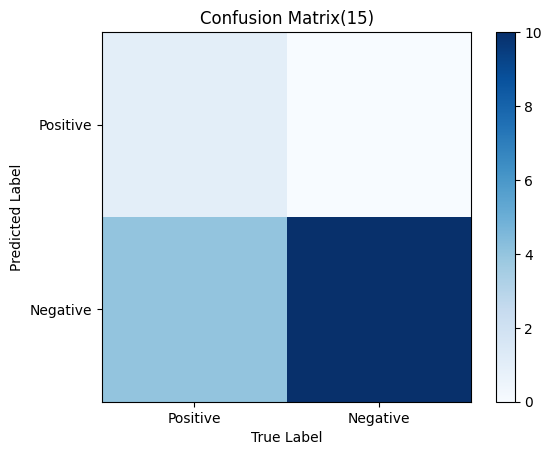

train model:train_fold_2.pt
[Test Progress]: 


100%|██████████| 15/15 [00:02<00:00,  6.91it/s]



Epoch: [1/5]  test_loss: 2.0975  -  test_accuracy: 0.6667  -  test_correct: 10        
wrong predicts : [('normal_4.pt',), ('normal_1.pt',), ('normal_15.pt',), ('normal_10.pt',), ('abnormal_30.pt',), ('abnormal_16.pt',), ('normal_10.pt',), ('normal_4.pt',), ('abnormal_24.pt',)]
	      Precision: 0.5000  -  Recall: 0.6000  -  F1 Score: 0.5455
[Test Progress]: 


100%|██████████| 15/15 [00:04<00:00,  3.73it/s]



Epoch: [2/5]  test_loss: 2.0975  -  test_accuracy: 0.6667  -  test_correct: 10        
wrong predicts : [('abnormal_30.pt',), ('normal_10.pt',), ('normal_4.pt',), ('abnormal_16.pt',), ('abnormal_24.pt',)]
	      Precision: 0.5000  -  Recall: 0.6000  -  F1 Score: 0.5455
[Test Progress]: 


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]



Epoch: [3/5]  test_loss: 2.0975  -  test_accuracy: 0.6667  -  test_correct: 10        
wrong predicts : [('abnormal_16.pt',), ('abnormal_30.pt',), ('normal_4.pt',), ('normal_10.pt',), ('abnormal_24.pt',)]
	      Precision: 0.5000  -  Recall: 0.6000  -  F1 Score: 0.5455
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00,  8.34it/s]



Epoch: [4/5]  test_loss: 2.0975  -  test_accuracy: 0.6667  -  test_correct: 10        
wrong predicts : [('abnormal_16.pt',), ('abnormal_30.pt',), ('normal_10.pt',), ('normal_4.pt',), ('abnormal_24.pt',)]
	      Precision: 0.5000  -  Recall: 0.6000  -  F1 Score: 0.5455
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]



Epoch: [5/5]  test_loss: 2.0975  -  test_accuracy: 0.6667  -  test_correct: 10        
wrong predicts : [('normal_4.pt',), ('abnormal_30.pt',), ('abnormal_24.pt',), ('abnormal_16.pt',), ('normal_10.pt',)]
	      Precision: 0.5000  -  Recall: 0.6000  -  F1 Score: 0.5455
Confusion matrix:
[[3 3]
 [2 7]]
CSV output Sucessfully
Confusion matrix:
[[3 3]
 [2 7]]


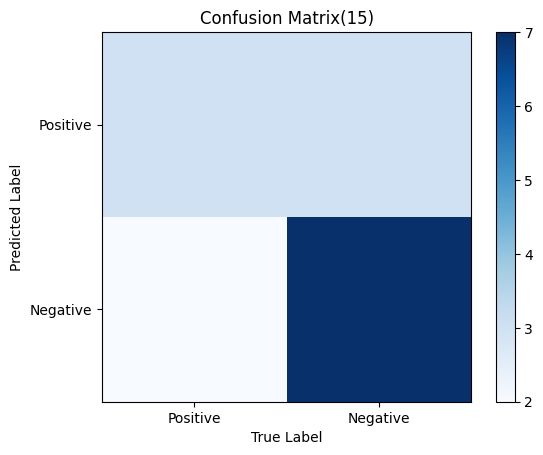

train model:train_fold_3.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00,  9.46it/s]



Epoch: [1/5]  test_loss: 1.6784  -  test_accuracy: 0.5333  -  test_correct: 8         
wrong predicts : [('normal_4.pt',), ('abnormal_30.pt',), ('abnormal_24.pt',), ('abnormal_16.pt',), ('normal_10.pt',), ('abnormal_30.pt',), ('normal_1.pt',), ('normal_10.pt',), ('abnormal_24.pt',), ('normal_15.pt',), ('normal_4.pt',), ('abnormal_9.pt',)]
	      Precision: 0.2500  -  Recall: 0.2000  -  F1 Score: 0.2222
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.46it/s]



Epoch: [2/5]  test_loss: 1.6784  -  test_accuracy: 0.5333  -  test_correct: 8         
wrong predicts : [('normal_1.pt',), ('normal_4.pt',), ('abnormal_9.pt',), ('abnormal_24.pt',), ('normal_15.pt',), ('normal_10.pt',), ('abnormal_30.pt',)]
	      Precision: 0.2500  -  Recall: 0.2000  -  F1 Score: 0.2222
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.74it/s]



Epoch: [3/5]  test_loss: 1.6784  -  test_accuracy: 0.5333  -  test_correct: 8         
wrong predicts : [('normal_1.pt',), ('abnormal_24.pt',), ('normal_10.pt',), ('abnormal_9.pt',), ('abnormal_30.pt',), ('normal_15.pt',), ('normal_4.pt',)]
	      Precision: 0.2500  -  Recall: 0.2000  -  F1 Score: 0.2222
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.75it/s]



Epoch: [4/5]  test_loss: 1.6784  -  test_accuracy: 0.5333  -  test_correct: 8         
wrong predicts : [('abnormal_9.pt',), ('normal_4.pt',), ('abnormal_30.pt',), ('abnormal_24.pt',), ('normal_1.pt',), ('normal_15.pt',), ('normal_10.pt',)]
	      Precision: 0.2500  -  Recall: 0.2000  -  F1 Score: 0.2222
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.86it/s]



Epoch: [5/5]  test_loss: 1.6784  -  test_accuracy: 0.5333  -  test_correct: 8         
wrong predicts : [('normal_1.pt',), ('abnormal_30.pt',), ('normal_15.pt',), ('normal_10.pt',), ('normal_4.pt',), ('abnormal_9.pt',), ('abnormal_24.pt',)]
	      Precision: 0.2500  -  Recall: 0.2000  -  F1 Score: 0.2222
Confusion matrix:
[[1 3]
 [4 7]]
CSV output Sucessfully
Confusion matrix:
[[1 3]
 [4 7]]


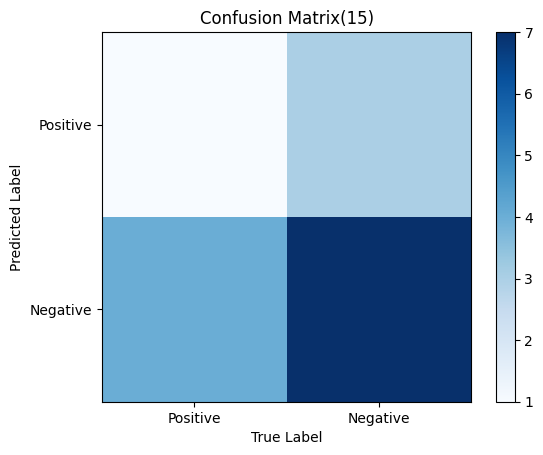

train model:train_fold_4.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 10.86it/s]



Epoch: [1/5]  test_loss: 0.6136  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('normal_1.pt',), ('abnormal_30.pt',), ('normal_15.pt',), ('normal_10.pt',), ('normal_4.pt',), ('abnormal_9.pt',), ('abnormal_24.pt',), ('abnormal_30.pt',), ('abnormal_24.pt',), ('abnormal_19.pt',)]
	      Precision: 0.6250  -  Recall: 1.0000  -  F1 Score: 0.7692
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00,  9.83it/s]



Epoch: [2/5]  test_loss: 0.6136  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_19.pt',), ('abnormal_24.pt',), ('abnormal_30.pt',)]
	      Precision: 0.6250  -  Recall: 1.0000  -  F1 Score: 0.7692
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]



Epoch: [3/5]  test_loss: 0.6136  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_24.pt',), ('abnormal_19.pt',), ('abnormal_30.pt',)]
	      Precision: 0.6250  -  Recall: 1.0000  -  F1 Score: 0.7692
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.81it/s]



Epoch: [4/5]  test_loss: 0.6136  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_24.pt',), ('abnormal_30.pt',), ('abnormal_19.pt',)]
	      Precision: 0.6250  -  Recall: 1.0000  -  F1 Score: 0.7692
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.95it/s]



Epoch: [5/5]  test_loss: 0.6136  -  test_accuracy: 0.8000  -  test_correct: 12        
wrong predicts : [('abnormal_19.pt',), ('abnormal_24.pt',), ('abnormal_30.pt',)]
	      Precision: 0.6250  -  Recall: 1.0000  -  F1 Score: 0.7692
Confusion matrix:
[[5 3]
 [0 7]]
CSV output Sucessfully
Confusion matrix:
[[5 3]
 [0 7]]


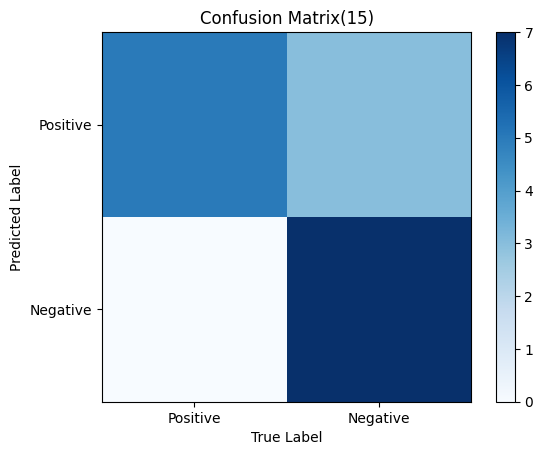

train model:train_fold_5.pt
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]



Epoch: [1/5]  test_loss: 0.2657  -  test_accuracy: 0.8667  -  test_correct: 13        
wrong predicts : [('abnormal_19.pt',), ('abnormal_24.pt',), ('abnormal_30.pt',), ('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 10.86it/s]



Epoch: [2/5]  test_loss: 0.2657  -  test_accuracy: 0.8667  -  test_correct: 13        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00,  9.41it/s]



Epoch: [3/5]  test_loss: 0.2657  -  test_accuracy: 0.8667  -  test_correct: 13        
wrong predicts : [('normal_1.pt',), ('normal_10.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.86it/s]



Epoch: [4/5]  test_loss: 0.2657  -  test_accuracy: 0.8667  -  test_correct: 13        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
[Test Progress]: 


100%|██████████| 15/15 [00:01<00:00, 14.74it/s]



Epoch: [5/5]  test_loss: 0.2657  -  test_accuracy: 0.8667  -  test_correct: 13        
wrong predicts : [('normal_10.pt',), ('normal_1.pt',)]
	      Precision: 1.0000  -  Recall: 0.6000  -  F1 Score: 0.7500
Confusion matrix:
[[ 3  0]
 [ 2 10]]
CSV output Sucessfully
Confusion matrix:
[[ 3  0]
 [ 2 10]]


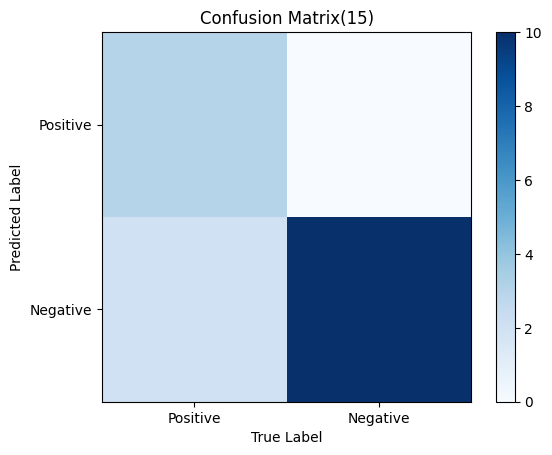

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import csv
import timm
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.class_to_idx = {'abnormal': 1, 'normal': 0}  # 定義類別名稱到類別索引的映射
        self.data = []
        self.filenames = []  # store filenames
        for filename in os.listdir(data_path):
            if filename.endswith('.pt'):
                tensor = torch.load(os.path.join(data_path, filename))
                if filename.split('_')[0] == 'normal':
                    label_idx = 0
                else:
                    label_idx = 1
                self.data.append((tensor, label_idx, filename))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tensor, labels, filename = self.data[index]
        return tensor, labels, filename

class CombinedDataset(ConcatDataset):
    def __init__(self, dataset1, dataset2):
        super().__init__([dataset1, dataset2])

    def __getitem__(self, index):
        return super().__getitem__(index)

    def __len__(self):
        return super().__len__()

# 找尋最新的訓練結果
def find_train_result_path(result_path):
    file_names = os.listdir(result_path)
    train_result_path = None
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if num > num_max:
                num_max = num

    result_path = os.path.join(result_path,"result_{}".format(num_max))
    train_result_path = os.path.join(result_path,"train_{}".format(num_max))
    return train_result_path


# 建立資料夾顯示訓練結果
def mkdir_outcome(result_path):
    file_names = os.listdir(result_path)
    num_max = 0
    for file_name in file_names:
        if file_name.startswith("result_"):
            num_str = file_name.split("_")[1]
            num = int(num_str)
            if(num > num_max):
                num_max = num
    # make folder for train result
    result_path = os.path.join(result_path,"result_{}".format(num_max))
    result_path_test = os.path.join(result_path,"test_{}".format(num_max))
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_path_test,exist_ok=True)
    return result_path_test


# 模型評估指標
def test_index(conf_matrix):
    # Confusion Matrix to calculate [accuracy,precision,recall]
    precision = 0.0
    recall = 0.0
    f1_score = 0.0
    if((conf_matrix[0][0] + conf_matrix[0][1]) != 0):
        precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    if((conf_matrix[0][0] + conf_matrix[1][0]) != 0):
        recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
    if((precision + recall) != 0):
        f1_score = 2*precision*recall / (precision + recall)
    TPR = recall
    FPR = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    print("\t      Precision: {:<.4f}  -  Recall: {:<.4f}  -  F1 Score: {:<.4f}".format(precision,recall,f1_score))
    return precision,recall,f1_score,TPR,FPR


# 混淆矩陣
def Confusion_Matrix(result_path,conf_matrix,folds):
    # Create the 'confusion_matrix_record' directory if it doesn't exist
    confusion_matrix_record_dir = os.path.join(result_path, 'confusion_matrix_record'+'_fold'+f'{folds}')
    plt.clf()
    if not os.path.exists(confusion_matrix_record_dir):
        os.makedirs(confusion_matrix_record_dir)

    confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
    print("Confusion matrix:")
    print(conf_matrix)
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()

    # confusion matrix index 各個 index 的數值
    for i in range(2):
        for j in range(2):
            text_color = 'black' if confusion_matrix[i][j] < 0.5 * confusion_matrix.max() else 'white'
            plt.annotate(str(confusion_matrix[i][j]), xy=(j, i), ha='center', va='center', color=text_color)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Positive', 'Negative'])
    plt.yticks(tick_marks, ['Positive', 'Negative'])
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    plt.title('Confusion Matrix')
    result_path = result_path + '/confusion_matrix_record'+'_fold'+f'{folds}'
    plt.savefig(os.path.join(result_path,'test_confusion_matrix.png'))


# ROC曲線
def ROC_Curve(result_path,tpr_list,fpr_list,folds):
    # Create the 'roc_curve_record' directory if it doesn't exist
    roc_curve_record_dir = os.path.join(result_path, 'roc_curve_record'+'_fold'+f'{folds}')
    if not os.path.exists(roc_curve_record_dir):
        os.makedirs(roc_curve_record_dir)

    # 計算 AUC
    roc_auc = np.trapz(tpr_list, fpr_list)

    # 繪製 ROC 曲線
    plt.clf()
    plt.plot(fpr_list, tpr_list, lw=1, label='ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guessing')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    result_path = result_path + '/roc_curve_record'+'_fold'+f'{folds}'
    plt.savefig(os.path.join(result_path,'test_Roc_curve.png'))


# 輸出每一次 epoch 的結果
def CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds):
    # Create the 'csv_record' directory if it doesn't exist
    csv_record_dir = os.path.join(test_result_path, 'csv_record'+'_fold'+f'{folds}')
    if not os.path.exists(csv_record_dir):
        os.makedirs(csv_record_dir)
    with open(csv_record_dir + '/test_epoch.csv','w',newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['num_epochs','batch_size','learning_rate','num_classes','device','start_time','end_time'])
        writer.writerow(param)
        writer.writerow('')
        writer.writerow(['Epoch','test_loss','test_acc','precision','recall','TPR','FPR','F1 score'])
        for epoch in range(num_epochs):
            writer.writerow([epoch + 1,
                            round(test_loss_list[epoch], 4),
                            round(test_acc_list[epoch].item(), 4),
                            round(precision_list[epoch], 4),
                            round(recall_list[epoch], 4),
                            round(TPR_list[epoch], 4),
                            round(FPR_list[epoch], 4),
                            round(f1_score_list[epoch], 4)])
        writer.writerow([f'wrong predict:',final_wrong_predict])
    print('CSV output Sucessfully')

def test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,fold):
    #超參數設定
    batch_size = 1
    learning_rate = 0.001
    num_epochs = 5
    num_classes = 2
    start_time = datetime.now()
    end_time = 0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Get the dataset
    test_normal_dataset = MyDataset(test_normal_tensor_path)
    test_abnormal_dataset = MyDataset(test_abnormal_tensor_path)

    # Combine the datasets
    test_dataset = CombinedDataset(test_normal_dataset,test_abnormal_dataset)

    #印出資料集大小
    print("dataset's size : " + str(len(test_dataset)))

    #創建模型
    # model = models.resnet152(pretrained=False)
    model = timm.create_model('seresnet152d', pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #print(model)
    #print(model.fc)

    #將模型移動到GPU上進行運算
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.fc.to(device)
    print("Device used : " + str(device))

    #定義損失函數和優化器
    m = nn.Sigmoid()
    criterion = nn.BCELoss()
    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    test_loss_list = []
    test_acc_list = []
    recall_list = []
    precision_list = []
    f1_score_list = []
    TPR_list = []
    FPR_list = []
    wrong_predict = []
    final_wrong_predict = []

    # make dir to save the training outcome
    test_result_path = mkdir_outcome(result_path)
    print('test_result_path : ' + str(test_result_path))

    train_result_path = find_train_result_path(result_path)
    print('train_result_path : ' + str(train_result_path))

    for folds in range(1,fold + 1):

        print("train model:"+"train"+f'_fold_{folds}'+".pt")

        # 載入訓練好的模型參數
        model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold_{folds}'+".pt")))
        test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4)

        #測試模型
        for epoch in range(num_epochs):
            test_loss = 0
            test_corrects = 0
            test_acc = 0
            model.load_state_dict(torch.load(os.path.join(train_result_path, "train"+f'_fold_{folds}'+".pt")))
            model.eval()

            #初始化
            conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

            print("[Test Progress]: ")
            for inputs, labels, filename in tqdm(test_loader):
                targets=torch.eye(2)[labels.long(), :]
                inputs = inputs.to(device)
                labels = labels.to(device)
                targets = targets.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs.to(device))
                    loss = criterion(m(outputs),targets.float())
                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

                # Count Confusion Matrix
                for t, p in zip(preds.view(-1), labels.view(-1)):
                    conf_matrix[t.long(), p.long()] += 1
                    if t != p:
                      wrong_predict.append(filename)
            test_loss =  test_loss / len(test_loader.dataset)
            test_acc =  test_corrects.double() / len(test_loader.dataset)
            test_loss_list.append(test_loss)

            scheduler.step()
            end_time = datetime.now()
            print('\nEpoch: [{}/{}]  test_loss: {:<.4f}  -  test_accuracy: {:<.4f}  -  test_correct: {:<10}'.format(
                epoch+1, num_epochs, test_loss, test_acc, test_corrects))
            print('wrong predicts : ' + str(wrong_predict))


            # teat index (評估指標)
            precision,recall,f1_score,TPR,FPR = test_index(conf_matrix)

            # record the outcomes
            test_acc_list.append(test_acc),precision_list.append(precision),recall_list.append(recall)
            f1_score_list.append(f1_score),TPR_list.append(TPR),FPR_list.append(FPR)

            if epoch + 1 == num_epochs:
              final_wrong_predict.append(wrong_predict)
            else:
              wrong_predict.clear()

        # function of confusion matrix param(folder path, matrix, test normal dataset length, test unnormal dataset length)
        Confusion_Matrix(test_result_path,conf_matrix,folds)
        # functio to show ROC curve
        ROC_Curve(test_result_path,TPR_list,FPR_list,folds)
        # CSV visualization
        param = [num_epochs,batch_size,learning_rate,num_classes,device,start_time,end_time]
        CSV_Output(test_result_path,param,num_epochs,test_loss_list,test_acc_list,precision_list,recall_list,TPR_list,FPR_list,f1_score_list,final_wrong_predict,folds)

        confusion_matrix = np.array([[conf_matrix[0][0], conf_matrix[0][1]], [conf_matrix[1][0], conf_matrix[1][1]]])
        print("Confusion matrix:")
        print(conf_matrix)
        plt.clf()
        plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
        plt.colorbar()
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Positive', 'Negative'])
        plt.yticks(tick_marks, ['Positive', 'Negative'])
        plt.ylabel('Predicted Label')
        plt.xlabel('True Label')
        plt.title('Confusion Matrix({})'.format(len(test_dataset)))
        plt.show()

        torch.cuda.empty_cache()


test_normal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/normal'
test_abnormal_tensor_path = '/content/drive/My Drive/Deep_X_torch/tensor/test/abnormal'
result_path = '/content/drive/My Drive/Deep_X_torch/result'

test(test_normal_tensor_path,test_abnormal_tensor_path,result_path,5)



#清除資料

In [ ]:
import os
import torch

def delete_file_under_path(path):
    for root, directories, files in os.walk(path):
        for file in files:
            os.remove(os.path.join(root, file))

def delete_folder_under_path(path):
    for root, directories, files in os.walk(path, topdown=False):
        for directory in directories:
            folder_path = os.path.join(root, directory)
            os.rmdir(folder_path)

normal_jpg_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal(.jpg)'
normal_label_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/normal/normal_label'
abnormal_jpg_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal(.jpg)'
abnormal_label_path = '/content/drive/My Drive/Deep_X_torch/original_dataset/abnormal/abnormal_label'
processed_dir = '/content/drive/My Drive/Deep_X_torch/processed_dataset'
splitted_dir = '/content/drive/My Drive/Deep_X_torch/splitted_dataset'
tesor_path = '/content/drive/My Drive/Deep_X_torch/tensor'
result_path = '/content/drive/My Drive/Deep_X_torch/result/'

torch.cuda.empty_cache()

# delete_file_under_path(normal_jpg_path)
# delete_file_under_path(abnormal_jpg_path)
# delete_file_under_path(normal_label_path)
# delete_file_under_path(abnormal_label_path)
# delete_file_under_path(processed_dir)
# delete_file_under_path(splitted_dir)
# delete_file_under_path(tesor_path)

# delete_file_under_path(result_path)
# delete_folder_under_path(result_path)